In [103]:
# Quizás podría usar la máscara para enmascarar la imagen original (multiplico una matriz por otra, pero antes
# invirtiendo la original para que el fondo quede en negro y los ojos en blanco) y buscar los valores más altos en esa
# matriz resultante (que deberían ser los ojos)

In [147]:
# Importo librerías necesarias

import cv2
import pylab as plt
import matplotlib
import numpy as np
import pickle
import pandas as pd
import os
from sklearn.linear_model import LinearRegression
import time
import pykalman
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
import functools
import traceback

(cv2version, _, _) = cv2.__version__.split(".")
cv2version = int(cv2version)

In [148]:
# DIRECTORIO DONDE ESTÁN LOS DATOS
data_dir = 'C:/Users/Labo/Google Drive/Multimodal Integration/Analisis/Zebrafish'
#data_dir = 'C:/Users/LABO\My Drive/Multimodal Integration/Analisis/Zebrafish'

# DIRECTORIO DONDE ESTÁN LOS VIDEOS
#video_dir = 'C:/Users/Labo/Desktop/Videos/Temp'
video_dir = 'D:/Nico/Videos Zebrafish'
#video_dir = 'C:/Users/LABO/My Drive/Multimodal Integration/Scripts/Tracking/Videos'

# CONDICIONES PARA ANALIZAR VIDEO
cond_keys = []
cond_values = []

IDrange = (3102, 3104)

# ELIJO VIDEO

#video_name = None # miro todos los videos en el directorio
#video_name = ['multi2-12152021114910-0000', 'multi2-12152021115059-0000', 'multi2-12152021115413-0000', 'multi2-12152021131019-0000', 'multi2-12152021133710-0000', 'multi2-12152021152023-0000', 'multi2-12202021121902-0000', 'multi2-12202021122101-0000', 'multi2-12202021122326-0000', 'multi2-12202021122913-0000', 'multi2-12202021123143-0000', 'multi2-12202021123516-0000', 'multi2-12202021135008-0000', 'multi2-12202021135203-0000', 'multi2-12202021143701-0000', 'multi2-12202021144421-0000', 'multi2-12202021144821-0000', 'multi2-12202021144926-0000', 'multi2-12202021145101-0000']
video_name = ['multi2-12152021112039-0000',
 'multi2-12152021113012-0000',
 'multi2-12152021114910-0000',
 'multi2-12152021115059-0000',
 'multi2-12152021115413-0000',
 'multi2-12152021121934-0000',
 'multi2-12152021122306-0000',
 'multi2-12152021122739-0000',
 'multi2-12152021123312-0000',
 'multi2-12152021123715-0000',
 'multi2-12152021125028-0000',
 'multi2-12152021125213-0000',
 'multi2-12152021125441-0000',
 'multi2-12152021130012-0000',
 'multi2-12152021130202-0000',
 'multi2-12152021130850-0000',
 'multi2-12152021131019-0000',
 'multi2-12152021133139-0000',
 'multi2-12152021133545-0000',
 'multi2-12152021133710-0000',
 'multi2-12152021143907-0000',
 'multi2-12152021151406-0000',
 'multi2-12152021151805-0000',
 'multi2-12152021152023-0000',
 'multi2-12152021152209-0000',
 'multi2-12152021152416-0000',
 'multi2-12202021121902-0000',
 'multi2-12202021122101-0000',
 'multi2-12202021122326-0000',
 'multi2-12202021122913-0000',
 'multi2-12202021123143-0000',
 'multi2-12202021123307-0000',
 'multi2-12202021123516-0000',
 'multi2-12202021123640-0000',
 'multi2-12202021124605-0000',
 'multi2-12202021124808-0000',
 'multi2-12202021125010-0000',
 'multi2-12202021125406-0000',
 'multi2-12202021130005-0000',
 'multi2-12202021131711-0000',
 'multi2-12202021135008-0000',
 'multi2-12202021135203-0000',
 'multi2-12202021135404-0000',
 'multi2-12202021135701-0000',
 'multi2-12202021135827-0000',
 'multi2-12202021140022-0000',
 'multi2-12202021140204-0000',
 'multi2-12202021140402-0000',
 'multi2-12202021143523-0000',
 'multi2-12202021143701-0000',
 'multi2-12202021144251-0000',
 'multi2-12202021144421-0000',
 'multi2-12202021144821-0000',
 'multi2-12202021144926-0000',
 'multi2-12202021145101-0000',
 'multi2-12212021101212-0000',
 'multi2-12212021101610-0000',
 'multi2-12212021103005-0000',
 'multi2-12212021104204-0000',
 'multi2-12212021104811-0000',
 'multi2-12212021105918-0000',
 'multi2-12212021110106-0000',
 'multi2-12212021110316-0000']


# SETEO PARÁMETROS DEL ALGORITMO

#main_dir = 'C:/Users/LABO/My Drive/Multimodal Integration/Scripts/Tracking' # en el labo (compu vieja)
#main_dir = 'C:/Users/Labo\Google Drive\Multimodal Integration\Scripts\Tracking' # en el labo (compu nueva)
#main_dir = 'F:/Users/Nicolas/Labo/Multimodal Integration/Scripts/Tracking' # en mi casa
#main_dir = 'C:/Users/Nico/Google Drive (labomultisensorial@gmail.com)/Multimodal Integration/Scripts/Tracking' # en mi laptop
#main_dir = 'C:/Users/Labo/Desktop/Videos/Temp' #compu nueva temp

p = {
    "initial_frame": 0,
    "minArea": 2, # el área mínima que debe tener un contorno reconocido por openCV para que lo incorpore
                      # a mi lista de contornos válidos en un determinado frame
    "samples": 30, # cantidad de frames al azar con los que se compara cada frame para detectar al pez
    "threshold": 15, # solo valores más brillantes que este número se vuelven blanco en la máscara generada
                       # comparando el frame actual con otros frames al azar. Los demás valores serán negro
    "precision": 1, # el step size para avanzar de un frame a otro. Cuanto más grande es, peor funciona
                      # la detección porque hay menos información conservada de un frame al siguiente
                      # (especialmente para movimientos rápidos)
    "imgResize": 1.3, # valor que escala el tamaño de la ventana
    "rangeMultiplier": 1.25,
    "minRange": 10,
    "sampledFrameFrequency": 25, # cada cuantos frames guardo uno para usarlo en samples
    "anteriorWindow": 10,
    "anteriorLookupDepth": 3,
    "alpha": 2.5,
    "kernel_size": 9,
    "kernel_k": 1.8,
    "angle_precision": 100,
    "angle_distance": 10,
    "next_segment_angle": 0.3,
    "angle_precision_validation": 32,
    "angle_distance_validation": 7,
    "max_opp_b_validation": 70,
    "angle_rect_width": 2,
    "angle_step": 2,
    "segmentMultiplier": 0.2,
    "n_segments": 4,
    "convex": False,
    "play" : True,
    "mask": False,
    "replay": False,
    "xmarginleft": 100,
    "xmarginright": 50
}

## parámetros que describen cómo mostrar los parámetros
pshow = {
    "word_size": 0.002,
    "stroke_width": 1,
    "word_x": 0.03,
    "word_start_y": 0.05,
    "word_vertical_jump": 0.045,
    "base_p_width": 250,
    "base_p_height": 500,
    "low_height": 0.84
}

In [149]:
os.chdir(data_dir)

dataset = pd.read_excel("Datos.xlsx")

os.chdir(video_dir)

#for d in os.listdir():
#    if exp in d:
#        data_dir = data_dir + '/' + d

print(os.getcwd())

directories = []

def look_for_video(main):
    for d in os.listdir():
        os.chdir(main)
        v = main + '/' + d
        if '.' in v:
            directories.append(v)
        else:
            os.chdir(v)
            look_for_video(v)

look_for_video(os.getcwd())
print(len(directories))

D:\Nico\Videos Zebrafish
4763


In [150]:
#main_dir = 'D:/Nico/Videos Zebrafish'

In [151]:
# voy al directorio en donde están los videos

os.chdir(video_dir)
directory = os.getcwd()
print(directory)

cv2.__version__

D:\Nico\Videos Zebrafish


'4.0.1'

In [152]:
# funciones auxiliares

# registro el tiempo que pasó desde el último punto de chequeo
def save_time(bff):
    this_time = time.process_time()
    bff["rec_times"].append(this_time - bff["last_time"])
    bff["last_time"] = this_time

# creo una máscara encontrando las diferencias entre dos imágenes y quedándome solo con las que superan un cierto umbral
def detect_movement(img, prev_img, take_abs = False, positive = True, threshold = None):
    prev_img = cv2.cvtColor(prev_img, cv2.COLOR_BGR2GRAY)
    prev_img = prev_img.astype('int16')
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img.astype('int16')
    
    dif = prev_img - img
    
    if take_abs:
        dif = np.abs(dif)
    elif positive:
        dif[dif < 0] = 0
    else:
        dif[dif > 0] = 0
        dif = np.abs(dif)
    
    dif = dif.astype('uint8')
    
    if threshold is not None:
        dif[dif > threshold] = 255
    
    return dif    

# dada una posición y un rango, encuentro el cuadrado cuyo centro es esa posición y devuelvo sus coordenadas
def get_bounds(pos, r, width, height):
    if pos is None:
        return 0, width, 0, height
    
    minx = max(int(pos[0]-r), 0)
    maxx = min(int(pos[0]+r), width)
    miny = max(int(pos[1]-r), 0)
    maxy = min(int(pos[1]+r), height)
    
    return minx, maxx, miny, maxy

# dada una máscara, encuentro los contornos, me quedo con los que no son muy chicos y los uno en uno solo
# si no encontré contorno válido luego de este procedimiento, me quedo con el último contorno válido que tengo
def get_contour(p, bff):
    
    if cv2version == 2 or cv2version == 4:
        contours, _ = cv2.findContours(bff["mask"], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    else:
        _, contours, _ = cv2.findContours(bff["mask"], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    big_conts = []

    count = 0
    
    bff["unfiltered_contours"] = contours
    
    area = 0
    contour = None
    for cnt in contours:
        if cv2.contourArea(cnt) > area:
            area = cv2.contourArea(cnt)
            contour = cnt
    
    if contour is None:
        print("Can't find animal.")
        
        if "lastContour" in bff:
            contour = bff["lastContour"]
    else:        
        contour = contour.squeeze()
        contour = contour + np.array([bff["minx"], bff["miny"]], dtype = contour.dtype)
        contour = np.expand_dims(contour, axis = 1)
    
    return contour

# dado un frame del video, encuentro sus diferencias con n frames del video al azar (precargados), promedio todas las diferencias
# y me quedo solo con lo que supere un cierto threshold
def get_mask(p, bff, samples = None):
    
    #print(bff["lastPos"])
    if bff["lastPos"] is not None:
        bff["minx"], bff["maxx"], bff["miny"], bff["maxy"] = get_bounds(bff["lastPos"], p["maxRange"], bff["width"], bff["height"])
    else:
        bff["minx"] = p["xmarginleft"]
        bff["miny"] = 0
        bff["maxx"] = bff["width"] - p["xmarginright"]
        bff["maxy"] = bff["height"]
    
    roi = bff["image"][bff["miny"]:bff["maxy"], bff["minx"]:bff["maxx"]]
    bff["unprocessed_roi"] = roi.copy()
    
    movements = []
    
    if samples is None:
        samples = p["samples"]
    
    for curr_frame in np.random.choice(len(bff["sparse_frames"]), size = samples):
        other = bff["sparse_frames"][curr_frame]
        other_roi = other[bff["miny"]:bff["maxy"], bff["minx"]:bff["maxx"]]
        
        movements.append(detect_movement(roi, other_roi))
    
    movements = np.array(movements, dtype ='uint8')
    mean_figure = movements.mean(axis = 0)
    mean_figure = np.array(mean_figure, dtype ='uint8')
    
    mean_figure=cv2.addWeighted(mean_figure,p["alpha"],np.zeros(mean_figure.shape, mean_figure.dtype),0,0)
    
    mean_figure = mean_figure - mean_figure.min()
    mean_figure = mean_figure / mean_figure.max()
    mean_figure = (mean_figure * 255).astype('uint8')
    
    
    fishroi = mean_figure.copy()
    
    if p["threshold"] is not None:
        mean_figure[mean_figure >= p["threshold"]] = 255
        mean_figure[mean_figure < p["threshold"]] = 0
    
    masked_fishroi = cv2.cvtColor(255 - roi, cv2.COLOR_RGB2GRAY)
    masked_fishroi = masked_fishroi*(mean_figure/mean_figure.max())
    bff["masked_fishroi"] = masked_fishroi.astype('uint8')
    
    return mean_figure, fishroi

# para un dado contorno, calculo el vector que coincide con la dirección de mayor varianza de los puntos que lo componen
# y devuelvo los parámetros necesarios para construir la recta que coincide con esa dirección
def getMajorAxis(bff, contour):
    contour = np.array(contour, dtype = 'float32').squeeze()
    
    regX = contour[:,0].reshape(-1, 1)
    regY = contour[:,1].reshape(-1, 1)

    rangeX = max(regX) - min(regX)
    rangeY = max(regY) - min(regY)

    if rangeY > rangeX:
        temp = regX
        regX = regY
        regY = temp
    
    reg = LinearRegression().fit(regX, regY)
    a = reg.coef_[0][0]
    
    intercept = reg.intercept_
    
    regMinX = int(min(regX))
    regMaxX = int(max(regX))
    regMinY = int(regMinX * a + intercept)
    regMaxY = int(regMaxX * a + intercept)
    
    if rangeY <= rangeX:
        return (regMinX, regMinY), (regMaxX, regMaxY), a, intercept
    else:
        return (regMinY, regMinX), (regMaxY, regMaxX), 1/a, (-1)*intercept/a

# promedio un array cada n elementos
def average_by(arr, n):
    arr = np.array(arr)
    
    modn = len(arr)%n
    
    if modn != 0:
        arr = arr[:-modn]
    
    res = np.mean(arr.reshape(-1, n), axis=1)
    
    return res

# promedio un array en ventanas de n elementos (moving window con stride de 1)
def moving_average(arr, n):
    arr = np.array(arr)
    
    final_n = len(arr)-n + 1
    
    res = np.zeros((final_n,))
    
    for i in range(final_n):
        res[i] = arr[i:i+n].mean(axis=0)
    
    return res        
        
# toma un array de posiciones (x, y) y lo transforma a un array de distancias entre cada posicion consecutiva
def pos_to_dist(pos, n = None, avg = moving_average):
    if n is not None:
        posx = avg(pos[:,0], n)
        posy = avg(pos[:,0], n)
        pos = np.column_stack([posx, posy])
    
    deltas = np.diff(pos, axis = 0)
    dx = deltas[:,0]
    dy = deltas[:,1]
    dist = np.sqrt(dx**2 + dy**2)
    return dist

# toma dos pendientes y calcula el ángulo entre ellas
def angle_from_slopes(m1, m2):
    if m1 == m2:
        return 0.0
    
    v1 = np.array([1,m1])
    v1 = v1/np.linalg.norm(v1)

    v2 = np.array([1,m2])
    v2 = v2/np.linalg.norm(v2)

    a = np.arccos(v1 @ v2)/(2*np.pi)
    
    if a > 0.25:
        a = 0.5 - a
    
    return a

def turn_from_slopes(axis1, axis2):
    angles = []
    
    for i in range(len(axis1)):
        m1 = axis1[i]
        m2 = axis2[i]
        angles.append(angle_from_slopes(m1, m2))
    
    return angles

def two_vector_angle(v1, v2):
    #https://stackoverflow.com/questions/14066933/direct-way-of-computing-clockwise-angle-between-2-vectors
    v1 = np.array(v1)
    v2 = np.array(v2)
    
    v1 = v1/np.linalg.norm(v1)
    v2 = v2/np.linalg.norm(v2)

    dot = v1 @ v2
    dot = np.minimum(dot, 1) if dot > 0 else np.maximum(dot, -1)
    
    det = v1[0]*v2[1] - v1[1]*v2[0]
    a = np.arctan2(dot, det)
    a = (a/(2*np.pi) - 0.25)*(-1)
    
    if a > 0.5:
        a = a - 1
    
    return a

def three_point_angle(center, p1, p2):
    center = np.array(center)
    p1 = np.array(p1)
    p2 = np.array(p2)
    
    v1 = p1 - center
    v2 = p2 - center
    
    return two_vector_angle(v1, v2)

# toma un array de pendientes y lo convierte en un array de ángulos entre pendientes consecutivas
def slope_to_angle(slopes, n = None, avg = moving_average):
    if n is not None:
        slopes = avg(slopes, n)
    
    slopes = np.array(slopes)
    angles = []
    for i in range(len(slopes)-1):
        angles.append(angle_from_slopes(slopes[i], slopes[i+1]))
    
    return np.array(angles)

def kalman(data, n_dim_obs = 2, n_dim_state = 2, n_iter=5, initial_cov = 0.1):
    kf = pykalman.KalmanFilter(
      n_dim_state=n_dim_state,
      n_dim_obs=n_dim_obs,
      em_vars=['transition_matrices', 'transition_covariance',
               'observation_matrices', 'observation_covariance', 'initial_state_covariance']
    )
    
    # Provide the initial states
    kf.initial_state_mean = data[0]
    #kf.initial_state_covariance = initial_cov*np.eye(n_dim_state)

    # Estimate the parameters from data using the EM algorithm
    kf.em(data, n_iter=n_iter)
    
    # Run Kalman Filter on data
    mu, sigma = kf.smooth(data)
    return mu, sigma

def draw_bounds(img, corner1, corner2, color, alpha, thickness):
    rect = np.zeros_like(img, np.uint8)
    cv2.rectangle(rect, corner1, corner2, color, thickness = thickness)
    mask = rect.astype(bool)
    img[mask] = cv2.addWeighted(img, alpha, rect, 1 - alpha, 0)[mask]
    return img

def findOrthogonal(pt1, pt2, goes_through = 2):
    pt1 = np.asarray(pt1)
    pt2 = np.asarray(pt2)
    
    dif = np.array(pt2 - pt1)
    dif = dif/np.linalg.norm(dif)
    
    ortho_dif = [dif[1], -dif[0]]
    
    if ortho_dif[0] == 0:
        a = None
        
        if goes_through == 1:
            b = pt1[0]
        else:
            b = pt2[0]
        
        return a, b
    
    a = ortho_dif[1]/ortho_dif[0]
    
    if goes_through == 1:
        b = pt1[1] - a*pt1[0]
    else:
        b = pt2[1] - a*pt2[0]
    
    return a, b
   
def drawTrajectory(positions, img, color, thickness):
    for i in range(len(positions)-2):
        pos_i = positions[i]
        pos_f = positions[i+1]
        
        if pos_i is None or pos_f is None:
            continue
        
        pos_i = [int(pos_i[0]), int(pos_i[1])]
        pos_f = [int(pos_f[0]), int(pos_f[1])]
    
        cv2.line(img, tuple(pos_i), tuple(pos_f), color = color, thickness = thickness)
        
    return img

def convolve(image, kernel):
    # grab the spatial dimensions of the image, along with
    # the spatial dimensions of the kernel
    (iH, iW) = image.shape[:2]
    (kH, kW) = kernel.shape[:2]
    # allocate memory for the output image, taking care to
    # "pad" the borders of the input image so the spatial
    # size (i.e., width and height) are not reduced
    pad = (kW - 1) // 2
    image = cv2.copyMakeBorder(image, pad, pad, pad, pad,
        cv2.BORDER_REPLICATE)
    output = np.zeros((iH, iW), dtype="float32")
    
    # loop over the input image, "sliding" the kernel across
    # each (x, y)-coordinate from left-to-right and top to
    # bottom
    for y in np.arange(pad, iH + pad):
        for x in np.arange(pad, iW + pad):
            # extract the ROI of the image by extracting the
            # *center* region of the current (x, y)-coordinates
            # dimensions
            roi = image[y - pad:y + pad + 1, x - pad:x + pad + 1]
            # perform the actual convolution by taking the
            # element-wise multiplicate between the ROI and
            # the kernel, then summing the matrix
            k = (roi * kernel).sum()
            # store the convolved value in the output (x,y)-
            # coordinate of the output image
            output[y - pad, x - pad] = k
    
    # rescale the output image to be in the range [0, 255]
    output = output - np.min(output)
    output = output/np.max(output)
    output = (output * 255).astype("uint8")
    # return the output image
    return output

def get_convolved_image(img, n=9, k=1.3):
    v = np.arange(-(n-1)/2, (n-1)/2 + 1)
    v = - abs(v)

    mat = v.copy()

    for i in np.arange(1,(n-1)/2 + 1):
        mat = np.vstack((v-i, mat))
        mat = np.vstack((mat, v-i))

    mat = k**mat
    
    output = convolve(img, mat)
    return output


def isValidAnterior(p, bff, x, y, roi):
    points = get_n_directions([x, y], n = p["angle_precision_validation"], l = p["angle_distance_validation"])
    bff["validationPoints"] = np.array(points) #+ np.array([bff["minx"], bff["miny"]])
    
    bs = []
    window = 2
    for point in points:
        #get window
        minxi, maxxi, minyi, maxyi = get_bounds(point, window, roi.shape[1], roi.shape[0])
        roi_roi = roi[minyi:maxyi,minxi:maxxi]
        #get mean of window
        bs.append(roi_roi.mean())
    
    max_index = np.argmax(bs)
    bff["max_index_validation"] = max_index
    
    opposite_index = int((max_index + (len(points)/2)) % len(points))
    bff["opp_index_validation"] = opposite_index
    
    max_point = points[max_index]
    
    n_opposites = int(p["angle_precision_validation"] / 4)
    opposites = []
    for i in range(int(-n_opposites/2), int(n_opposites/2 + 1)):
        idx = ((opposite_index + i) + len(points)) % len(points)
        opposites.append(points[idx])
    
    
    
#     filtered = gaussian_filter1d(bs, 1, mode = "wrap")
#     peaks = find_peaks(filtered, distance = 4, height = 10)[0]
    
#     bs = np.array(bs)
#     filtered = np.array(filtered)
#     peaks = np.array(peaks)
    
#     plt.plot(bs)
#     plt.plot(filtered)
#     plt.plot(peaks, bs[peaks], "x", c = (0,0,0))
#     plt.show()
    
#     if len(peaks) == 0:
#         return False
#     elif len(peaks) == 1:
#         print("ONLY ONE PEAK")
#         print(bs)
#         print(peaks)
#         return True
    
#     maximums = bs[peaks]
    
#     max1 = np.max(maximums)
#     maximums = np.delete(maximums, np.argmax(maximums))
#     max2 = np.max(maximums)
    
#     if max2/max1 < 0.3:
#         print(max2/max1, " is less than 0.3. It's valid!")
#     else:
#         print(max2/max1)
    
#     return max2/max1 < 0.3
    
    bs = []
    for opposite_point in opposites:
        b = roi[int(opposite_point[1]), int(opposite_point[0])]
        bs.append(b)
    
    
    return np.max(bs) < p["max_opp_b_validation"]

def get_anterior(p, bff, counter = 0):
    #output = get_convolved_image(bff["fishroi"], p["kernel_size"], p["kernel_k"])
    #output = get_convolved_image(bff["masked_fishroi"], p["kernel_size"], p["kernel_k"])
    output = cv2.GaussianBlur(bff["fishroi"], (p["kernel_size"],p["kernel_size"]), p["kernel_k"])
    output = output - output.min()
    output = output / output.max()
    output = (output * 255).astype('uint8')
    
    ys, xs = np.unravel_index(np.argsort(output.ravel()),output.shape)
    
    ys = np.flip(ys)
    xs = np.flip(xs)
    
    maxPos = np.array([0,0])
    
    for i in range(counter, len(xs)):
        xi = xs[i]
        yi = ys[i]
        
        if isValidAnterior(p, bff, xi, yi, output):
            maxPos = np.array([xi, yi])
            break
    
    maxPos = [maxPos[0] + bff["minx"], maxPos[1] + bff["miny"]]
    
    return maxPos, output

def get_point_at_an_angle(center, angle, l):
    dx = np.cos(angle)*l
    dy = np.sin(angle)*l
    return [center[0]+dx, center[1]+dy]

def get_n_directions(center, n, l, limit = None):
    if limit is not None:
        pt1, pt2 = limit
        
        rangeX = abs(pt1[0] - pt2[0])
        rangeY = abs(pt1[1] - pt2[1])
        
        buffered_point_1 = pt1
        buffered_point_2 = pt2

        if rangeY < rangeX:
            pt1 = [pt1[1], pt1[0]]
            pt2 = [pt2[1], pt2[0]]
        
        a, b = findOrthogonal(pt1, pt2, goes_through = 2)
        
        if rangeY < rangeX:
            if a != 0:
                b = (-1)*b/a
                a = 1/a
            else:
                a = None
    
        pt1 = buffered_point_1
        pt2 = buffered_point_2
    
    points = []
    
    for i in range(n):
        angle = (i/n)*2*np.pi
        new_point = get_point_at_an_angle(center, angle, l)
        
        add_point = True
        
        if limit is not None:
            if a is not None:
                center_side = pt1[0]*a + b <= pt1[1]
                point_side = new_point[0]*a + b <= new_point[1]
            else:
                center_side = pt1[0] <= b
                point_side = new_point[0] <= b
            
            add_point = center_side != point_side
        
        if add_point:
            points.append(new_point)
    
    return points

def build_rectangle(pt1, pt2, w):
    pt1 = np.array(pt1)
    pt2 = np.array(pt2)
    
    dif = pt2 - pt1
    perp = [dif[1], -dif[0]]
    perp = perp/(np.sqrt(perp[0]**2 + perp[1]**2))
    perp = perp*w
    
    crn11 = pt1 - perp
    crn12 = pt1 + perp
    crn21 = pt2 - perp
    crn22 = pt2 + perp
    
    area = np.linalg.norm(dif) * w * 2
    
    return crn11, crn12, crn22, crn21, area
    
#(ΔABC) = (1/2) |x1(y2 − y3) + x2(y3 − y1) + x3(y1 − y2)|
def area_of_triangle(pt1, pt2, pt3):
    return (1/2) * abs(pt1[0]*(pt2[1] - pt3[1]) + pt2[0]*(pt3[1] - pt1[1]) + pt3[0]*(pt1[1] - pt2[1]))

def is_point_in_rectangle(my_point, crn11, crn12, crn22, crn21, rect_area, epsilon = 0.1):
    area1 = area_of_triangle(crn11, crn12, my_point)
    area2 = area_of_triangle(crn12, crn22, my_point)
    area3 = area_of_triangle(crn22, crn21, my_point)
    area4 = area_of_triangle(crn21, crn11, my_point)
    
    total_area = area1 + area2 + area3 + area4
    
    return total_area - rect_area < epsilon

def pick_next_center(center, points, roi, lowerx, lowery, w = 2, step = 2, length = 10):
    
    values = []
    for point in points:
        crn11, crn12, crn22, crn21, area = build_rectangle(center, point, w)
        pixel_values = []

        corners = np.array([crn11, crn12, crn22, crn21])
        minx = int(corners.min(axis = 0)[0])
        miny = int(corners.min(axis = 0)[1])
        maxx = int(corners.max(axis = 0)[0]) + 1
        maxy = int(corners.max(axis = 0)[1]) + 1

        for y in range(miny, maxy, step):
            corrected_y = y - lowery
            for x in range(minx, maxx, step):
                corrected_x = x - lowerx

                if is_point_in_rectangle([x, y], crn11, crn12, crn22, crn21, area):
                    pixel_values.append(roi[min(corrected_y, roi.shape[0]-1), min(corrected_x, roi.shape[1]-1)])
        
        if len(pixel_values) > 0:
            mean_brightness = np.mean(pixel_values)
        else:
            mean_brightness = 0
        
        values.append(mean_brightness)
    
    next_center = points[np.argmax(values)]

    center = np.array(center)
    next_center = np.array(next_center)
    
    dif = next_center - center
    dif = dif/(np.linalg.norm(dif))
    dif = dif * length
    
    next_center = center + dif
    
    return next_center

def filter_points_by_angle(center, last_center, points, angle):
    new_points = []
    
    min_angle = 0.5 - angle/2
    
    for point in points:
        a = three_point_angle(center, last_center, point)
        
        if abs(a) > min_angle:
            new_points.append(point)
    
    return new_points

def find_animal_shape(p, bff):
    centers = [bff["anterior"]]
    
    bff["segment_points"] = []
    
    for i in range(p["n_segments"]):
        limit_line_points = None
        
        #if len(centers) > 1:
        #    limit_line_points = (centers[-2], centers[-1])
        
        points = get_n_directions(centers[-1], n = p["angle_precision"], l = p["angle_distance"], limit = limit_line_points)
        
        if len(centers) > 1:
            points = filter_points_by_angle(centers[-1], centers[-2], points, p["next_segment_angle"])
            
        bff["segment_points"].append(np.array(points) - np.array([bff["minx"], bff["miny"]]))
        
        #im = bff["mask"] # o será mejor bff["fishroi"] ?
        im = bff["convolvedRoi"]
        next_center = pick_next_center(centers[-1], points, im, bff["minx"], bff["miny"],
                                   w = p["angle_rect_width"], step = p["angle_step"],
                                   length = p["segment_length"])
        centers.append(next_center)
    
    return centers

def append_df_to_excel(filename, df, sheet_name='Sheet1', startrow=None,
                       truncate_sheet=False, 
                       **to_excel_kwargs):
    """
    Append a DataFrame [df] to existing Excel file [filename]
    into [sheet_name] Sheet.
    If [filename] doesn't exist, then this function will create it.

    Parameters:
      filename : File path or existing ExcelWriter
                 (Example: '/path/to/file.xlsx')
      df : dataframe to save to workbook
      sheet_name : Name of sheet which will contain DataFrame.
                   (default: 'Sheet1')
      startrow : upper left cell row to dump data frame.
                 Per default (startrow=None) calculate the last row
                 in the existing DF and write to the next row...
      truncate_sheet : truncate (remove and recreate) [sheet_name]
                       before writing DataFrame to Excel file
      to_excel_kwargs : arguments which will be passed to `DataFrame.to_excel()`
                        [can be dictionary]

    Returns: None
    """
    from openpyxl import load_workbook
    import pandas

    # ignore [engine] parameter if it was passed
    if 'engine' in to_excel_kwargs:
        to_excel_kwargs.pop('engine')

    writer = pandas.ExcelWriter(filename, engine='openpyxl', mode='a')

    # Python 2.x: define [FileNotFoundError] exception if it doesn't exist 
    try:
        FileNotFoundError
    except NameError:
        FileNotFoundError = IOError


    try:
        # try to open an existing workbook
        writer.book = load_workbook(filename)

        # get the last row in the existing Excel sheet
        # if it was not specified explicitly
        if startrow is None and sheet_name in writer.book.sheetnames:
            startrow = writer.book[sheet_name].max_row

        # truncate sheet
        if truncate_sheet and sheet_name in writer.book.sheetnames:
            # index of [sheet_name] sheet
            idx = writer.book.sheetnames.index(sheet_name)
            # remove [sheet_name]
            writer.book.remove(writer.book.worksheets[idx])
            # create an empty sheet [sheet_name] using old index
            writer.book.create_sheet(sheet_name, idx)

        # copy existing sheets
        writer.sheets = {ws.title:ws for ws in writer.book.worksheets}
    except FileNotFoundError:
        # file does not exist yet, we will create it
        pass

    if startrow is None:
        startrow = 0

    # write out the new sheet
    df.to_excel(writer, sheet_name, startrow=startrow, **to_excel_kwargs)

    # save the workbook
    writer.save()

In [153]:
def update_showable_p(pshow, p):
    pshow["show_p_config"] = [["Frame", p["frame"], "D/5", "F/6"],
                      ["Threshold", p["threshold"], "R", "T"],
                      ["Precision", p["precision"], "I", "O"],
                      ["MinArea", p["minArea"], "Z", "X"],
                      ["Alpha", round(p["alpha"],2), "C", "V"],
                      ["Kernel K", round(p["kernel_k"],2), "Q", "W"],
                      ["Samples", p["samples"], "A", "S"],
                      ["MaxRange", round(p["maxRange"],2), "G", "H"],
                      ["Zoom", round(p["imgResize"],2), "1", "2"],
                      ["Angle Precision", p["angle_precision"], "3", "4"],
                      ["Angle Distance", p["angle_distance"], "7", "8"],
                      ["Segment Length", round(p["segment_length"],2), "Y", "U"],
                      ["Angle rect width", p["angle_rect_width"], "9", "0"],
                      ["Angle step", p["angle_step"], "B", "N"],
                      ["Play/Pause", p["play"], "P", "P"]]

In [154]:
# encapsulo partes del loop principal

def find_animal(p, bff, res):
    bff["mask"], bff["fishroi"] = get_mask(p, bff)
    bff["contour"] = get_contour(p, bff)
    
    counter = 0
    
    while True:
        bff["anterior"], bff["convolvedRoi"] = get_anterior(p, bff, counter)
        bff["axis"] = find_animal_shape(p, bff)
        
        head_vector = np.array(bff["axis"][0]) - np.array(bff["axis"][1])
        
        if "last_head_vector" in bff and bff["last_head_vector"] is not None: 
            angle = two_vector_angle(bff["last_head_vector"], head_vector)
            
            if abs(angle) < 0.25:
                bff["last_head_vector"] = head_vector
                break
            else:
                print("CORRECTING!!!!!!!!!!!!!!!", angle, counter)
                counter = counter + 1
        else:
            bff["last_head_vector"] = head_vector
            break
    
    if bff["contour"] is not None:
        bff["start"], bff["end"], bff["coef"], intercept = getMajorAxis(bff, bff["contour"])

def save_params(p, bff, res):
    if bff["contour"] is not None:
        bff["meanPos"] = bff["contour"].squeeze().mean(axis=0)
        bff["lastContour"] = bff["contour"]
        
        res["anterior"].append(bff["anterior"])
        res["slopes"].append(bff["coef"])
        res["pos"].append(bff["meanPos"])
        res["startend"].append([bff["start"], bff["end"]])
        res["axis"].append(bff["axis"])
        

def draw_frame(p, bff, res, live = True, estimatedCenter = None, center = None, slope = None):
    if bff["contour"] is not None:
        if live and not p["mask"]:
            
            bff["image"] = drawTrajectory(res["anterior"], bff["image"], color=(0,0,0), thickness=1)
            
            for center in bff["axis"]:
                cv2.circle(bff["image"], (int(center[0]), int(center[1])), 1, (255,0,150), -1)
            
            cv2.circle(bff["image"], (int(bff["anterior"][0]), int(bff["anterior"][1])), 2, (0,0,255), -1)
            
            for i in range(len(bff["axis"])-1):
                p1 = bff["axis"][i]
                p2 = bff["axis"][i+1]

                p1 = (int(p1[0]), int(p1[1]))
                p2 = (int(p2[0]), int(p2[1]))

                cv2.line(bff["image"], p1, p2, color = (0, 255, 0), thickness = 1)            
            
            bff["image"] = draw_bounds(bff["image"],
                                       (bff["minx"], bff["miny"]),
                                       (bff["maxx"], bff["maxy"]),
                                       (255, 0, 255), 0.5, 2)
        else:
            pass
            #if estimatedCenter is not None:
            #    cv2.circle(bff["image"], (int(estimatedCenter[0]), int(estimatedCenter[1])), 3, (0,0,255), -1)
            #if center is not None:
            #    cv2.circle(bff["image"], (int(center[0]), int(center[1])), 3, (0,255,0), -1)
            #if slope is not None:
            #    cv2.line(bff["image"], slope[0], slope[1], color = (255, 255, 255), thickness = 1)
    
    cv2.imshow('image',bff["image"])

def draw_params(p, bff, res, pshow):
    update_showable_p(pshow, p)
    
    for i in range(len(pshow["show_p_config"])):
        cv2.putText(bff["p_frame"], pshow["show_p_config"][i][0] + ": " + str(pshow["show_p_config"][i][1]) +
                    " (" + pshow["show_p_config"][i][2] + "/" + pshow["show_p_config"][i][3] + ")",
                    (int(pshow["base_p_height"]*pshow["word_x"]*p["imgResize"]),
                     int(bff["height"]*(pshow["word_start_y"] + i*pshow["word_vertical_jump"])*p["imgResize"])), cv2.FONT_HERSHEY_SIMPLEX,
                    pshow["base_p_width"]*pshow["word_size"]*p["imgResize"], (255,255,255), pshow["stroke_width"])
    
    if bff["lastPos"] is not None:
        curr_distance = pos_to_dist(np.array([bff["lastPos"], bff["meanPos"]]))[0]
        curr_angle = angle_from_slopes(bff["lastSlope"], bff["coef"])
        
#         if len(bff["rec_times"]) > 0:
#             cv2.putText(bff["p_frame"], "FPS: " + str(round(1/bff["rec_times"][0],2)),
#                         (int(pshow["base_p_height"]*pshow["word_x"]*p["imgResize"]),
#                          int(pshow["base_p_height"]*(pshow["low_height"] + -1*pshow["word_vertical_jump"])*p["imgResize"])),
#                         cv2.FONT_HERSHEY_SIMPLEX,
#                         pshow["base_p_width"]*pshow["word_size"]*p["imgResize"],
#                         (255,255,150), pshow["stroke_width"])
        

        cv2.putText(bff["p_frame"], "Distance travelled: " + str(round(curr_distance,2)),
                    (int(pshow["base_p_height"]*pshow["word_x"]*p["imgResize"]),
                     int(pshow["base_p_height"]*pshow["low_height"]*p["imgResize"])),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    pshow["base_p_width"]*pshow["word_size"]*p["imgResize"],
                    (255,255,150), pshow["stroke_width"])

        cv2.putText(bff["p_frame"], "Angular change: " + str(round(curr_angle,5)),
                    (int(pshow["base_p_height"]*pshow["word_x"]*p["imgResize"]),
                     int(pshow["base_p_height"]*(pshow["low_height"] + pshow["word_vertical_jump"])*p["imgResize"])), cv2.FONT_HERSHEY_SIMPLEX,
                    pshow["base_p_width"]*pshow["word_size"]*p["imgResize"],
                    (255,255,150), pshow["stroke_width"])

        cv2.putText(bff["p_frame"], "Slope: " + str(-round(bff["coef"],2)),
                    (int(pshow["base_p_height"]*pshow["word_x"]*p["imgResize"]),
                     int(pshow["base_p_height"]*(pshow["low_height"] + 2*pshow["word_vertical_jump"])*p["imgResize"])), cv2.FONT_HERSHEY_SIMPLEX,
                    pshow["base_p_width"]*pshow["word_size"]*p["imgResize"],
                    (255,255,150), pshow["stroke_width"])
        
        if bff["unfiltered_contours"] is not None:
            cv2.putText(bff["p_frame"], "Contours: " + str(len(bff["unfiltered_contours"])),
                        (int(pshow["base_p_height"]*pshow["word_x"]*p["imgResize"]),
                         int(pshow["base_p_height"]*(pshow["low_height"] + 3*pshow["word_vertical_jump"])*p["imgResize"])), cv2.FONT_HERSHEY_SIMPLEX,
                        pshow["base_p_width"]*pshow["word_size"]*p["imgResize"],
                        (255,255,150), pshow["stroke_width"])
    
    cv2.imshow('parameters', bff["p_frame"])

def draw_mask(p, bff, res):
    if not p["mask"]:
        #drawing = cv2.cvtColor(bff["mask"],cv2.COLOR_GRAY2RGB)
        drawing = cv2.cvtColor(bff["convolvedRoi"],cv2.COLOR_GRAY2RGB)
        
        for center in bff["axis"]:
            cv2.circle(drawing, (int(center[0] - bff["minx"]), int(center[1] - bff["miny"])), 1, (255,0,150), -1)
        
        for i in range(len(bff["axis"])-1):
            p1 = bff["axis"][i]
            p2 = bff["axis"][i+1]
            
            p1 = (int(p1[0] - bff["minx"]), int(p1[1] - bff["miny"]))
            p2 = (int(p2[0] - bff["minx"]), int(p2[1] - bff["miny"]))
            
            cv2.line(drawing, p1, p2, color = (0, 255, 0), thickness = 1)
        
        #for tried_point in bff["anterior_tried_points"]:
        #    cv2.circle(drawing, (int(tried_point[0]), int(tried_point[1])), 1, (0,255,150), -1)
        
        cv2.circle(drawing, (int(bff["anterior"][0] - bff["minx"]), int(bff["anterior"][1] - bff["miny"])), 1, (150,0,150), -1)
    else:
        #drawing = cv2.cvtColor(bff["fishroi"],cv2.COLOR_GRAY2RGB)
        #drawing = bff["masked_fishroi"]
        
        drawing = cv2.cvtColor(bff["convolvedRoi"],cv2.COLOR_GRAY2RGB)
        
        for i in range(1, len(bff["segment_points"])):
            list_of_points = bff["segment_points"][i]
            
            for each_point in list_of_points:
                cv2.circle(drawing, (int(each_point[0]), int(each_point[1])), 1, (0,255,150), -1)
        
        for center in bff["axis"]:
            cv2.circle(drawing, (int(center[0] - bff["minx"]), int(center[1] - bff["miny"])), 1, (255,0,150), -1)
        
        #for tried_point in bff["validationPoints"]:
        #     cv2.circle(drawing, (int(tried_point[0]), int(tried_point[1])), 1, (0,255,150), -1)
        
        #max_val_point = bff["validationPoints"][bff["max_index_validation"]]
        #cv2.circle(drawing, (int(max_val_point[0]), int(max_val_point[1])), 1, (150,0,150), -1)
        
        #opp_val_point = bff["validationPoints"][bff["opp_index_validation"]]
        #cv2.circle(drawing, (int(opp_val_point[0]), int(opp_val_point[1])), 1, (150,0,150), -1)
        
        
#         drawing = bff["blurred_roi"]
        
#         for tried_point in bff["anterior_tried_points"]:
#             cv2.circle(drawing, (int(tried_point[0]), int(tried_point[1])), 1, (0,255,150), -1)
        
#         cv2.circle(drawing, (int(bff["anterior"][0] - bff["minx"]), int(bff["anterior"][1] - bff["miny"])), 1, (150,0,150), -1)
        
        #drawing = cv2.convertScaleAbs(bff["fishroi"], alpha=1.0, beta=50)
        #drawing = cv2.cvtColor(drawing,cv2.COLOR_GRAY2RGB)
        
    cv2.imshow("roi", drawing)
    
def handle_keys(p, bff, res):
    k = cv2.waitKey(1) & 0xFF
    bff["read"] = True

    if k == 27:
        bff["broken"] = True
    
    elif k == ord('p') or k == ord('P'):
        p["play"] = not p["play"]
        
    elif k == ord('m') or k == ord('M'):
        p["mask"] = not p["mask"]
    
    elif k == ord('t') or k == ord('T'):
        p["threshold"] = p["threshold"] + 1
    elif k == ord('r') or k == ord('R'):
        p["threshold"] = p["threshold"] - 1
    
    elif k == ord('o') or k == ord('O'):
        p["precision"] = p["precision"] + 1
    elif k == ord('i') or k == ord('I'):
        p["precision"] = max(p["precision"] - 1, 1)
    
    elif k == ord('s') or k == ord('S'):
        p["samples"] = p["samples"] + 1
    elif k == ord('a') or k == ord('A'):
        p["samples"] = max(p["samples"] - 1, 1)
    
    elif k == ord('x') or k == ord('X'):
        p["minArea"] = p["minArea"] + 1
    elif k == ord('z') or k == ord('Z'):
        p["minArea"] = max(p["minArea"] - 1, 0)
        
    elif k == ord('v') or k == ord('V'):
        p["alpha"] = p["alpha"] + 0.1
    elif k == ord('c') or k == ord('C'):
        p["alpha"] = max(p["alpha"] - 0.1, 0.1)
        
    elif k == ord('w') or k == ord('W'):
        p["kernel_k"] = p["kernel_k"] + 0.1
    elif k == ord('q') or k == ord('Q'):
        p["kernel_k"] = max(p["kernel_k"] - 0.1, 0.1)
        
    elif k == ord('h') or k == ord('H'):
        p["maxRange"] = p["maxRange"] + 3
    elif k == ord('g') or k == ord('G'):
        p["maxRange"] = max(p["maxRange"] - 3, 1)
    elif k == 50:
        p["imgResize"] = p["imgResize"] + 0.05
    elif k == 49:
        p["imgResize"] = max(p["imgResize"] - 0.05, 0.1)
    elif k == 52:
        p["angle_precision"] = p["angle_precision"] + 1
    elif k == 51:
        p["angle_precision"] = max(p["angle_precision"] - 1, 2)
        
    elif k == 54:
        p["frame"] = p["frame"] + 1
        bff["read"] = False
    elif k == 53:
        p["frame"] = max(p["frame"] - 1, 0)
        bff["read"] = False
        
    elif k == 56:
        p["angle_distance"] = p["angle_distance"] + 1
    elif k == 55:
        p["angle_distance"] = max(p["angle_distance"] - 1, 0)
        
    elif k == 48:
        p["angle_rect_width"] = p["angle_rect_width"] + 1
    elif k == 57:
        p["angle_rect_width"] = max(p["angle_rect_width"] - 1, 1)
    
    elif k == ord('n') or k == ord('N'):
        p["angle_step"] = p["angle_step"] + 1
    elif k == ord('b') or k == ord('B'):
        p["angle_step"] = max(p["angle_step"] - 1, 1)
        
    elif k == ord('u') or k == ord('U'):
        p["segment_length"] = p["segment_length"] + 1
    elif k == ord('y') or k == ord('Y'):
        p["segment_length"] = max(p["segment_length"] - 1, 1)
    
    elif k == ord('f') or k == ord('F'):       # si pulsé 'f', avanzo N fotogramas en el video
        p["frame"] = p["frame"] + 200
        bff["read"] = False
        bff["lastContour"] = None
        bff["lastValidContour"] = None
    elif k == ord('d') or k == ord('D'):       # si pulsé 'f', avanzo N fotogramas en el video
        p["frame"] = p["frame"] - 200
        bff["read"] = False
        bff["lastContour"] = None
        bff["lastValidContour"] = None
    
    if p["play"]:
        res["frames"].append(p["frame"])
        p["frame"] = p["frame"] + p["precision"]
        bff["read"] = False
        
    
def init_video(p, bff, res, video_dir):
    p["frame"] = p["initial_frame"]
    
    bff["vidcap"] = cv2.VideoCapture(video_dir)

    bff["vidcap"].set(cv2.CAP_PROP_POS_FRAMES, 0)
    success,image = bff["vidcap"].read()

    print("Opened video: " + str(success))

    bff["total_frames"] = int(bff["vidcap"].get(cv2.CAP_PROP_FRAME_COUNT))
    bff["fps"] = bff["vidcap"].get(cv2.CAP_PROP_FPS)
    
    bff["sparse_frames"] = get_video_frames(p, bff)
    
    p["maxRange"] = 100
    bff["lastPos"] = None
    bff["lastSlope"] = None
    
    p["fish_size"] = get_fish_size(p, bff, n = 20)
    p["maxRange"] = max(p["fish_size"]*p["rangeMultiplier"], p["minRange"])
    p["segment_length"] = p["fish_size"]*p["segmentMultiplier"]
    
    cv2.namedWindow('image', cv2.WINDOW_NORMAL)

    cv2.setWindowProperty('image',cv2.WND_PROP_FULLSCREEN,cv2.WINDOW_FULLSCREEN)
    cv2.setWindowProperty('image',cv2.WND_PROP_FULLSCREEN,cv2.WINDOW_NORMAL)

    cv2.namedWindow('roi', cv2.WINDOW_NORMAL)

    bff["lastContour"] = None
    bff["lastValidContour"] = None

    bff["broken"] = False
    
    bff["last_head_vector"] = None
    
    bff["last_time"] = time.process_time()
    bff["rec_times"] = []

# tomo las características del video y sampleo una serie de fotogramas que almaceno para luego usarlos rápidamente

def get_video_frames(p, bff):
    sparse_frames = []

    for i in range(0, bff["total_frames"], p["sampledFrameFrequency"]):
        bff["vidcap"].set(cv2.CAP_PROP_POS_FRAMES, i)
        success, image = bff["vidcap"].read()
        sparse_frames.append(image)

    return sparse_frames

def get_fish_size(p, bff, n = 20):
    distances = []

    for i in range(0, len(bff["sparse_frames"]), int(len(bff["sparse_frames"])/n)):
        bff["image"] = bff["sparse_frames"][i]

        bff["width"] = bff["image"].shape[1]
        bff["height"] = bff["image"].shape[0]

        bff["mask"], bff["fishroi"] = get_mask(p, bff, samples = 150)
        contour = get_contour(p, bff)
        
        if contour is not None:
            contour = contour.squeeze()
        else:
            continue

        maxd = 0

        for j in range(len(contour)):
            p1 = np.array(contour[j])

            for k in range(j+1, len(contour)):
                p2 = np.array(contour[k])

                d = np.linalg.norm(p2 - p1)

                if d > maxd:
                    maxd = d

        distances.append(maxd)
    
    if len(distances) == 0:
        print("Can't find fish size.")
        return 25.0
    
    distances = np.array(distances)
    return np.median(distances)

def init_frame(p, bff, res):
    bff["vidcap"].set(cv2.CAP_PROP_POS_FRAMES, p["frame"])
    success, bff["image"] = bff["vidcap"].read()
    
    bff["width"] = bff["image"].shape[1]
    bff["height"] = bff["image"].shape[0]
    
    if len(res["anterior"]) >= 1:
        bff["lastPos"] = res["anterior"][-1]
        bff["lastSlope"] = res["slopes"][-1]
    else:
        bff["lastPos"] = None
        bff["lastSlope"] = None
    
    cv2.resizeWindow('image',int(bff["width"]*p["imgResize"]),int(bff["height"]*p["imgResize"]))
    cv2.resizeWindow('roi',int(p["maxRange"]*2*p["imgResize"]*3),int(p["maxRange"]*2*p["imgResize"]*3))
    
    bff["p_frame"] = np.zeros((int(pshow["base_p_height"]*p["imgResize"]),
                             int(pshow["base_p_width"]*p["imgResize"]), 3), np.uint8)

def track(p, bff, video_dir):
    res = {}

    res["pos"] = []
    res["slopes"] = []
    res["startend"] = []
    res["frames"] = []
    res["anterior"] = []
    res["posterior"] = []
    res["anterior_slope"] = []
    res["posterior_slope"] = []
    res["axis"] = []
    
    init_video(p, bff, res, video_dir)
    bff["read"] = False

    while p["frame"] < bff["total_frames"] and not bff["broken"]:
        if p["frame"] < 0:
            p["frame"] = 0

        if p["frame"] >= bff["total_frames"]:
            break
        
        if not bff["read"]:
            init_frame(p, bff, res)
            find_animal(p, bff, res)
            save_params(p, bff, res)
        
        draw_frame(p, bff, res)
        draw_params(p, bff, res, pshow)
        draw_mask(p, bff, res)
        handle_keys(p, bff, res)

        save_time(bff)

    cv2.destroyAllWindows()
    
    return res

def process_results(p, bff, res, video, n = 5, xlim = None):
    res["anterior"] = np.array(res["anterior"]) 
    res["dist"] = pos_to_dist(res["anterior"], n, avg = moving_average)
    res["dist"] = moving_average(res["dist"], n)
    plt.plot(res["dist"])
    #plt.xlim((200, 250))
    plt.show()
    
    res["axis"] = np.array(res["axis"])
    print(res["axis"].shape)

    res["axis_angles"] = []

    for i in range(len(res["axis"])):
        frame_angles = []

        for j in range(len(res["axis"][i])-2):
            p1 = res["axis"][i][j]
            center = res["axis"][i][j+1]
            p2 = res["axis"][i][j+2]
            a = three_point_angle(center, p1, p2)
            frame_angles.append(a)

        res["axis_angles"].append(frame_angles)

    res["axis_angles"] = np.abs(np.array(res["axis_angles"]))

    plt.plot(res["axis_angles"][:,0])
    #plt.xlim((300, 500))
    plt.show()
    plt.plot(res["axis_angles"][:,1])
    #plt.xlim((300, 500))
    plt.show()
    plt.plot(res["axis_angles"][:,2])
    #plt.xlim((300, 500))
    plt.show()

    plt.plot(res["axis_angles"].sum(axis=1))
    #plt.xlim((300, 500))
    plt.show()
    
    res["angles"] = []

    for i in range(len(res["axis"])-1):
        p1 = res["axis"][i,0,:]
        p2 = res["axis"][i,1,:]

        v1 = p2 - p1

        p1 = res["axis"][i+1,0,:]
        p2 = res["axis"][i+1,1,:]

        v2 = p2 - p1

        a = two_vector_angle(v1, v2)

        res["angles"].append(a)

    res["angles"] = np.array(res["angles"])
    plt.plot(res["angles"])
    #plt.xlim((150, 220))
    plt.show()
    
    save_results(p, bff, res, video)

def save_results(p, bff, res, video):
    os.chdir(video_dir)
    frames = np.array(res["frames"])
    anterior = np.array(res["anterior"])
    anterior_x = anterior[:,0]
    anterior_y = anterior[:,1]

    axis = np.array(res["axis"])
    axis_angles = np.array(res["axis_angles"])
    angles = np.array(res["angles"])

    dist = pos_to_dist(res["anterior"], n=1, avg = moving_average)
    dist = moving_average(dist, 1)
    dist = np.array(dist)

    colnames = ["frame", "anterior_x", "anterior_y", "anterior_angular_change", "distance"]
    results = np.vstack((frames[:-1], anterior_x[:-1], anterior_y[:-1], angles, dist))

    for i in range(axis.shape[1]):
        for j in range(axis.shape[2]):
            nm = "axis_point_" + str(i) + "_"
            nm = nm + "x" if j == 0 else nm + "y"
            results = np.vstack((results,axis[:-1, i, j]))
            colnames.append(nm)

    for i in range(axis_angles.shape[1]):
        nm = "axis_angle_" + str(i)
        results = np.vstack((results, axis_angles[:-1,i]))
        colnames.append(nm)

    results = results.T
    print(results.shape)
    print(colnames)

    measurements = {}

    for i in range(len(colnames)):
        measurements[colnames[i]] = results[:, i]

    output = pd.DataFrame.from_dict(measurements)
    #output.to_csv(video.split('.')[0] + ".csv",sep='\t')
    output.to_excel(video.split('.')[0] + ".xlsx")  

def look_for_video(main):
    for d in os.listdir():
        os.chdir(main)
        v = main + '/' + d
        if '.' in v:
            directories.append(v)
        else:
            os.chdir(v)
            look_for_video(v)

Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-15/1/multi2-12152021112039-0000.avi
Opened video: True


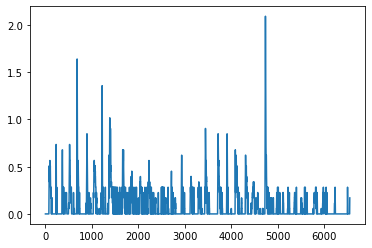

(6557, 5, 2)


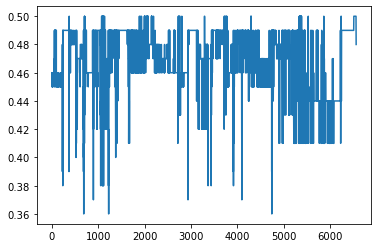

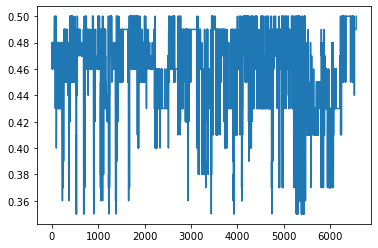

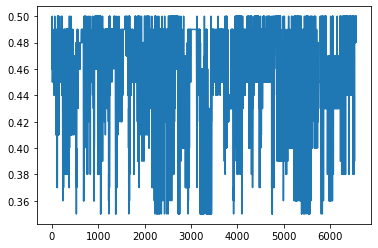

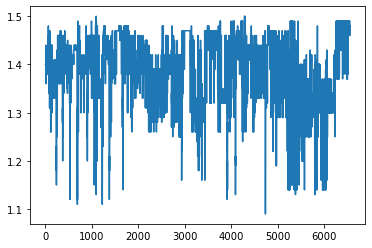

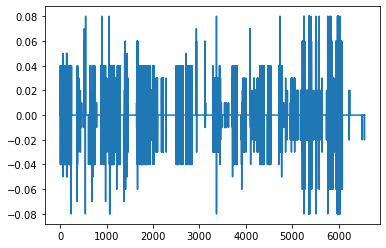

(6556, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-15/1/multi2-12152021113012-0000.avi
Opened video: True


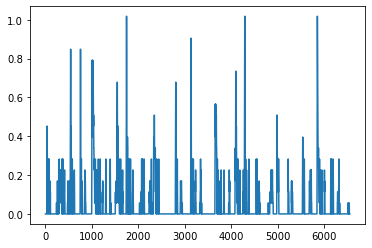

(6557, 5, 2)


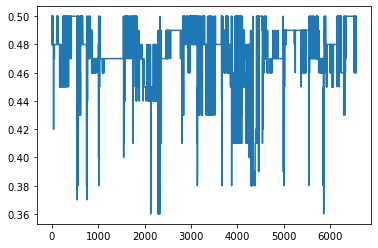

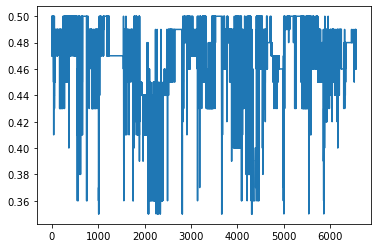

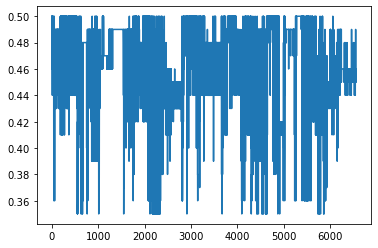

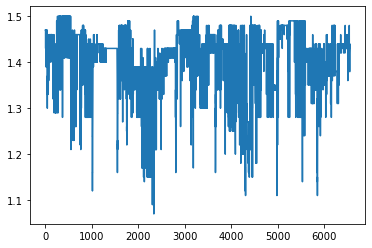

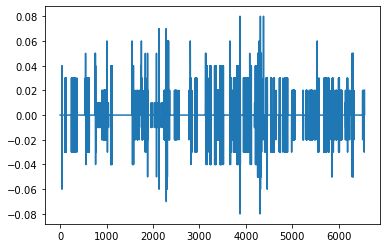

(6556, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-15/2/multi2-12152021114910-0000.avi
Opened video: True
CORRECTING!!!!!!!!!!!!!!! 0.4399999999999993 0
CORRECTING!!!!!!!!!!!!!!! 0.4399999999999993 1
CORRECTING!!!!!!!!!!!!!!! -0.44999999999999907 0
CORRECTING!!!!!!!!!!!!!!! -0.44999999999999907 1
CORRECTING!!!!!!!!!!!!!!! -0.44999999999999907 0
CORRECTING!!!!!!!!!!!!!!! -0.44999999999999907 1
CORRECTING!!!!!!!!!!!!!!! -0.44999999999999907 0
CORRECTING!!!!!!!!!!!!!!! -0.44999999999999907 1
CORRECTING!!!!!!!!!!!!!!! -0.44999999999999907 0
CORRECTING!!!!!!!!!!!!!!! -0.44999999999999907 1
CORRECTING!!!!!!!!!!!!!!! -0.44999999999999907 2
CORRE

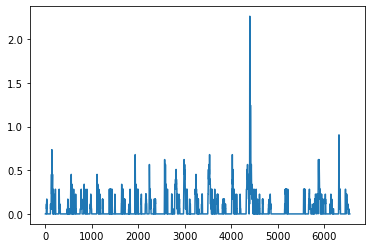

(6561, 5, 2)


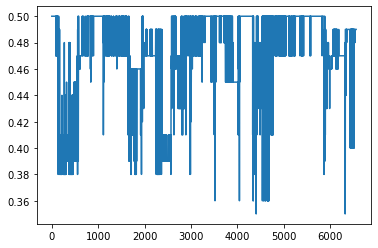

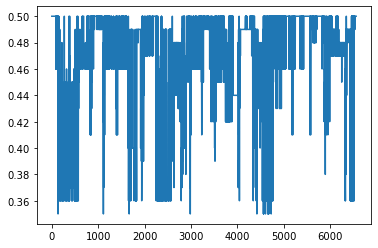

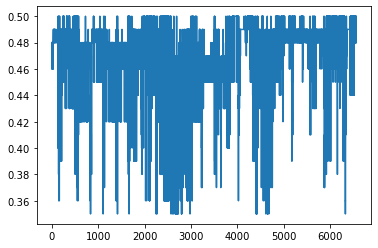

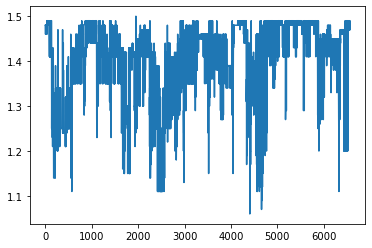

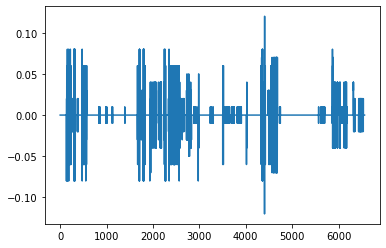

(6560, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-15/2/multi2-12152021115059-0000.avi
Opened video: True
CORRECTING!!!!!!!!!!!!!!! 0.4500000000000002 0
CORRECTING!!!!!!!!!!!!!!! 0.4500000000000002 1
CORRECTING!!!!!!!!!!!!!!! 0.4500000000000002 0
CORRECTING!!!!!!!!!!!!!!! 0.4500000000000002 1
CORRECTING!!!!!!!!!!!!!!! 0.4500000000000002 0
CORRECTING!!!!!!!!!!!!!!! 0.4500000000000002 1
CORRECTING!!!!!!!!!!!!!!! 0.4500000000000002 0
CORRECTING!!!!!!!!!!!!!!! 0.4500000000000002 0
CORRECTING!!!!!!!!!!!!!!! 0.4500000000000002 1
CORRECTING!!!!!!!!!!!!!!! 0.4500000000000002 2
CORRECTING!!!!!!!!!!!!!!! 0.4500000000000002 0
CORRECTING!!!!!!!!!!!!!

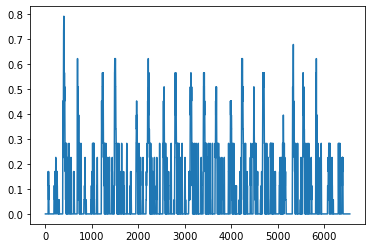

(6557, 5, 2)


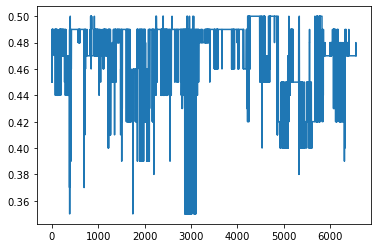

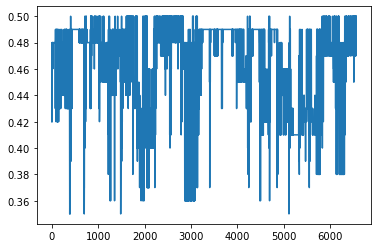

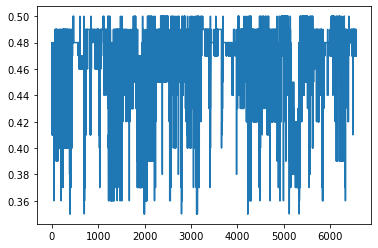

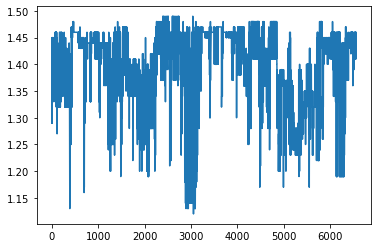

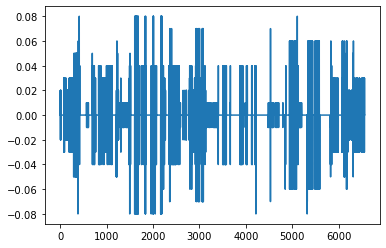

(6556, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-15/2/multi2-12152021115413-0000.avi
Opened video: True
CORRECTING!!!!!!!!!!!!!!! 0.4199999999999998 0
CORRECTING!!!!!!!!!!!!!!! 0.4799999999999995 1
CORRECTING!!!!!!!!!!!!!!! 0.4799999999999995 2
CORRECTING!!!!!!!!!!!!!!! 0.4799999999999995 0
CORRECTING!!!!!!!!!!!!!!! 0.4799999999999995 1
CORRECTING!!!!!!!!!!!!!!! -0.4599999999999995 0
CORRECTING!!!!!!!!!!!!!!! -0.4599999999999995 1


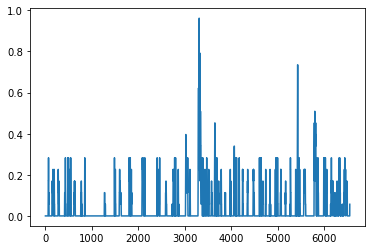

(6560, 5, 2)


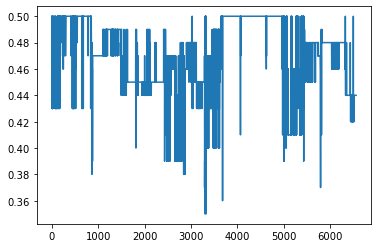

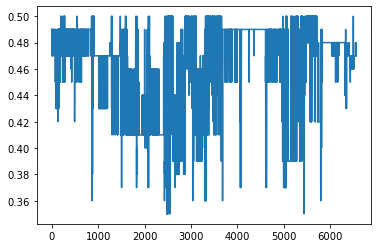

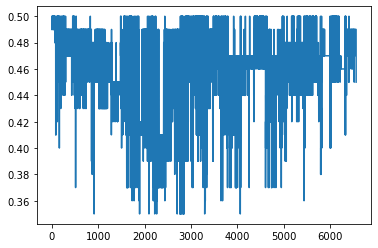

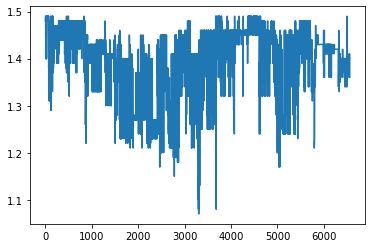

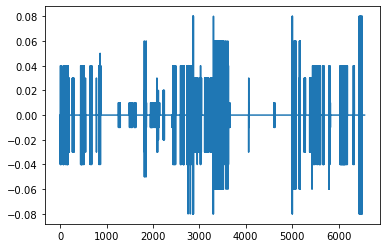

(6559, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-15/3/multi2-12152021121934-0000.avi
Opened video: True


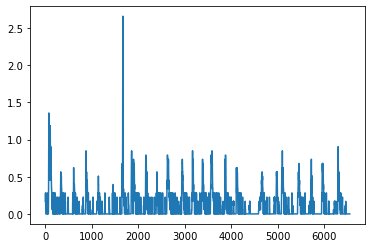

(6555, 5, 2)


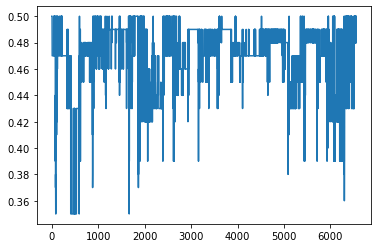

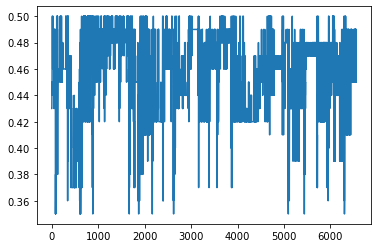

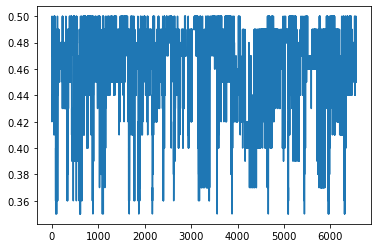

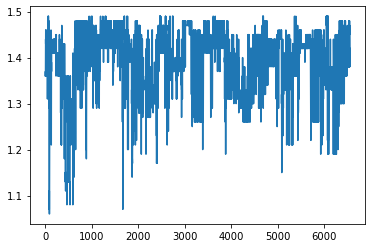

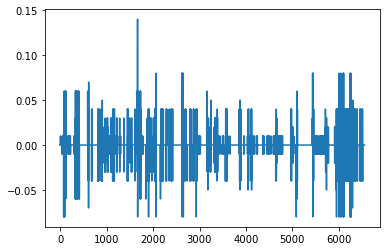

(6554, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-15/3/multi2-12152021122306-0000.avi
Opened video: True


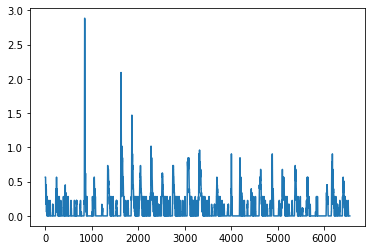

(6554, 5, 2)


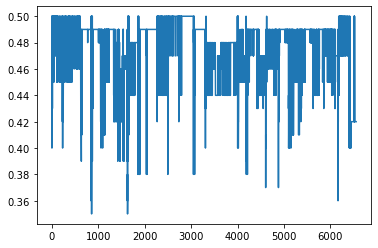

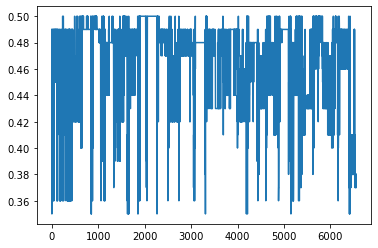

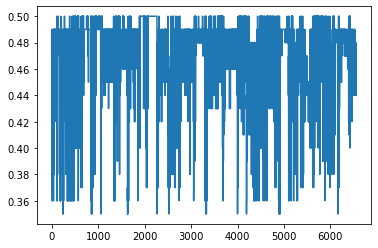

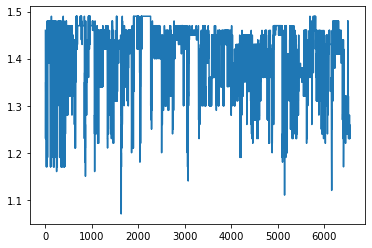

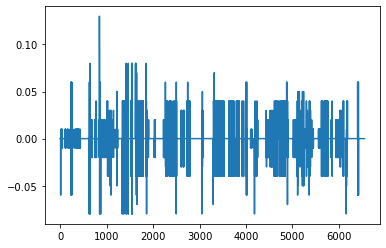

(6553, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-15/3/multi2-12152021122739-0000.avi
Opened video: True


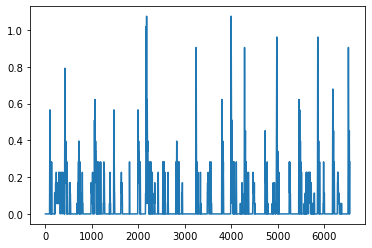

(6558, 5, 2)


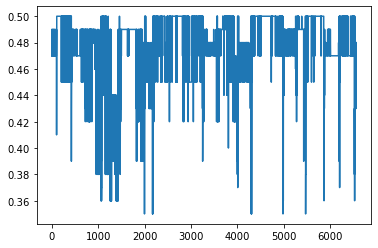

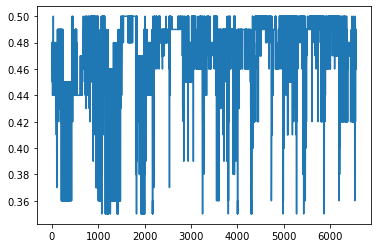

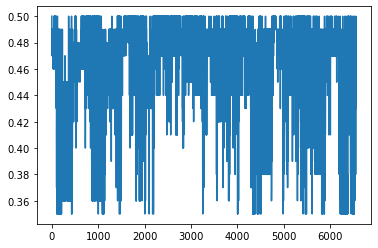

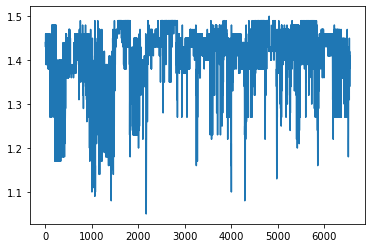

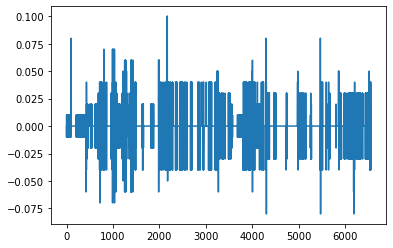

(6557, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-15/3/multi2-12152021123312-0000.avi
Opened video: True


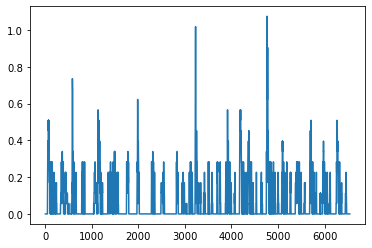

(6553, 5, 2)


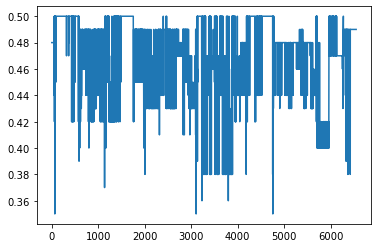

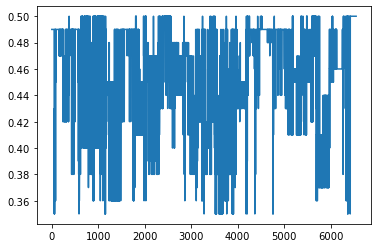

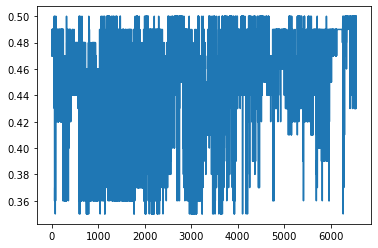

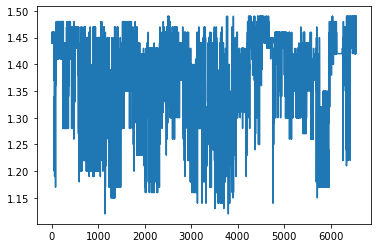

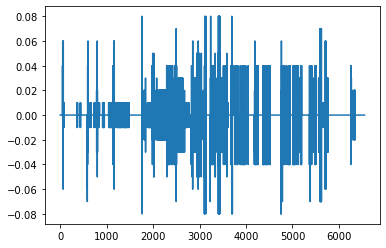

(6552, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-15/3/multi2-12152021123715-0000.avi
Opened video: True


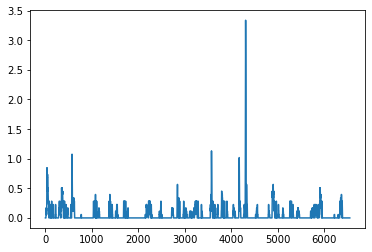

(6556, 5, 2)


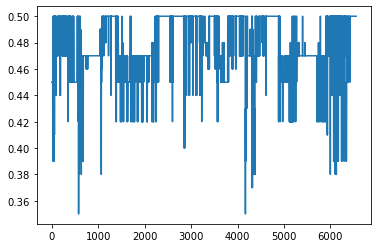

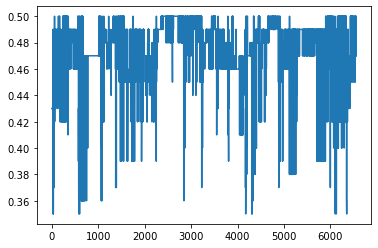

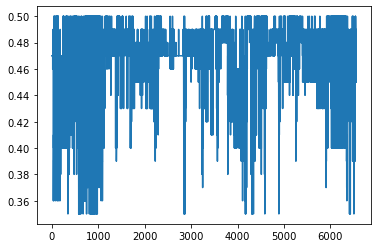

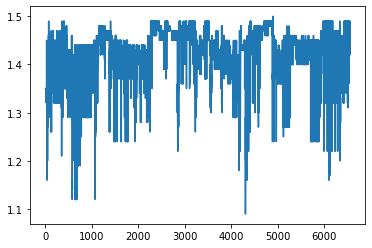

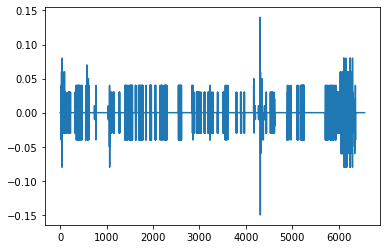

(6555, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-15/4/multi2-12152021125028-0000.avi
Opened video: True
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000034 0


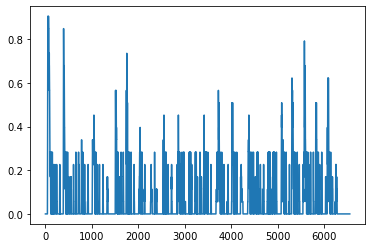

(6559, 5, 2)


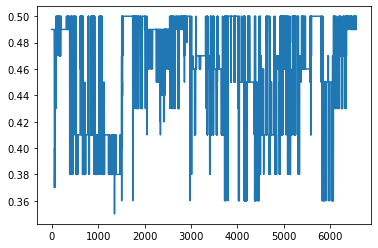

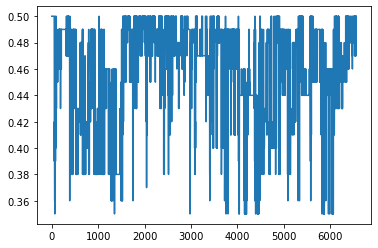

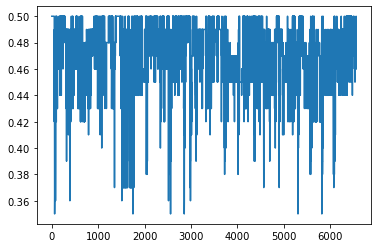

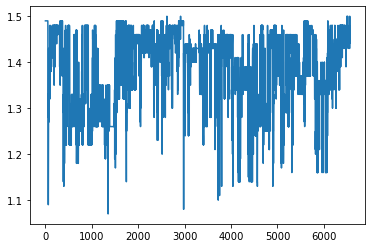

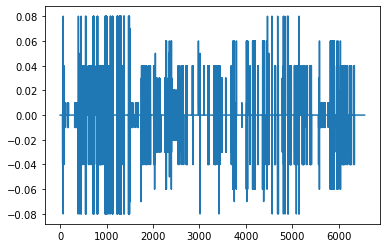

(6558, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-15/4/multi2-12152021125213-0000.avi
Opened video: True


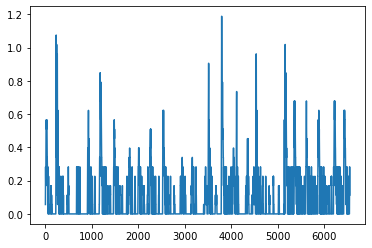

(6558, 5, 2)


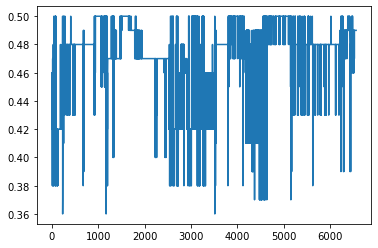

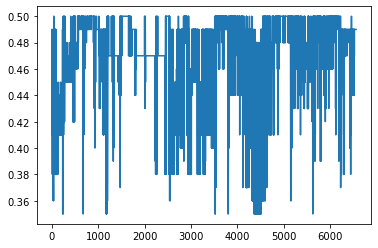

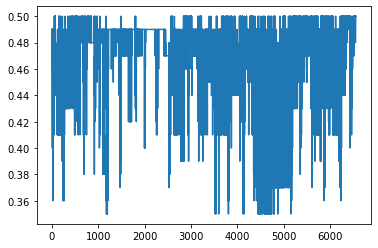

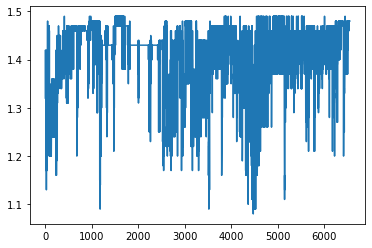

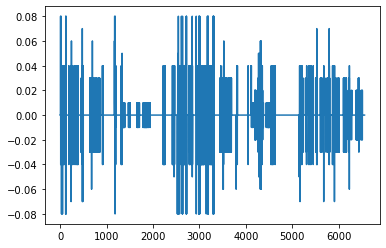

(6557, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-15/4/multi2-12152021125441-0000.avi
Opened video: True
CORRECTING!!!!!!!!!!!!!!! 0.46999999999999986 0


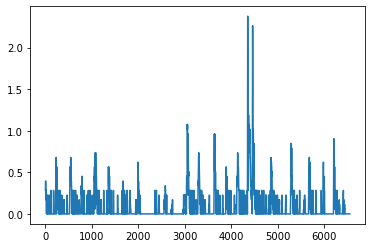

(6559, 5, 2)


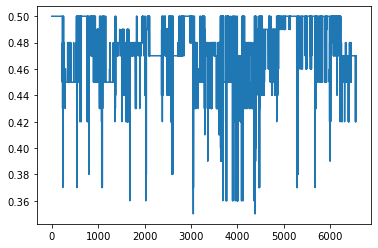

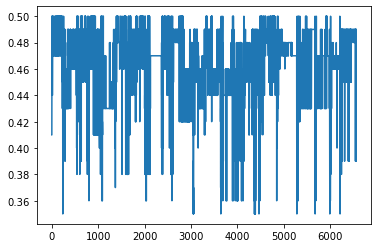

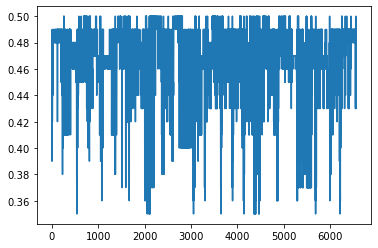

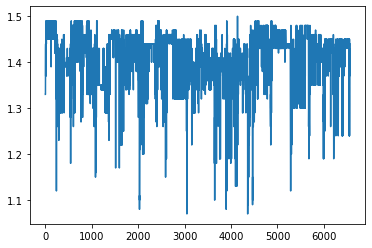

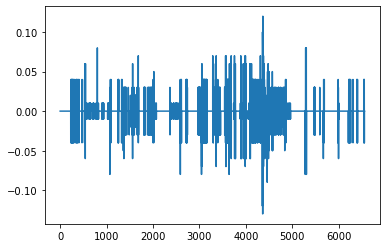

(6558, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-15/4/multi2-12152021130012-0000.avi
Opened video: True
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000006 0


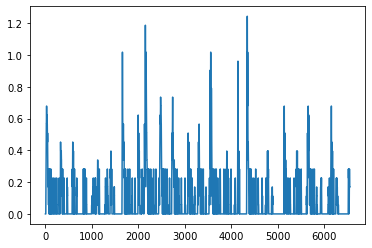

(6560, 5, 2)


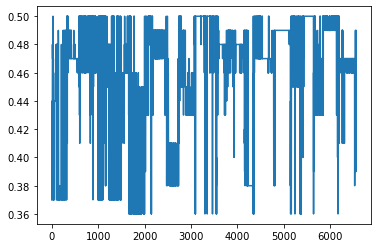

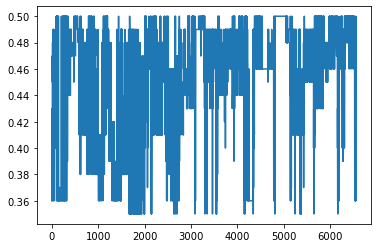

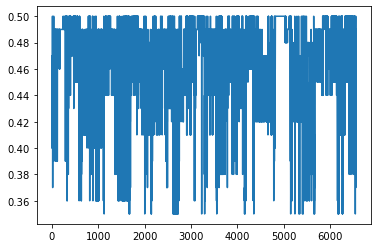

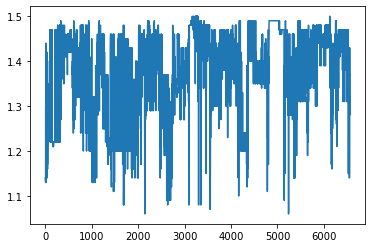

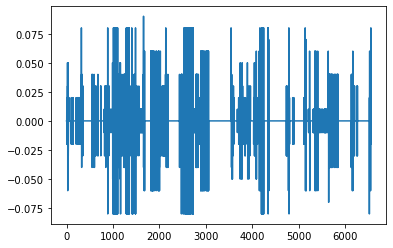

(6559, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-15/4/multi2-12152021130202-0000.avi
Opened video: True


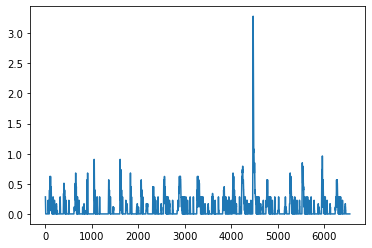

(6559, 5, 2)


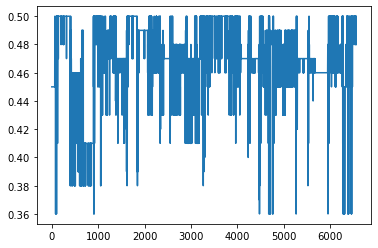

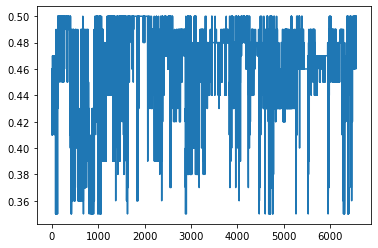

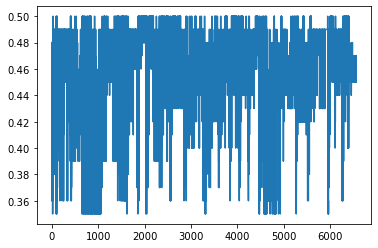

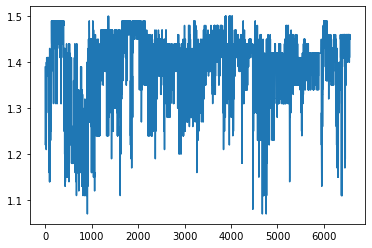

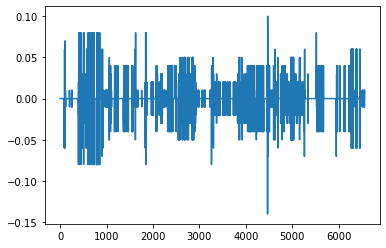

(6558, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-15/4/multi2-12152021130850-0000.avi
Opened video: True
CORRECTING!!!!!!!!!!!!!!! -0.4300000000000005 0


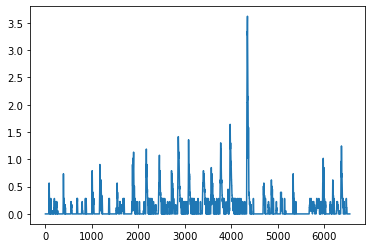

(6560, 5, 2)


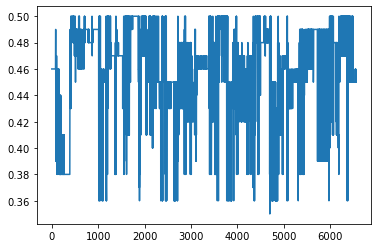

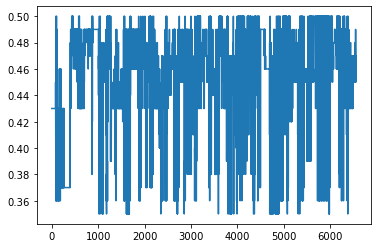

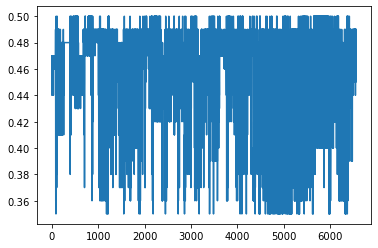

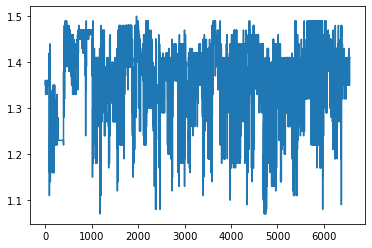

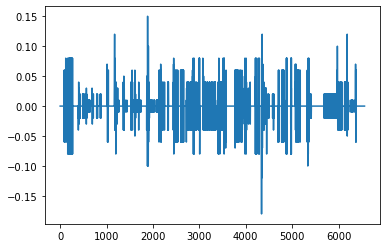

(6559, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-15/4/multi2-12152021131019-0000.avi
Opened video: True


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\sit

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\sit

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\sit

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\sit

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\sit

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\sit

CORRECTING!!!!!!!!!!!!!!! 0.2600000000000002 0


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


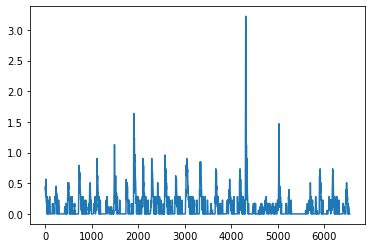

(6556, 5, 2)


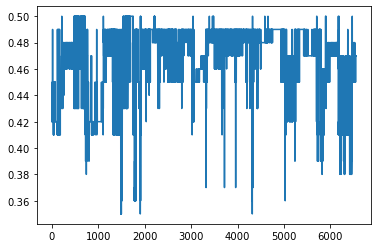

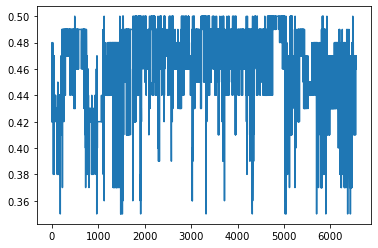

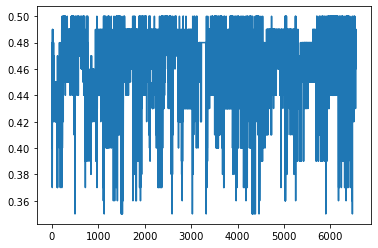

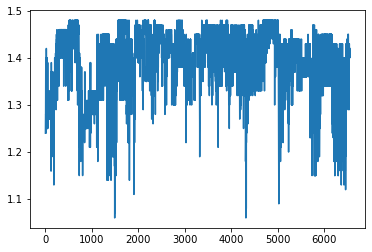

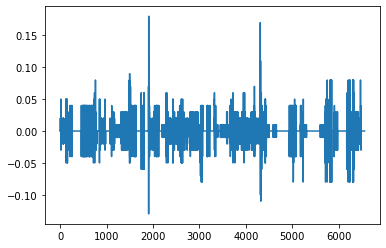

(6555, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-15/5/multi2-12152021133139-0000.avi
Opened video: True


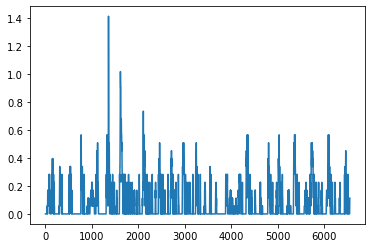

(6556, 5, 2)


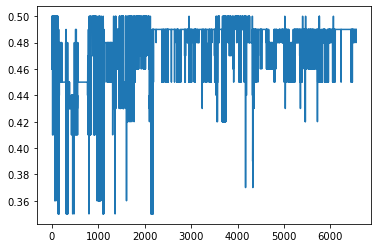

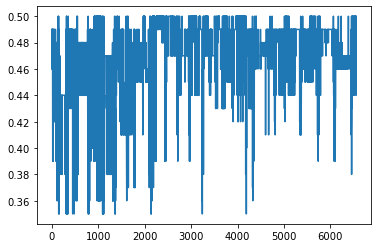

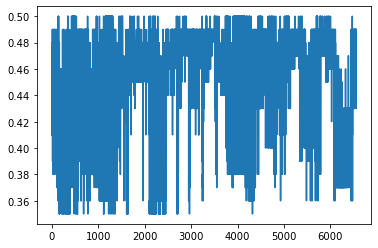

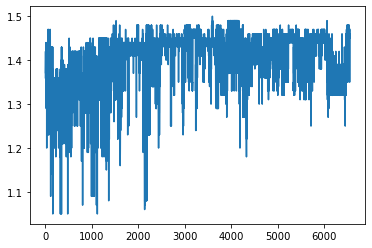

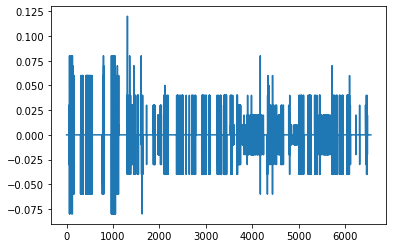

(6555, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-15/5/multi2-12152021133545-0000.avi
Opened video: True


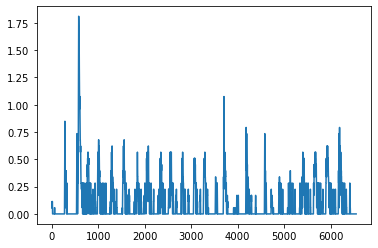

(6558, 5, 2)


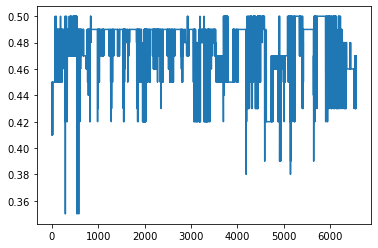

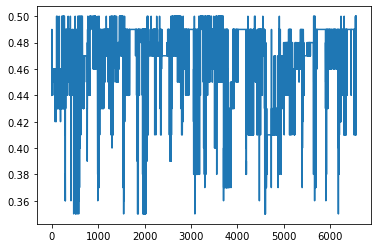

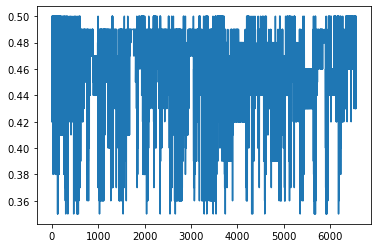

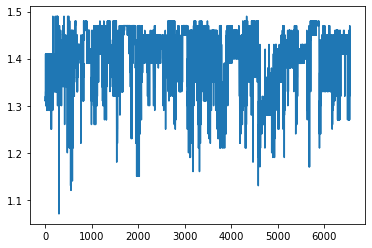

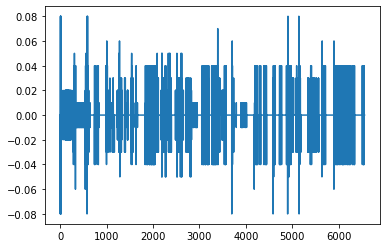

(6557, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-15/5/multi2-12152021133710-0000.avi
Opened video: True
CORRECTING!!!!!!!!!!!!!!! 0.39999999999999963 0
CORRECTING!!!!!!!!!!!!!!! 0.39999999999999963 0
CORRECTING!!!!!!!!!!!!!!! 0.36999999999999955 0
CORRECTING!!!!!!!!!!!!!!! 0.39999999999999963 0
CORRECTING!!!!!!!!!!!!!!! 0.39999999999999963 0
CORRECTING!!!!!!!!!!!!!!! 0.36999999999999955 0
CORRECTING!!!!!!!!!!!!!!! 0.36999999999999955 0
CORRECTING!!!!!!!!!!!!!!! 0.36999999999999955 0
CORRECTING!!!!!!!!!!!!!!! 0.36999999999999955 0
CORRECTING!!!!!!!!!!!!!!! 0.36999999999999955 0
CORRECTING!!!!!!!!!!!!!!! 0.36999999999999955 0
CORRECTING!!

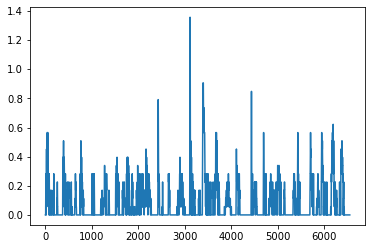

(6558, 5, 2)


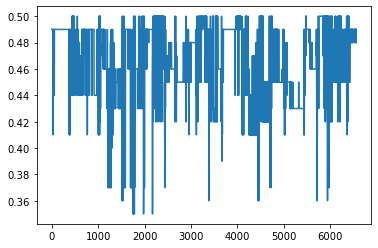

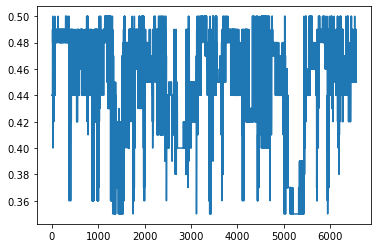

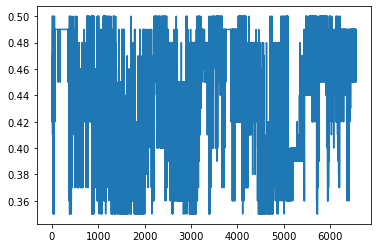

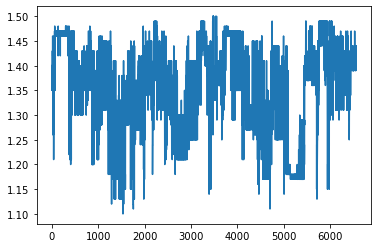

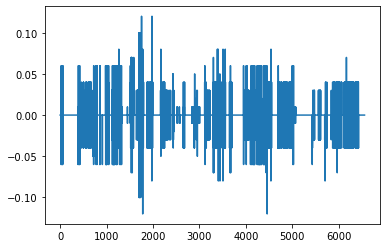

(6557, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-15/7/multi2-12152021143907-0000.avi
Opened video: True
CORRECTING!!!!!!!!!!!!!!! -0.32000000000000073 0
CORRECTING!!!!!!!!!!!!!!! -0.37000000000000033 0


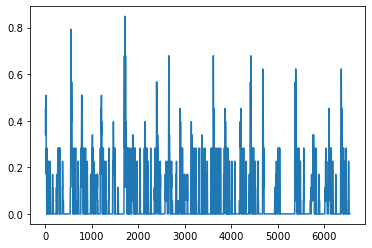

(6558, 5, 2)


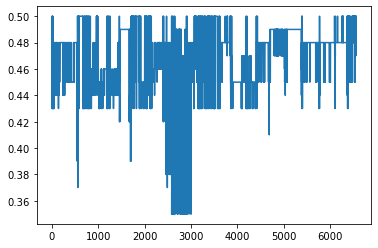

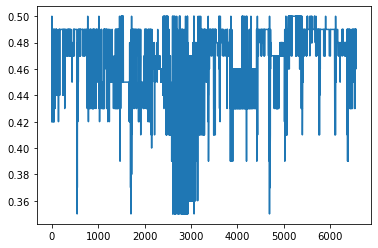

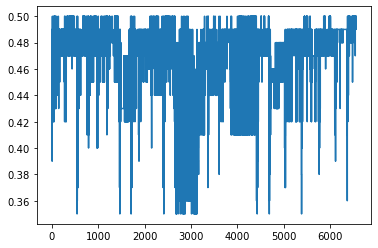

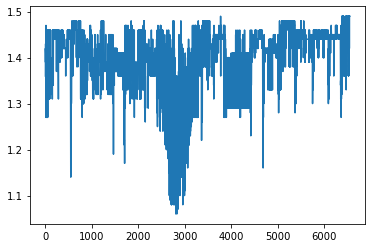

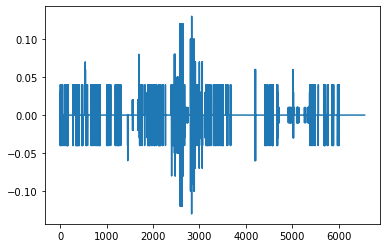

(6557, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-15/8/multi2-12152021151406-0000.avi
Opened video: True


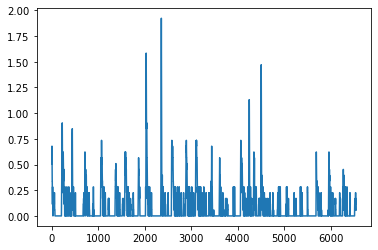

(6556, 5, 2)


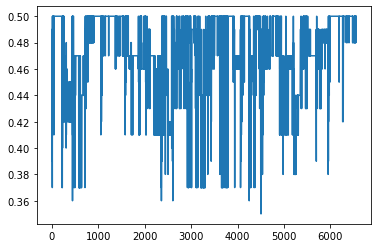

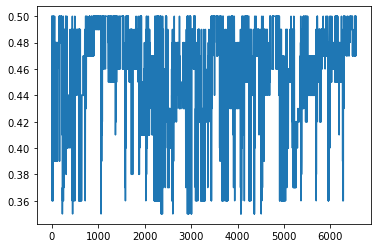

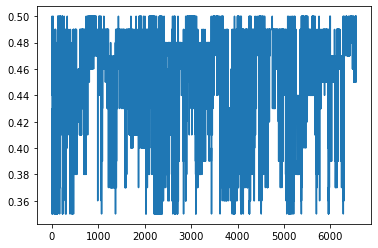

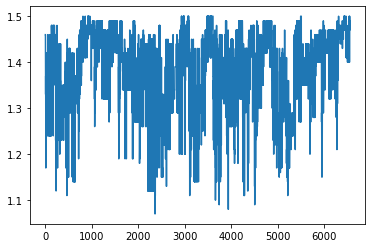

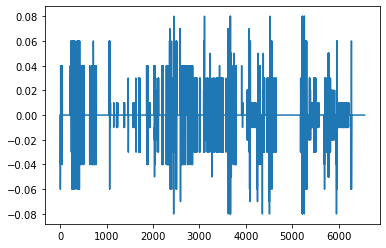

(6555, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-15/8/multi2-12152021151805-0000.avi
Opened video: True


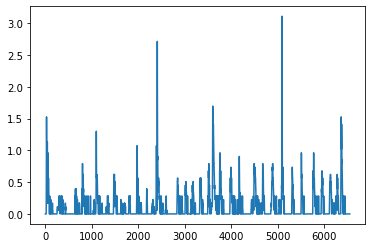

(6558, 5, 2)


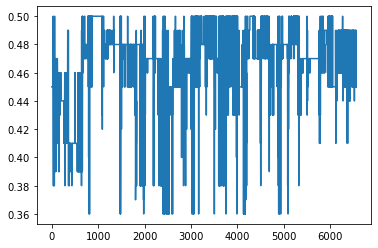

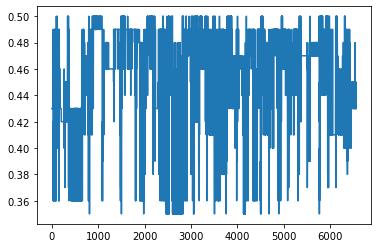

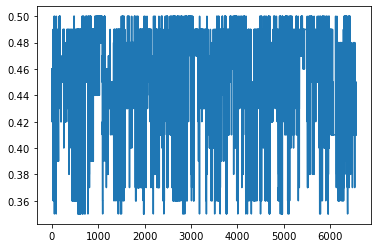

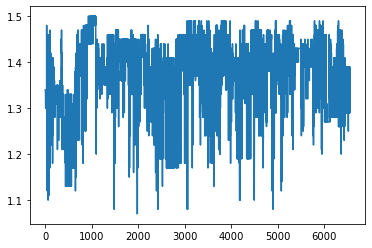

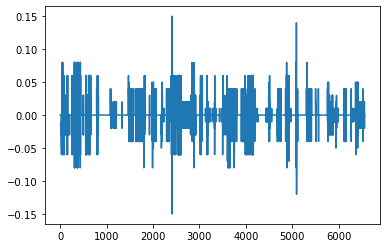

(6557, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-15/8/multi2-12152021152023-0000.avi
Opened video: True


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\sit

CORRECTING!!!!!!!!!!!!!!! 0.43000000000000016 0
CORRECTING!!!!!!!!!!!!!!! 0.43000000000000016 1
CORRECTING!!!!!!!!!!!!!!! 0.43000000000000016 2
CORRECTING!!!!!!!!!!!!!!! 0.43000000000000016 3
CORRECTING!!!!!!!!!!!!!!! 0.43000000000000016 4
CORRECTING!!!!!!!!!!!!!!! 0.43000000000000016 5
CORRECTING!!!!!!!!!!!!!!! 0.43000000000000016 6
CORRECTING!!!!!!!!!!!!!!! 0.43000000000000016 7
CORRECTING!!!!!!!!!!!!!!! 0.43000000000000016 8
CORRECTING!!!!!!!!!!!!!!! 0.43000000000000016 9
CORRECTING!!!!!!!!!!!!!!! 0.43000000000000016 10
CORRECTING!!!!!!!!!!!!!!! 0.43000000000000016 11
CORRECTING!!!!!!!!!!!!!!! 0.43000000000000016 12
CORRECTING!!!!!!!!!!!!!!! 0.43000000000000016 13
CORRECTING!!!!!!!!!!!!!!! 0.43000000000000016 14
CORRECTING!!!!!!!!!!!!!!! 0.43000000000000016 15
CORRECTING!!!!!!!!!!!!!!! 0.43000000000000016 16
CORRECTING!!!!!!!!!!!!!!! 0.43000000000000016 17
CORRECTING!!!!!!!!!!!!!!! -0.47999999999999976 18
CORRECTING!!!!!!!!!!!!!!! -0.47999999999999976 19
CORRECTING!!!!!!!!!!!!!!! -0

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.37 1
CORRECTING!!!!!!!!!!!!!!! 0.37 2
CORRECTING!!!!!!!!!!!!!!! 0.37 3
CORRECTING!!!!!!!!!!!!!!! 0.37 4
CORRECTING!!!!!!!!!!!!!!! 0.37 5
CORRECTING!!!!!!!!!!!!!!! 0.37 6
CORRECTING!!!!!!!!!!!!!!! 0.37 7
CORRECTING!!!!!!!!!!!!!!! 0.37 8
CORRECTING!!!!!!!!!!!!!!! 0.37 9
CORRECTING!!!!!!!!!!!!!!! 0.37 10
CORRECTING!!!!!!!!!!!!!!! 0.37 11
CORRECTING!!!!!!!!!!!!!!! 0.37 12
CORRECTING!!!!!!!!!!!!!!! 0.37 13
CORRECTING!!!!!!!!!!!!!!! 0.37 14
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 15
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 16
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 17
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 18
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 19
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 20
CORRECTING!!!!!!!!!!!!!!! 0.5 21
CORRECTING!!!!!!!!!!!!!!! 0.5 22
CORRECTING!!!!!!!!!!!!!!! 0.5 23
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 24
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 0


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 1
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 2
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 3
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 4
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 5
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 6
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 7
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 8
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 9
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 10
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 11
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 12
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 13
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 14
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 15
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 16
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 17
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 18
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 19
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 20
CORRECTING!!!!!!!!!!!!!!! 0.4

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 0
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 1
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 2
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 3
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 4
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 5
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 6
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 7
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 8
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 9
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 10
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 11
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 12
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 13
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 14
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 15
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 16
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 17
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 18
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 19
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 20
CO

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 0
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 1
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 2
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 3
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 4
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 5
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 6
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 7
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 8
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 9
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 10
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 11
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 12
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 13
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 14
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 15
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 16
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 17
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 18
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 19


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! -0.4700000000000002 0
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000002 1
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000002 2
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000002 3
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000002 4
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000002 5
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000002 6
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000002 7
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000002 8
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000002 9
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000002 10
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000002 11
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000002 12
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000002 13
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000002 14
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000002 15
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000002 16
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000002 17
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000002 18
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000002 19
CORRECTING!!!!!!!!!!!!!!! -0.4

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\sit

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\sit

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 0
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 1
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 2
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 3
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 4
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 5
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 6
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 7
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 8
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 9
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 10
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 11
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 12
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 13
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 14


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\sit

CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 0
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 1
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 2
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 3
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 4
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 5
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 6
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 7
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 8
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 9
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 10
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 11
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 12


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\sit

CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 0
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 1
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 2
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 3
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 4
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 5
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 6
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 7
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 8
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 9
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 10


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\sit

CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 0
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 1
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 2
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 3
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 4
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 5
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 6
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 7
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 8
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 9
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 10
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 11


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 0
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 1
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 2
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 3
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 4
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 5
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 6
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 7
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 8
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 9
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 10
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 11
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 12
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 13
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 14
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 15
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 16
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 17
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 0
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 1


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 2
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 3
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 4
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 5
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 6
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 7
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 8
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 9
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 10
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 11
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 0


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 1
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 2
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 3
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 4
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 5
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 6
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 7
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 8
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 9
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 10
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 11


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 0
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 1
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 2
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 3
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 4
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 5
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 6
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 7
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 8
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 9
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 10
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 11


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 0
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 1
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 2
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 3
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 4
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 5
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 6
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 7
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 8
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 9
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 10
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 11


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 0
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 1
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 2
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 3
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 4
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 5
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 6
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 7
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 8
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 9
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 10
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 11


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 0
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 1
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 2
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 3
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 4
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 5
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 6
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 7
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 8
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 9
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 10
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 11
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 12
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 13
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 14
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 15
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 16
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 17
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 0


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 1
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 2
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 3
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 4
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 5
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 6
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 7
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 8
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 9
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 10
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 11
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 12
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 13
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 14
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 15
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 16
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 17


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 0
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 1
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 2
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 3
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 4
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 5
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 6
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 7
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 8
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 9
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 10
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 11


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 0
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 1
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 2
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 3
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 4
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 5
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 6
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 7
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 8
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 9
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 10
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 11
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 12
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 13
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 14
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 15
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 16
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 17
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 0
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 1


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 2
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 3
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 4
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 5
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 6
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 7
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 8
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 9


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 0
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 1
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 2
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 3
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 4
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 5
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 6
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 7
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 8
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 9
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 10
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 11
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 12
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 13
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 14
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 15
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 16
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 17
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 0


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 1
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 2
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 3
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 4
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 5
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 6
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 7
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 8
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 9
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 10
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 11
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 12
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 13
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 14
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 15
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 16
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 17


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 0
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 1
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 2
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 3
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 4
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 5
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 6
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 7
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 8
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 9
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 10
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 0


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 1
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 2
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 3
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 4
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 5
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 6
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 7
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 8
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 9
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 10
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 11
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 12
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 13
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 14
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 15
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 16
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 17


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 0
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 1
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 2
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 3
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 4
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 5
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 6
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 7
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 8
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 9
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 0


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 1
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 2
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 3
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 4
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 5
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 6
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 7
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 8
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 9
CORRECTING!!!!!!!!!!!!!!! 0.43999999999999995 10
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 0


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 1
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 2
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 3
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 4
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 5
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 6
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 7
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 8
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 9
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 10
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 11
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 12
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 13
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 14
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 15
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 16


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 17
CORRECTING!!!!!!!!!!!!!!! 0.47000000000000075 0
CORRECTING!!!!!!!!!!!!!!! 0.47000000000000075 1
CORRECTING!!!!!!!!!!!!!!! 0.47000000000000075 2
CORRECTING!!!!!!!!!!!!!!! 0.47000000000000075 3
CORRECTING!!!!!!!!!!!!!!! 0.47000000000000075 4
CORRECTING!!!!!!!!!!!!!!! 0.47000000000000075 5
CORRECTING!!!!!!!!!!!!!!! 0.47000000000000075 6
CORRECTING!!!!!!!!!!!!!!! 0.47000000000000075 7
CORRECTING!!!!!!!!!!!!!!! 0.47000000000000075 8
CORRECTING!!!!!!!!!!!!!!! 0.47000000000000075 9
CORRECTING!!!!!!!!!!!!!!! 0.47000000000000075 10
CORRECTING!!!!!!!!!!!!!!! 0.47000000000000075 11
CORRECTING!!!!!!!!!!!!!!! 0.47000000000000075 12
CORRECTING!!!!!!!!!!!!!!! 0.47000000000000075 13
CORRECTING!!!!!!!!!!!!!!! 0.47000000000000075 14
CORRECTING!!!!!!!!!!!!!!! 0.47000000000000075 15


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 0
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 1
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 2
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 3
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 4
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 5
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 6
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 7
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 8
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 9
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 10
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 11
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 12
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 13
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 14
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 15
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 16
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 17
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 18
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 19
CORRECTING!!!!!!!!!!!!!!! 0.38

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 0
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 1
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 2
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 3
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 4
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 5
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 6
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 7
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 8
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 9
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 10
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 11
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 12
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 13
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 14
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 15
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 16
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 17
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 0


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 1
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 2
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 3
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 4
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 5
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 6
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 7
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 8
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 9
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 10
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 11
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 12
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 13
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 14
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 15
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 16
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 17
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 18
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 19
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 20
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 21
C

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 0
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 1
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 2
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 3
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 4
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 5
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 6
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 7
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 8
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 9
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 10
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 11
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 12
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 13
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 14
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 15
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 16
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 17
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 18
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 19
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 20
CO

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 1
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 2
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 3
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 4
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 5
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 6
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 7
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 8
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 9
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 10
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 11
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 12
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 13
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 14
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 15
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 16
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 17
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 18
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 19
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 20
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 21
C

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 1
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 2
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 3
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 4
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 5
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 6
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 7
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 8
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999954 9
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 10
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 11
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 12
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 13
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 14
CORRECTING!!!!!!!!!!!!!!! 0.5 15
CORRECTING!!!!!!!!!!!!!!! 0.5 16
CORRECTING!!!!!!!!!!!!!!! 0.5 17


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 0
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 1
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 2
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 3
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 4
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 5
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 6
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 7
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 8
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 9
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 10
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 11
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 12
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 13
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 14
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 15
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 16
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 17
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 18
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 19
CORRECTING!!!!!!!!!!!!!!! 0.38

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 0
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 1
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 2
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 3
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 4
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 5
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 6
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 7
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 8
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 9
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 10
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 11
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 12
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 13
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 0


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 1
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 2
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 3
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 4
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 5
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 6
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 7
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 8
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 9
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 10
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 11
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 12
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 13
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 14
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 15
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 16
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 17
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 18
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 19
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 20
CORRECTING!!!!!!!!!!!!!!! 0.3

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 0
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 1
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 2
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 3
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 4
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 5
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 6
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 7
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 8
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 9
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 10
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 11
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 12
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 13
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 14
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 15
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 16
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 17
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 18
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 19
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 20
CO

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 0
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 1
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 2
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 3
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 4
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 5
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 6
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 7
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 8
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 9
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 10
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 11
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 12
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 13
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 14
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 15
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 16
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 17
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 18
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 19
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 20
CO

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 0
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 1
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 2
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 3
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 4
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 5
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 6
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 7
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 8
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 9
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 10
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 11
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 12
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 13
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 14
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 15
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 16
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 17
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 18
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 19
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 20
CO

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 0
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 1
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 2
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 3
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 4
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 5
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 6
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 7
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 8
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 9
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 10
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 11
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 12
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 13
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 14
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 15
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 16
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 17
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 18
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 19
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 20
CO

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 1
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 2
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 3
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 4
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 5
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 6
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 7
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 8
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 9
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 10
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 11
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 12
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 13
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 14
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 15
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 16
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 17
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 18
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 19
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 20
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 21
C

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 0
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 1
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 2
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 3
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 4
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 5
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 6
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 7
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 8
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 9
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 10
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 11
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 12
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 13
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 14
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 15
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 16
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 17
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 18
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 19


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 0
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 1
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 2
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 3
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 4
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 5
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 6
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 7
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 8
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 9
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 10
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 11
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 12
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 13
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 14
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 15
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 16
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 17
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 18
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 19
CORRECTING!!!!!!!!!!!!!!! 0.38

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 1
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 2
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 3
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 4
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 5
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 6
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 7
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 8
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 9
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 10
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 11
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 12
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 13
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 14
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 0
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 1


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 2
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 3
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 4
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 5
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 6
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 7
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 8
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 9
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 10
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 11
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 12
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 13
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 14


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 0
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 1
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 2
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 3
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 4
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 5
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 6
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 7
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 8
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 9
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 10
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 11
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 12


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 0
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 1
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 2
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 3
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 4
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 5
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 6
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 7
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 8
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 9
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 10
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 11
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 12
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 13
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 14
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 15
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 16
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 17
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 18
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 19
CORRECTING!!!!!!!!!!!!!!! 0.38

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 0
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 1
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 2
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 3
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 4
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 5
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 6
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 7
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 8
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 9
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 10
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 11
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 12
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 13
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 14
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 15
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 16
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 17
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 18
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 19
CORRECTING!!!!!!!!!!!!!!! 0.38

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 0
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 1
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 2
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 3
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 4
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 5
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 6
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 7
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 8
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 9
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 10
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 11
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 12
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 13
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 14
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 15
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 16
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 17
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 18
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 19
CORRECTING!!!!!!!!!!!!!!! 0.38

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 0
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 1
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 2
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 3
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 4
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 5
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 6
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 7
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 8
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 9
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 10
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 11
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 12
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 13
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 14
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 15
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 16
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 17
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 18
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 19
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 20
CO

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 0
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 1
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 2
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 3
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 4
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 5
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 6
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 7
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 8
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 9
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 10
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 11
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 12
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 13
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 14
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 15
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 16
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 17
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 18
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 19
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 20
CO

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 0
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 1
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 2
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 3
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 4
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 5
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 6
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 7
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 8
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 9
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 10
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 11
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 12
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 13
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 14
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 15
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 16
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 17
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 18
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 19
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 20
CO

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 1
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 2
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 3
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 4
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 5
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 6
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 7
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 8
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 9
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 10
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 11
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 12
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 13
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 14
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 15
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 16
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 17
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 18
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 19
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 20
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 21

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.37 0
CORRECTING!!!!!!!!!!!!!!! 0.37 1
CORRECTING!!!!!!!!!!!!!!! 0.37 2
CORRECTING!!!!!!!!!!!!!!! 0.37 3
CORRECTING!!!!!!!!!!!!!!! 0.37 4
CORRECTING!!!!!!!!!!!!!!! 0.37 5
CORRECTING!!!!!!!!!!!!!!! 0.37 6
CORRECTING!!!!!!!!!!!!!!! 0.37 7
CORRECTING!!!!!!!!!!!!!!! 0.37 8
CORRECTING!!!!!!!!!!!!!!! 0.37 9
CORRECTING!!!!!!!!!!!!!!! 0.37 10
CORRECTING!!!!!!!!!!!!!!! 0.37 11
CORRECTING!!!!!!!!!!!!!!! 0.37 12
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 13
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 14
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 15
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 16
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 17
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 18
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 19
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 20
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 21
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 22
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 23
CORRECTING!!!!!!!!!!!!!!! 0.42000000

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.37 1
CORRECTING!!!!!!!!!!!!!!! 0.37 2
CORRECTING!!!!!!!!!!!!!!! 0.37 3
CORRECTING!!!!!!!!!!!!!!! 0.37 4
CORRECTING!!!!!!!!!!!!!!! 0.37 5
CORRECTING!!!!!!!!!!!!!!! 0.37 6
CORRECTING!!!!!!!!!!!!!!! 0.37 7
CORRECTING!!!!!!!!!!!!!!! 0.37 8
CORRECTING!!!!!!!!!!!!!!! 0.37 9
CORRECTING!!!!!!!!!!!!!!! 0.37 10
CORRECTING!!!!!!!!!!!!!!! 0.37 11
CORRECTING!!!!!!!!!!!!!!! 0.37 12
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 13
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 14
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 15
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 16
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 17
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 18
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 19
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 20
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 21
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 22


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 0
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 1
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 2
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 3
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 4
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 5
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 6
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 7
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 8
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 9
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 10
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 11
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 12
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 13
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 14
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 15
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 16
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 17
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 18
CORRECTING!!!!!!!!!!!!!!! 0.4300000000000005 19
CORRECTING!!!!!!!!!!!!!!! 0.430

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 0
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 1
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 2
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 3
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 4
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 5
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 6
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 7
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 8
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 9
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 10
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 11
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 12
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 13
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 14
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 15
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 16
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 17
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 18
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 19
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 20
CO

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 0
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 1
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 2
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 3
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 4
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 5
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 6
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 7
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 8
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 9
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 10
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 11
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 12
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 13
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 14
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 15
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 16
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 17
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 18
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 19
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 20
C

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 0
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 1
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 2
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 3
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 4
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 5
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 6
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 7
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 8
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 9
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 10
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 11
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 12
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 13
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 14
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 15
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 16
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 17
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 18
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 19
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 20
CO

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 1
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 2
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 3
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 4
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 5
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 6
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 7
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 8
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 9
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 10
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 11
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 12
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 13
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 14
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 15
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 16
CORRECTING!!!!!!!!!!!!!!! 0.4300000000000005 17
CORRECTING!!!!!!!!!!!!!!! 0.4300000000000005 18
CORRECTING!!!!!!!!!!!!!!! 0.4300000000000005 19
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 20
CORRECTING!!!!!!!!!!!!!!! 0.3800

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.37 1
CORRECTING!!!!!!!!!!!!!!! 0.37 2
CORRECTING!!!!!!!!!!!!!!! 0.37 3
CORRECTING!!!!!!!!!!!!!!! 0.37 4
CORRECTING!!!!!!!!!!!!!!! 0.37 5
CORRECTING!!!!!!!!!!!!!!! 0.37 6
CORRECTING!!!!!!!!!!!!!!! 0.37 7
CORRECTING!!!!!!!!!!!!!!! 0.37 8
CORRECTING!!!!!!!!!!!!!!! 0.37 9
CORRECTING!!!!!!!!!!!!!!! 0.37 10
CORRECTING!!!!!!!!!!!!!!! 0.37 11
CORRECTING!!!!!!!!!!!!!!! 0.37 12
CORRECTING!!!!!!!!!!!!!!! 0.37 13
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 14
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 15
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 16
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 17
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 18
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 19
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 20
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 21
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 22
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 23
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 24
CORRECTING!!!!!!!!!!!!!!! 0.47000

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.37 0
CORRECTING!!!!!!!!!!!!!!! 0.37 1
CORRECTING!!!!!!!!!!!!!!! 0.37 2
CORRECTING!!!!!!!!!!!!!!! 0.37 3
CORRECTING!!!!!!!!!!!!!!! 0.37 4
CORRECTING!!!!!!!!!!!!!!! 0.37 5
CORRECTING!!!!!!!!!!!!!!! 0.37 6
CORRECTING!!!!!!!!!!!!!!! 0.37 7
CORRECTING!!!!!!!!!!!!!!! 0.37 8
CORRECTING!!!!!!!!!!!!!!! 0.37 9
CORRECTING!!!!!!!!!!!!!!! 0.37 10
CORRECTING!!!!!!!!!!!!!!! 0.37 11
CORRECTING!!!!!!!!!!!!!!! 0.37 12
CORRECTING!!!!!!!!!!!!!!! 0.37 13
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 14
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 15
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 16
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 17
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 18
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 19
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 20
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 21
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 22
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 23


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 0
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 1
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 2
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 3
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 4
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 5
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 6
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 7
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 8
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 9
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 10
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 11
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 12
CORRECTING!!!!!!!!!!!!!!! 0.5 13
CORRECTING!!!!!!!!!!!!!!! 0.5 14
CORRECTING!!!!!!!!!!!!!!! 0.5 15
CORRECTING!!!!!!!!!!!!!!! 0.5 16
CORRECTING!!!!!!!!!!!!!!! 0.5 17
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 18
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 19
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 20
CORRECTING!!!!!!!!!!!!!!! 0.4300000000000005 21
CORRECTING!!!

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 1
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 2
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 3
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 4
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 5
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 6
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 7
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 8
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 9
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 10
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 11
CORRECTING!!!!!!!!!!!!!!! 0.5 12
CORRECTING!!!!!!!!!!!!!!! 0.5 13
CORRECTING!!!!!!!!!!!!!!! 0.5 14
CORRECTING!!!!!!!!!!!!!!! 0.5 15
CORRECTING!!!!!!!!!!!!!!! 0.5 16
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 17
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 18
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 19
CORRECTING!!!!!!!!!!!!!!! 0.4300000000000005 20
CORRECTING!!!!!!!!!!!!!!! 0.4300000000000005 21


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 0
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 1
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 2
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 3
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 4
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 5
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 6
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 7
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 8
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 9
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 10
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 11
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 12
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 13
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 14
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 15
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 16
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 17
CORRECTING!!!!!!!!!!!!!!! 0.4300000000000005 18
CORRECTING!!!!!!!!!!!!!!! 0.5 19
CORRECTING!!!!!!!!!!!!!!! 0.5 20
CORRECTING!!!!

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 0
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 1
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 2
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 3
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 4
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 5
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 6
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 7
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 8
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 9
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 10
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 11
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 12
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 13
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 14
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 15
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 16
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 17
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 18
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 19
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 20
CO

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 0
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 1
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 2
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 3
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 4
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 5
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 6
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 7
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 8
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 9
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 10
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 11
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 12
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 13
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 14
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 15
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 16
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 17
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 18
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 19
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 20
CO

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 0
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 1
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 2
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 3
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 4
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 5
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 6
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 7
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 8
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 9
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 10
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 11
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 12
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 13
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 14
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 15
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 16
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 17
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 18
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 19
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 20
CO

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.37 1
CORRECTING!!!!!!!!!!!!!!! 0.37 2
CORRECTING!!!!!!!!!!!!!!! 0.37 3
CORRECTING!!!!!!!!!!!!!!! 0.37 4
CORRECTING!!!!!!!!!!!!!!! 0.37 5
CORRECTING!!!!!!!!!!!!!!! 0.37 6
CORRECTING!!!!!!!!!!!!!!! 0.37 7
CORRECTING!!!!!!!!!!!!!!! 0.37 8
CORRECTING!!!!!!!!!!!!!!! 0.37 9
CORRECTING!!!!!!!!!!!!!!! 0.37 10
CORRECTING!!!!!!!!!!!!!!! 0.37 11
CORRECTING!!!!!!!!!!!!!!! 0.37 12
CORRECTING!!!!!!!!!!!!!!! 0.37 13
CORRECTING!!!!!!!!!!!!!!! 0.37 14
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 15
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 16
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 17
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 18
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 19
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 20
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 21
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 22


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 0
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 1
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 2
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 3
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 4
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 5
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 6
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 7
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 8
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 9
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 10
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 11
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 12
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 13
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 14
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 15
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 16
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 17
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 18
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 19
CORRECTING!!!!!!!!!!!!!!! 0.46

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.37 0
CORRECTING!!!!!!!!!!!!!!! 0.37 1
CORRECTING!!!!!!!!!!!!!!! 0.37 2
CORRECTING!!!!!!!!!!!!!!! 0.37 3
CORRECTING!!!!!!!!!!!!!!! 0.37 4
CORRECTING!!!!!!!!!!!!!!! 0.37 5
CORRECTING!!!!!!!!!!!!!!! 0.37 6
CORRECTING!!!!!!!!!!!!!!! 0.37 7
CORRECTING!!!!!!!!!!!!!!! 0.37 8
CORRECTING!!!!!!!!!!!!!!! 0.37 9
CORRECTING!!!!!!!!!!!!!!! 0.37 10
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 11
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 12
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 13
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 14
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 15
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 16
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 17
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 18
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 19
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 20
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 21
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 22
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 23
CORRECTING!!

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.37 0
CORRECTING!!!!!!!!!!!!!!! 0.37 1
CORRECTING!!!!!!!!!!!!!!! 0.37 2
CORRECTING!!!!!!!!!!!!!!! 0.37 3
CORRECTING!!!!!!!!!!!!!!! 0.37 4
CORRECTING!!!!!!!!!!!!!!! 0.37 5
CORRECTING!!!!!!!!!!!!!!! 0.37 6
CORRECTING!!!!!!!!!!!!!!! 0.37 7
CORRECTING!!!!!!!!!!!!!!! 0.37 8
CORRECTING!!!!!!!!!!!!!!! 0.37 9
CORRECTING!!!!!!!!!!!!!!! 0.37 10
CORRECTING!!!!!!!!!!!!!!! 0.37 11
CORRECTING!!!!!!!!!!!!!!! 0.37 12
CORRECTING!!!!!!!!!!!!!!! 0.37 13
CORRECTING!!!!!!!!!!!!!!! 0.37 14
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 15
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 16
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 17
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 18
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 19
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 20
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 21


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 0
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 1
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 2
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 3
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 4
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 5
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 6
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 7
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 8
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 9
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 10
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 11
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 12
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 13
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 14
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 15
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 16
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 17
CORRECTING!!!!!!!!!!!!!!! 0.4300000000000005 18
CORRECTING!!!!!!!!!!!!!!! 0.5 19
CORRECTING!!!!!!!!!!!!!!! 0.5 20
CORRECTING!!!!

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 1
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 2
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 3
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 4
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 5
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 6
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 7
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 8
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 9
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 10
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 11
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 12
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 13
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 14
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 15
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 16
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 17
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 18
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 19
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 20
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 2

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.37 0
CORRECTING!!!!!!!!!!!!!!! 0.37 1
CORRECTING!!!!!!!!!!!!!!! 0.37 2
CORRECTING!!!!!!!!!!!!!!! 0.37 3
CORRECTING!!!!!!!!!!!!!!! 0.37 4
CORRECTING!!!!!!!!!!!!!!! 0.37 5
CORRECTING!!!!!!!!!!!!!!! 0.37 6
CORRECTING!!!!!!!!!!!!!!! 0.37 7
CORRECTING!!!!!!!!!!!!!!! 0.37 8
CORRECTING!!!!!!!!!!!!!!! 0.37 9
CORRECTING!!!!!!!!!!!!!!! 0.37 10
CORRECTING!!!!!!!!!!!!!!! 0.37 11
CORRECTING!!!!!!!!!!!!!!! 0.37 12
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 13
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 14
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 15
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 16
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 17
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 18
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 19
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 0


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 1
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 2
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 3
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 4
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 5
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 6
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 7
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 8
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 9
CORRECTING!!!!!!!!!!!!!!! 0.33000000000000046 10
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 11
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 12
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 13
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 14
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 15
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 16
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 17
CORRECTING!!!!!!!!!!!!!!! 0.4300000000000005 18
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 19
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 20
CORRECTING!!!!!!!!!!!!!!! 0.38

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 0
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 1
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 2
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 3
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 4
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 5
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 6
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 7
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 8
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 9
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 10
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 11
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 12
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 13
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 14
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 15
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 16
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 17
CORRECTING!!!!!!!!!!!!!!! 0.48999999999999944 18
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 19
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 20

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 0
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 1
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 2
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 3
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 4
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 5
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 6
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 7
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 8
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 9
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 10
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 11
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 12
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 13
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 14
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 15
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 16
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 17
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 18
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 19
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 20
CO

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.37 0
CORRECTING!!!!!!!!!!!!!!! 0.37 1
CORRECTING!!!!!!!!!!!!!!! 0.37 2
CORRECTING!!!!!!!!!!!!!!! 0.37 3
CORRECTING!!!!!!!!!!!!!!! 0.37 4
CORRECTING!!!!!!!!!!!!!!! 0.37 5
CORRECTING!!!!!!!!!!!!!!! 0.37 6
CORRECTING!!!!!!!!!!!!!!! 0.37 7
CORRECTING!!!!!!!!!!!!!!! 0.37 8
CORRECTING!!!!!!!!!!!!!!! 0.37 9
CORRECTING!!!!!!!!!!!!!!! 0.37 10
CORRECTING!!!!!!!!!!!!!!! 0.37 11
CORRECTING!!!!!!!!!!!!!!! 0.37 12
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 13
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 14
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 15
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 16
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 17
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 18
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 19
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 20
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 21
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 22
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 23
CORRECTING!!!!!!!!!!!!!!! 0.4700000000

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 0
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 1
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 2
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 3
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 4
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 5
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 6
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 7
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 8
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 9
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 10
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 11
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 12
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 13
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 14
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 15
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 16
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 17
CORRECTING!!!!!!!!!!!!!!! 0.4300000000000005 18
CORRECTING!!!!!!!!!!!!!!! 0.5 19
CORRECTING!!!!!!!!!!!!!!! 0.5 20
CORRECTING!!!!

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 0
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 1
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 2
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 3
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 4
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 5
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 6
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 7
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 8
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 9
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 10
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 11
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 12
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 13
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 14
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 15
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 16
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 17
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 18
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 19
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 20


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 0
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 1
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 2
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 3
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 4
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 5
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 6
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 7
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 8
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 9
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 10
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 11
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 12
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 13
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 14
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 15
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 16
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 17
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 18
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 19
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 20


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 0
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 1
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 2
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 3
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 4
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 5
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 6
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 7
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 8
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 9
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 10
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 11
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 12
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 13
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 14
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 15
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 16
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 17
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 18
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 19
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 20


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 0
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 1
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 2
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 3
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 4
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 5
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 6
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 7
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 8
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 9
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 10
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 11
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 12
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 13
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 14
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 15
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 16
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 17
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 18
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 19
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 20

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 0
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 1
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 2
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 3
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 4
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 5
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 6
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 7
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 8
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 9
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 10
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 11
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 12
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 13
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 14
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 15
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 16
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 17
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 18
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 19
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 20


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 0
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 1
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 2
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 3
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 4
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 5
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 6
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 7
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 8
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 9
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 10
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 11
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 12
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 13
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 14
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 15
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 16
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 17
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 18
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 19
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 20


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 0
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 1
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 2
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 3
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 4
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 5
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 6
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 7
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 8
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 9
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 10
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 11
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 12
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 13
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 14
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 15
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 16
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 17
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 18
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 19
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 20
CO

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 0
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 1
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 2
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 3
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 4
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 5
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 6
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 7
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 8
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 9
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 10
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 11
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 12
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 13
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 14
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 15
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 16
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 17
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 18
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 19
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 20


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.37 0
CORRECTING!!!!!!!!!!!!!!! 0.37 1
CORRECTING!!!!!!!!!!!!!!! 0.37 2
CORRECTING!!!!!!!!!!!!!!! 0.37 3
CORRECTING!!!!!!!!!!!!!!! 0.37 4
CORRECTING!!!!!!!!!!!!!!! 0.37 5
CORRECTING!!!!!!!!!!!!!!! 0.37 6
CORRECTING!!!!!!!!!!!!!!! 0.37 7
CORRECTING!!!!!!!!!!!!!!! 0.37 8
CORRECTING!!!!!!!!!!!!!!! 0.37 9
CORRECTING!!!!!!!!!!!!!!! 0.37 10
CORRECTING!!!!!!!!!!!!!!! 0.37 11
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 12
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 13
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 14
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 15
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 16
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 17
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 18
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 19
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 20
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 21
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 22
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 23
CORRECTING!!!!!!!!!!!!!!

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 0
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 1
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 2
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 3
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 4
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 5
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 6
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 7
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 8
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 9
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 10
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 11
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 12
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 13
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 14
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 15
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 16
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000095 17
CORRECTING!!!!!!!!!!!!!!! 0.5 18
CORRECTING!!!!!!!!!!!!!!! 0.5 19
CORRECTING!!!!!!!!!!!!!!! 0.5 20
CORRECTING!!!!!!!!!!!!!!! 0.5

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 0
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 1
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 2
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 3
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 4
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 5
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 6
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 7
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 8
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 9
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 10
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 11
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 12
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 13
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 14
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 15
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 16
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 17
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 18
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 19
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 20


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 1
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 2
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 3
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 4
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 5
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 6
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 7
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 8
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 9
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 10
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 11
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 12
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 13
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 14
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 15
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 16
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 17
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 18
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 19
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 20
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 21
C

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 0
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 1
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 2
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 3
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 4
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 5
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 6
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 7
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 8
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 9
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 10
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 11
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 12
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 13
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 14
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 15
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 16
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 17
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 18
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 19
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 20

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 1
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 2
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 3
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 4
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 5
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 6
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 7
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 8
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 9
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 10
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 11
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 12
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 13
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 14
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 15
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 16
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 17
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 18
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 19
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 20
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 2

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 1
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 2
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 3
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 4
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 5
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 6
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 7
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 8
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 9
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 10
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 11
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 12
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 13
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 14
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 15
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 16
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 17
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 18
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 19
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 20
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 21


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.48999999999999944 0
CORRECTING!!!!!!!!!!!!!!! 0.48999999999999944 1
CORRECTING!!!!!!!!!!!!!!! 0.48999999999999944 2
CORRECTING!!!!!!!!!!!!!!! 0.48999999999999944 3
CORRECTING!!!!!!!!!!!!!!! 0.48999999999999944 4
CORRECTING!!!!!!!!!!!!!!! 0.48999999999999944 5
CORRECTING!!!!!!!!!!!!!!! 0.48999999999999944 6
CORRECTING!!!!!!!!!!!!!!! 0.48999999999999944 7
CORRECTING!!!!!!!!!!!!!!! 0.48999999999999944 8
CORRECTING!!!!!!!!!!!!!!! 0.48999999999999944 9
CORRECTING!!!!!!!!!!!!!!! 0.48999999999999944 10
CORRECTING!!!!!!!!!!!!!!! 0.48999999999999944 11
CORRECTING!!!!!!!!!!!!!!! 0.48999999999999944 12
CORRECTING!!!!!!!!!!!!!!! 0.48999999999999944 13
CORRECTING!!!!!!!!!!!!!!! 0.48999999999999944 14
CORRECTING!!!!!!!!!!!!!!! 0.48999999999999944 15
CORRECTING!!!!!!!!!!!!!!! 0.48999999999999944 16
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 17
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 18
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 19
CORRECTING!!!!!!!!!!!!!!! -0.460

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 0
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 1
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 2
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 3
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 4
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 5
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 6
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 7
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 8
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 9
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 10
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 11
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 12
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 13
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 14
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 15
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 16
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 17
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 18
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 19
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 20


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 0
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 1
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 2
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 3
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 4
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 5
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 6
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 7
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 8
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 9
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 10
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 11
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 12
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 13
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 14
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 15
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 16
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 17
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 18
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 19
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 20
C

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 0
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 1
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 2
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 3
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 4
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 5
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 6
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 7
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 8
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 9
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 10
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 11
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 12
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 13
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 14
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 15
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 16
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 17
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 18
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 19
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 20
CO

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.37 0
CORRECTING!!!!!!!!!!!!!!! 0.37 1
CORRECTING!!!!!!!!!!!!!!! 0.37 2
CORRECTING!!!!!!!!!!!!!!! 0.37 3
CORRECTING!!!!!!!!!!!!!!! 0.37 4
CORRECTING!!!!!!!!!!!!!!! 0.37 5
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 6
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 7
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 8
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 9
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 10
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 11
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 12
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 13
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 14
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 15
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 16
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 17
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 18
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 19
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 20
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 21
CORRECTING!!!!!!!!!!!!!!!

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.34000000000000036 0
CORRECTING!!!!!!!!!!!!!!! 0.34000000000000036 1
CORRECTING!!!!!!!!!!!!!!! 0.34000000000000036 2
CORRECTING!!!!!!!!!!!!!!! 0.34000000000000036 3
CORRECTING!!!!!!!!!!!!!!! 0.34000000000000036 4
CORRECTING!!!!!!!!!!!!!!! 0.34000000000000036 5
CORRECTING!!!!!!!!!!!!!!! 0.34000000000000036 6
CORRECTING!!!!!!!!!!!!!!! 0.34000000000000036 7
CORRECTING!!!!!!!!!!!!!!! 0.34000000000000036 8
CORRECTING!!!!!!!!!!!!!!! 0.34000000000000036 9
CORRECTING!!!!!!!!!!!!!!! 0.34000000000000036 10
CORRECTING!!!!!!!!!!!!!!! 0.34000000000000036 11
CORRECTING!!!!!!!!!!!!!!! 0.34000000000000036 12
CORRECTING!!!!!!!!!!!!!!! 0.34000000000000036 13
CORRECTING!!!!!!!!!!!!!!! 0.34000000000000036 14
CORRECTING!!!!!!!!!!!!!!! 0.34000000000000036 15
CORRECTING!!!!!!!!!!!!!!! 0.34000000000000036 16
CORRECTING!!!!!!!!!!!!!!! 0.34000000000000036 17
CORRECTING!!!!!!!!!!!!!!! 0.34000000000000036 18
CORRECTING!!!!!!!!!!!!!!! 0.34000000000000036 19
CORRECTING!!!!!!!!!!!!!!! 0.34

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 0
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 1
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 2
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 3
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 4
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 5
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 6
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 7
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 8
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 9
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 10
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 11
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 12
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 13
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 14
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 15
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 16
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 17
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 18
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 19
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 20
CO

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 0
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 1
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 2
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 3
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 4
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 5
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 6
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 7
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 8
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 9
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 10
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 11
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 12
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 13
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 14
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 15
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 16
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 17
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 18
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 19
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 20
C

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 1
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 2
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 3
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 4
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 5
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 6
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 7
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 8
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 9
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 10
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 11
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 12
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 13
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 14
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 15
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 16
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 17
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 18
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 19
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 20
CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 21
C

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 1
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 2
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 3
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 4
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 5
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 6
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 7
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 8
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 9
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 10
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 11
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 12
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 13
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 14
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 15
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 16
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 17
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 18
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 19
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 20
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 21
C

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.37 0
CORRECTING!!!!!!!!!!!!!!! 0.37 1
CORRECTING!!!!!!!!!!!!!!! 0.37 2
CORRECTING!!!!!!!!!!!!!!! 0.37 3
CORRECTING!!!!!!!!!!!!!!! 0.37 4
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 5
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 6
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 7
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 8
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 9
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 10
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 11
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 12
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 13
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 14
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 15
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 16
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 17
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 18
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 19
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 20
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 21
CORRECTING!!!!!!!!!!!!!!

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 0
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 1
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 2
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 3
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 4
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 5
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 6
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 7
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 8
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 9
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 10
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 11
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 12
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 13
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 14
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 15
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 16
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 17
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 18
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 19
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 20
CO

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 0
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 1
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 2
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 3
CORRECTING!!!!!!!!!!!!!!! 0.42000000000000026 4
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 5
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 6
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 7
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 8
CORRECTING!!!!!!!!!!!!!!! 0.42000000000000026 9
CORRECTING!!!!!!!!!!!!!!! 0.42000000000000026 10
CORRECTING!!!!!!!!!!!!!!! -0.41000000000000025 11
CORRECTING!!!!!!!!!!!!!!! 0.3700000000000001 12
CORRECTING!!!!!!!!!!!!!!! 0.3700000000000001 13
CORRECTING!!!!!!!!!!!!!!! 0.43000000000000016 14
CORRECTING!!!!!!!!!!!!!!! 0.43000000000000016 15
CORRECTING!!!!!!!!!!!!!!! 0.43000000000000016 16
CORRECTING!!!!!!!!!!!!!!! 0.43000000000000016 17
CORRECTING!!!!!!!!!!!!!!! -0.41000000000000025 18
CORRECTING!!!!!!!!!!!!!!! 0.3700000000000001 19
CORRECTING!!!!!!!!!!!!!!! 0.370

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 1
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 2
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 3
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 4
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 5
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 6
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 7
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 8
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 9
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 10
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 11
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 12
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 13
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 14
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 15
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 16
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 17
CORRECTING!!!!!!!!!!!!!!! -0.4600000000000004 18
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 19
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 20
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 21


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.4200000000000005 37
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 0
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 1
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 2
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 3
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 4
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 5
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 6
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 7
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 8
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 9
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 10
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 11
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 12
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 13
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 14
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 15
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 16
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 17
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 18
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 19
CO

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CORRECTING!!!!!!!!!!!!!!! 0.37 0
CORRECTING!!!!!!!!!!!!!!! 0.37 1
CORRECTING!!!!!!!!!!!!!!! 0.37 2
CORRECTING!!!!!!!!!!!!!!! 0.37 3
CORRECTING!!!!!!!!!!!!!!! 0.37 4
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 5
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 6
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 7
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 8
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 9
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 10
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 11
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 12
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 13
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 14
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 15
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 16
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 17
CORRECTING!!!!!!!!!!!!!!! 0.3799999999999999 18
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 19
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 20
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000001 21
CORRECTING!!!!!!!!!!!!!!

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\sit

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\sit

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\sit

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\sit

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\sit

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\sit

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\sit

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\sit

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\sit

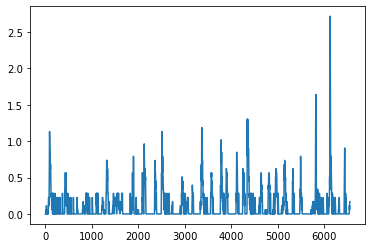

(6560, 5, 2)


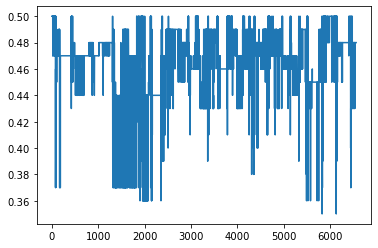

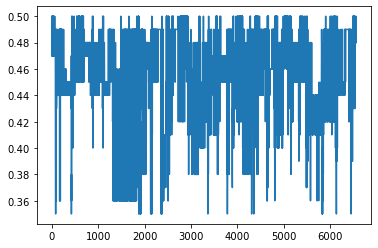

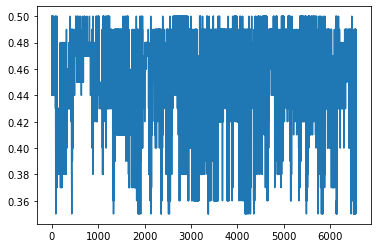

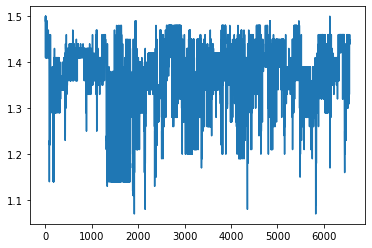

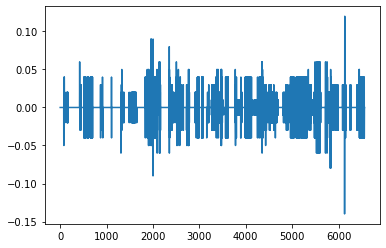

(6559, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-15/8/multi2-12152021152209-0000.avi
Opened video: True


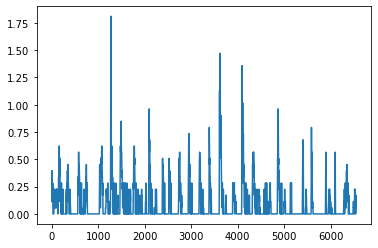

(6556, 5, 2)


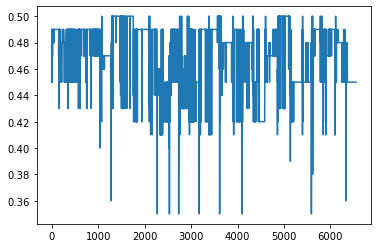

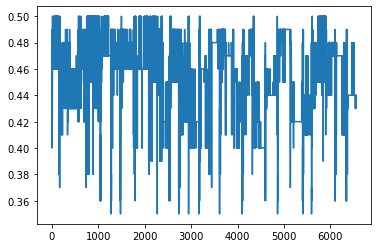

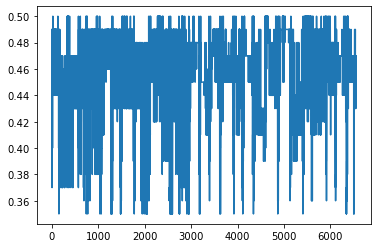

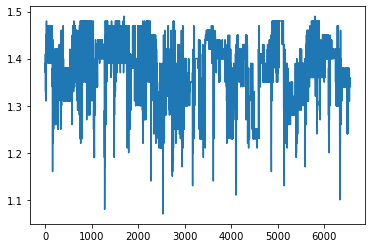

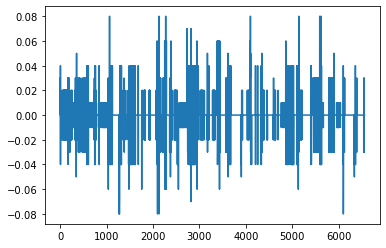

(6555, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-15/8/multi2-12152021152416-0000.avi
Opened video: True


<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\sit

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\sit

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\sit

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\sit

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\sit

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\sit

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\sit

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\sit

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\sit

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\sit

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\sit

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\sit

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\sit

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\sit

<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-152-bec742ac207b>:403: RuntimeWarning: Mean of empty slice.
  bs.append(roi_roi.mean())
C:\Users\Labo\anaconda3\envs\tracking\lib\sit

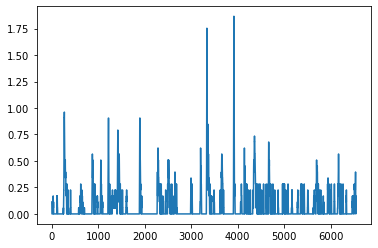

(6555, 5, 2)


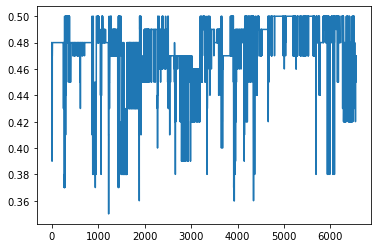

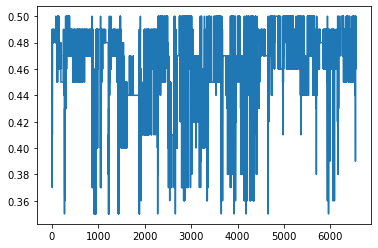

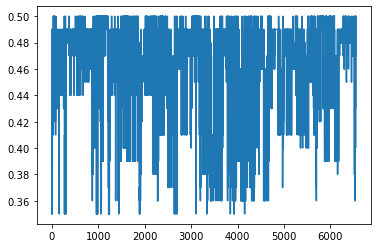

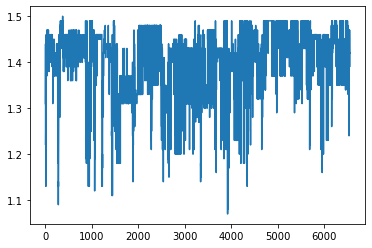

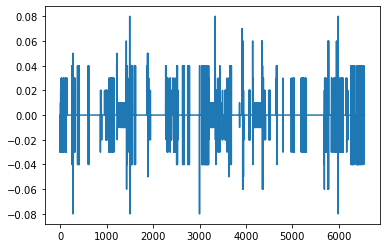

(6554, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-20/1/multi2-12202021121902-0000.avi
Opened video: True
CORRECTING!!!!!!!!!!!!!!! 0.49000000000000016 0
CORRECTING!!!!!!!!!!!!!!! 0.49000000000000016 1
CORRECTING!!!!!!!!!!!!!!! 0.49000000000000016 2
CORRECTING!!!!!!!!!!!!!!! 0.49000000000000016 0
CORRECTING!!!!!!!!!!!!!!! 0.49000000000000016 1
CORRECTING!!!!!!!!!!!!!!! 0.49000000000000016 2
CORRECTING!!!!!!!!!!!!!!! 0.49000000000000016 3
CORRECTING!!!!!!!!!!!!!!! 0.49000000000000016 0
CORRECTING!!!!!!!!!!!!!!! 0.49000000000000016 1
CORRECTING!!!!!!!!!!!!!!! 0.49000000000000016 2
CORRECTING!!!!!!!!!!!!!!! 0.49000000000000016 3
CORRECTING!!

CORRECTING!!!!!!!!!!!!!!! 0.49000000000000016 0
CORRECTING!!!!!!!!!!!!!!! 0.49000000000000016 1
CORRECTING!!!!!!!!!!!!!!! 0.49000000000000016 2
CORRECTING!!!!!!!!!!!!!!! 0.49000000000000016 3
CORRECTING!!!!!!!!!!!!!!! 0.49000000000000016 4
CORRECTING!!!!!!!!!!!!!!! 0.5 5
CORRECTING!!!!!!!!!!!!!!! 0.5 6
CORRECTING!!!!!!!!!!!!!!! 0.5 7
CORRECTING!!!!!!!!!!!!!!! 0.5 8
CORRECTING!!!!!!!!!!!!!!! 0.49000000000000016 0
CORRECTING!!!!!!!!!!!!!!! 0.49000000000000016 1
CORRECTING!!!!!!!!!!!!!!! 0.49000000000000016 2
CORRECTING!!!!!!!!!!!!!!! 0.49000000000000016 3
CORRECTING!!!!!!!!!!!!!!! 0.49000000000000016 4
CORRECTING!!!!!!!!!!!!!!! 0.49000000000000016 5
CORRECTING!!!!!!!!!!!!!!! 0.49000000000000016 0
CORRECTING!!!!!!!!!!!!!!! 0.49000000000000016 1
CORRECTING!!!!!!!!!!!!!!! 0.49000000000000016 2
CORRECTING!!!!!!!!!!!!!!! 0.49000000000000016 3
CORRECTING!!!!!!!!!!!!!!! 0.49000000000000016 4
CORRECTING!!!!!!!!!!!!!!! 0.49000000000000016 5
CORRECTING!!!!!!!!!!!!!!! 0.49000000000000016 6
CORRECTI

CORRECTING!!!!!!!!!!!!!!! 0.49000000000000016 6
CORRECTING!!!!!!!!!!!!!!! 0.49000000000000016 7
CORRECTING!!!!!!!!!!!!!!! 0.49000000000000016 8
CORRECTING!!!!!!!!!!!!!!! 0.5 9
CORRECTING!!!!!!!!!!!!!!! 0.5 10
CORRECTING!!!!!!!!!!!!!!! 0.4599999999999995 0
CORRECTING!!!!!!!!!!!!!!! 0.4599999999999995 1
CORRECTING!!!!!!!!!!!!!!! 0.4599999999999995 2
CORRECTING!!!!!!!!!!!!!!! 0.4599999999999995 3
CORRECTING!!!!!!!!!!!!!!! 0.4800000000000009 4
CORRECTING!!!!!!!!!!!!!!! 0.4800000000000009 5
CORRECTING!!!!!!!!!!!!!!! 0.4800000000000009 6
CORRECTING!!!!!!!!!!!!!!! 0.4800000000000009 7
CORRECTING!!!!!!!!!!!!!!! 0.4800000000000009 8
CORRECTING!!!!!!!!!!!!!!! 0.49000000000000077 9
CORRECTING!!!!!!!!!!!!!!! 0.49000000000000077 10
CORRECTING!!!!!!!!!!!!!!! 0.4599999999999995 11
CORRECTING!!!!!!!!!!!!!!! 0.4599999999999995 12
CORRECTING!!!!!!!!!!!!!!! 0.4599999999999995 13
CORRECTING!!!!!!!!!!!!!!! 0.4599999999999995 14
CORRECTING!!!!!!!!!!!!!!! 0.49000000000000016 0
CORRECTING!!!!!!!!!!!!!!! 0.490

CORRECTING!!!!!!!!!!!!!!! 0.49000000000000016 5
CORRECTING!!!!!!!!!!!!!!! 0.49000000000000016 6
CORRECTING!!!!!!!!!!!!!!! 0.49000000000000016 7
CORRECTING!!!!!!!!!!!!!!! 0.49000000000000016 8
CORRECTING!!!!!!!!!!!!!!! 0.49000000000000016 9
CORRECTING!!!!!!!!!!!!!!! 0.5 10
CORRECTING!!!!!!!!!!!!!!! 0.5 11
CORRECTING!!!!!!!!!!!!!!! 0.5 12
CORRECTING!!!!!!!!!!!!!!! 0.4599999999999995 0
CORRECTING!!!!!!!!!!!!!!! 0.4599999999999995 1
CORRECTING!!!!!!!!!!!!!!! 0.4599999999999995 2
CORRECTING!!!!!!!!!!!!!!! 0.4599999999999995 3
CORRECTING!!!!!!!!!!!!!!! 0.4599999999999995 4
CORRECTING!!!!!!!!!!!!!!! 0.4800000000000009 5
CORRECTING!!!!!!!!!!!!!!! 0.4800000000000009 6
CORRECTING!!!!!!!!!!!!!!! 0.4800000000000009 7
CORRECTING!!!!!!!!!!!!!!! 0.4800000000000009 8
CORRECTING!!!!!!!!!!!!!!! 0.4800000000000009 9
CORRECTING!!!!!!!!!!!!!!! 0.4800000000000009 10
CORRECTING!!!!!!!!!!!!!!! 0.49000000000000077 11
CORRECTING!!!!!!!!!!!!!!! 0.49000000000000077 12
CORRECTING!!!!!!!!!!!!!!! 0.49000000000000077

CORRECTING!!!!!!!!!!!!!!! 0.46999999999999875 5
CORRECTING!!!!!!!!!!!!!!! 0.46999999999999875 6
CORRECTING!!!!!!!!!!!!!!! 0.46999999999999875 7
CORRECTING!!!!!!!!!!!!!!! 0.46999999999999875 8
CORRECTING!!!!!!!!!!!!!!! 0.49000000000000016 9
CORRECTING!!!!!!!!!!!!!!! 0.49000000000000016 10
CORRECTING!!!!!!!!!!!!!!! 0.49000000000000016 11
CORRECTING!!!!!!!!!!!!!!! 0.49000000000000016 12
CORRECTING!!!!!!!!!!!!!!! 0.5 13
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999865 0
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999865 1
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999865 2
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999865 3
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999865 4
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999865 5
CORRECTING!!!!!!!!!!!!!!! 0.5 6
CORRECTING!!!!!!!!!!!!!!! 0.5 7
CORRECTING!!!!!!!!!!!!!!! 0.5 8
CORRECTING!!!!!!!!!!!!!!! 0.5 9
CORRECTING!!!!!!!!!!!!!!! 0.5 10
CORRECTING!!!!!!!!!!!!!!! 0.5 11
CORRECTING!!!!!!!!!!!!!!! 0.5 12
CORRECTING!!!!!!!!!!!!!!! -0.4900000000000001 13
CORRECTING!!!!!!

CORRECTING!!!!!!!!!!!!!!! 0.47999999999999865 5
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999865 6
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999865 7
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999865 8
CORRECTING!!!!!!!!!!!!!!! -0.4900000000000001 9
CORRECTING!!!!!!!!!!!!!!! -0.4900000000000001 10
CORRECTING!!!!!!!!!!!!!!! -0.4900000000000001 11
CORRECTING!!!!!!!!!!!!!!! -0.4900000000000001 12
CORRECTING!!!!!!!!!!!!!!! -0.4900000000000001 13
CORRECTING!!!!!!!!!!!!!!! -0.4900000000000001 14
CORRECTING!!!!!!!!!!!!!!! 0.49000000000000016 0
CORRECTING!!!!!!!!!!!!!!! 0.49000000000000016 1
CORRECTING!!!!!!!!!!!!!!! -0.47999999999999865 2
CORRECTING!!!!!!!!!!!!!!! -0.47999999999999865 3
CORRECTING!!!!!!!!!!!!!!! -0.47999999999999865 4
CORRECTING!!!!!!!!!!!!!!! -0.47999999999999865 5
CORRECTING!!!!!!!!!!!!!!! -0.47999999999999865 6
CORRECTING!!!!!!!!!!!!!!! 0.49000000000000016 7
CORRECTING!!!!!!!!!!!!!!! 0.49000000000000016 8
CORRECTING!!!!!!!!!!!!!!! -0.47999999999999865 9
CORRECTING!!!!!!!!!!!!!!! -0.

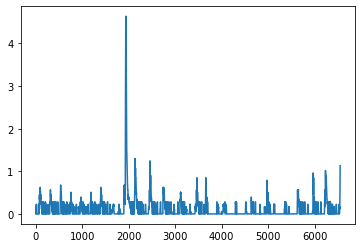

(6557, 5, 2)


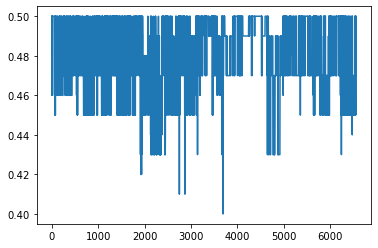

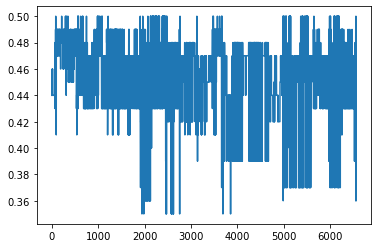

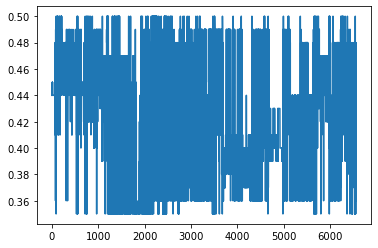

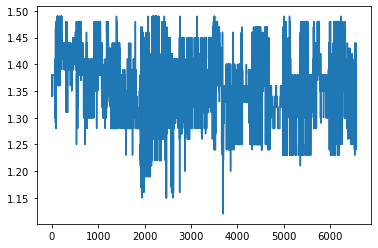

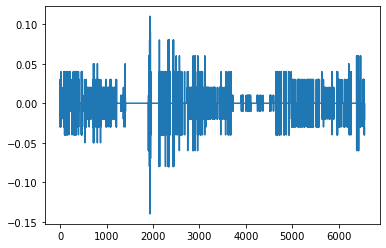

(6556, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-20/1/multi2-12202021122101-0000.avi
Opened video: True
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000002 0
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000002 1
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000002 2
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000002 3
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000002 4
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000002 5
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000002 6
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000002 7
CORRECTING!!!!!!!!!!!!!!! 0.5 0
CORRECTING!!!!!!!!!!!!!!! 0.5 1
CORRECTING!!!!!!!!!!!!!!! 0.5 2
CORRECTING!!!!!!!!!!!!!!! 0.5 3
CORRECTING!!!!!!!!!!!!!!! 0.5 4
CORR

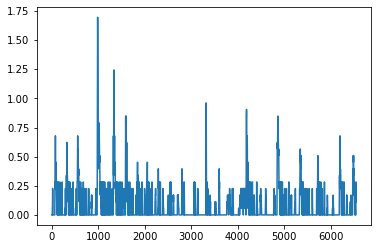

(6556, 5, 2)


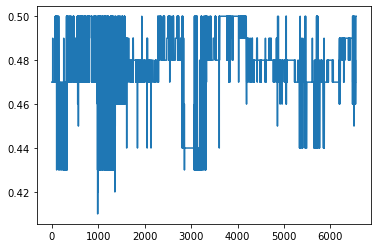

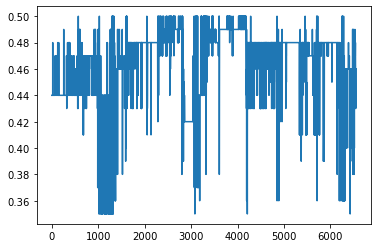

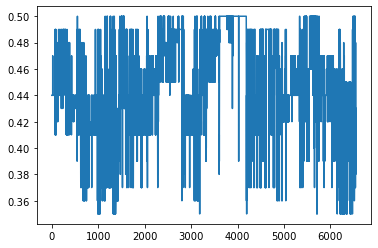

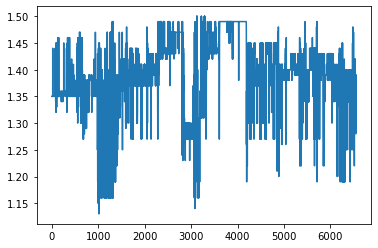

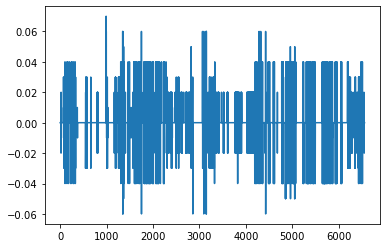

(6555, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-20/1/multi2-12202021122326-0000.avi
Opened video: True
CORRECTING!!!!!!!!!!!!!!! 0.5 0
CORRECTING!!!!!!!!!!!!!!! 0.5 1
CORRECTING!!!!!!!!!!!!!!! 0.5 2
CORRECTING!!!!!!!!!!!!!!! 0.5 0
CORRECTING!!!!!!!!!!!!!!! 0.5 1
CORRECTING!!!!!!!!!!!!!!! 0.5 2
CORRECTING!!!!!!!!!!!!!!! 0.5 0
CORRECTING!!!!!!!!!!!!!!! 0.5 1
CORRECTING!!!!!!!!!!!!!!! 0.5 2
CORRECTING!!!!!!!!!!!!!!! 0.5 0
CORRECTING!!!!!!!!!!!!!!! 0.5 1
CORRECTING!!!!!!!!!!!!!!! 0.5 2
CORRECTING!!!!!!!!!!!!!!! 0.5 0
CORRECTING!!!!!!!!!!!!!!! 0.5 1
CORRECTING!!!!!!!!!!!!!!! 0.5 2
CORRECTING!!!!!!!!!!!!!!! 0.4600000000000006 0
CORRECTING!!!

CORRECTING!!!!!!!!!!!!!!! 0.5 5
CORRECTING!!!!!!!!!!!!!!! 0.4600000000000006 6
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000002 7
CORRECTING!!!!!!!!!!!!!!! 0.5 8
CORRECTING!!!!!!!!!!!!!!! 0.5 9
CORRECTING!!!!!!!!!!!!!!! 0.5 10
CORRECTING!!!!!!!!!!!!!!! 0.5 11
CORRECTING!!!!!!!!!!!!!!! 0.4600000000000006 12
CORRECTING!!!!!!!!!!!!!!! 0.4600000000000006 13
CORRECTING!!!!!!!!!!!!!!! 0.5 0
CORRECTING!!!!!!!!!!!!!!! 0.4600000000000006 1
CORRECTING!!!!!!!!!!!!!!! 0.4600000000000006 2
CORRECTING!!!!!!!!!!!!!!! 0.4600000000000006 3
CORRECTING!!!!!!!!!!!!!!! 0.5 4
CORRECTING!!!!!!!!!!!!!!! 0.5 5
CORRECTING!!!!!!!!!!!!!!! 0.4600000000000006 6
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000002 7
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000002 8
CORRECTING!!!!!!!!!!!!!!! 0.5 0
CORRECTING!!!!!!!!!!!!!!! 0.4600000000000006 1
CORRECTING!!!!!!!!!!!!!!! 0.4600000000000006 2
CORRECTING!!!!!!!!!!!!!!! 0.5 3
CORRECTING!!!!!!!!!!!!!!! 0.5 4
CORRECTING!!!!!!!!!!!!!!! 0.5 5
CORRECTING!!!!!!!!!!!!!!! 0.4600000000000006 

CORRECTING!!!!!!!!!!!!!!! 0.4600000000000006 10
CORRECTING!!!!!!!!!!!!!!! 0.5 11
CORRECTING!!!!!!!!!!!!!!! 0.5 12
CORRECTING!!!!!!!!!!!!!!! 0.5 13
CORRECTING!!!!!!!!!!!!!!! -0.4300000000000008 14
CORRECTING!!!!!!!!!!!!!!! -0.4300000000000008 15
CORRECTING!!!!!!!!!!!!!!! 0.5 0
CORRECTING!!!!!!!!!!!!!!! 0.5 1
CORRECTING!!!!!!!!!!!!!!! 0.4600000000000006 2
CORRECTING!!!!!!!!!!!!!!! 0.4600000000000006 3
CORRECTING!!!!!!!!!!!!!!! 0.4600000000000006 4
CORRECTING!!!!!!!!!!!!!!! 0.5 5
CORRECTING!!!!!!!!!!!!!!! 0.5 6
CORRECTING!!!!!!!!!!!!!!! 0.5 7
CORRECTING!!!!!!!!!!!!!!! 0.5 8
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000002 9
CORRECTING!!!!!!!!!!!!!!! 0.4600000000000006 10
CORRECTING!!!!!!!!!!!!!!! 0.5 0
CORRECTING!!!!!!!!!!!!!!! 0.5 1
CORRECTING!!!!!!!!!!!!!!! 0.4600000000000006 2
CORRECTING!!!!!!!!!!!!!!! 0.4600000000000006 3
CORRECTING!!!!!!!!!!!!!!! 0.4600000000000006 4
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000002 5
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000002 6
CORRECTING!!!!!!!!!!!!!!!

CORRECTING!!!!!!!!!!!!!!! -0.4300000000000008 11
CORRECTING!!!!!!!!!!!!!!! -0.4300000000000008 12
CORRECTING!!!!!!!!!!!!!!! -0.4300000000000008 13
CORRECTING!!!!!!!!!!!!!!! -0.48000000000000076 0
CORRECTING!!!!!!!!!!!!!!! -0.48000000000000076 1
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999987 2
CORRECTING!!!!!!!!!!!!!!! -0.48000000000000076 3
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999987 4
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999987 5
CORRECTING!!!!!!!!!!!!!!! -0.48000000000000076 6
CORRECTING!!!!!!!!!!!!!!! -0.48000000000000076 7
CORRECTING!!!!!!!!!!!!!!! -0.48000000000000076 8
CORRECTING!!!!!!!!!!!!!!! -0.48000000000000076 9
CORRECTING!!!!!!!!!!!!!!! 0.47999999999999987 10
CORRECTING!!!!!!!!!!!!!!! 0.5 0
CORRECTING!!!!!!!!!!!!!!! 0.5 1
CORRECTING!!!!!!!!!!!!!!! 0.4600000000000006 2
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000002 3
CORRECTING!!!!!!!!!!!!!!! 0.4600000000000006 4
CORRECTING!!!!!!!!!!!!!!! 0.4600000000000006 5
CORRECTING!!!!!!!!!!!!!!! 0.5 6
CORRECTING!!!!!!!!!!!!!!! 0.5 7


CORRECTING!!!!!!!!!!!!!!! 0.4600000000000006 5
CORRECTING!!!!!!!!!!!!!!! 0.4600000000000006 6
CORRECTING!!!!!!!!!!!!!!! 0.4600000000000006 7
CORRECTING!!!!!!!!!!!!!!! 0.5 8
CORRECTING!!!!!!!!!!!!!!! 0.5 9
CORRECTING!!!!!!!!!!!!!!! 0.5 10
CORRECTING!!!!!!!!!!!!!!! 0.5 11
CORRECTING!!!!!!!!!!!!!!! 0.4600000000000006 12
CORRECTING!!!!!!!!!!!!!!! 0.4600000000000006 13
CORRECTING!!!!!!!!!!!!!!! -0.4300000000000008 14
CORRECTING!!!!!!!!!!!!!!! -0.4300000000000008 15
CORRECTING!!!!!!!!!!!!!!! 0.5 0
CORRECTING!!!!!!!!!!!!!!! 0.5 1
CORRECTING!!!!!!!!!!!!!!! 0.4600000000000006 2
CORRECTING!!!!!!!!!!!!!!! 0.5 3
CORRECTING!!!!!!!!!!!!!!! 0.4600000000000006 4
CORRECTING!!!!!!!!!!!!!!! 0.4600000000000006 5
CORRECTING!!!!!!!!!!!!!!! 0.4600000000000006 6
CORRECTING!!!!!!!!!!!!!!! 0.4600000000000006 7
CORRECTING!!!!!!!!!!!!!!! 0.5 8
CORRECTING!!!!!!!!!!!!!!! 0.5 9
CORRECTING!!!!!!!!!!!!!!! 0.5 10
CORRECTING!!!!!!!!!!!!!!! 0.4600000000000006 11
CORRECTING!!!!!!!!!!!!!!! 0.4600000000000006 12
CORRECTING!

CORRECTING!!!!!!!!!!!!!!! 0.5 2
CORRECTING!!!!!!!!!!!!!!! 0.5 3
CORRECTING!!!!!!!!!!!!!!! 0.4600000000000006 4
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000002 5
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000002 6
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000002 7
CORRECTING!!!!!!!!!!!!!!! 0.5 8
CORRECTING!!!!!!!!!!!!!!! 0.4699999999999984 9
CORRECTING!!!!!!!!!!!!!!! 0.5 0
CORRECTING!!!!!!!!!!!!!!! 0.5 1
CORRECTING!!!!!!!!!!!!!!! 0.5 2
CORRECTING!!!!!!!!!!!!!!! 0.5 3
CORRECTING!!!!!!!!!!!!!!! 0.4600000000000006 4
CORRECTING!!!!!!!!!!!!!!! 0.4699999999999984 5
CORRECTING!!!!!!!!!!!!!!! 0.4699999999999984 6
CORRECTING!!!!!!!!!!!!!!! 0.4699999999999984 7
CORRECTING!!!!!!!!!!!!!!! 0.4699999999999984 8
CORRECTING!!!!!!!!!!!!!!! 0.5 9
CORRECTING!!!!!!!!!!!!!!! 0.5 10
CORRECTING!!!!!!!!!!!!!!! 0.5 0
CORRECTING!!!!!!!!!!!!!!! 0.5 1
CORRECTING!!!!!!!!!!!!!!! 0.5 2
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000002 3
CORRECTING!!!!!!!!!!!!!!! 0.4600000000000006 4
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000002 5

CORRECTING!!!!!!!!!!!!!!! 0.4400000000000015 10
CORRECTING!!!!!!!!!!!!!!! 0.4400000000000015 11
CORRECTING!!!!!!!!!!!!!!! 0.4400000000000015 12
CORRECTING!!!!!!!!!!!!!!! 0.480000000000001 13
CORRECTING!!!!!!!!!!!!!!! 0.5 0
CORRECTING!!!!!!!!!!!!!!! 0.5 1
CORRECTING!!!!!!!!!!!!!!! 0.5 2
CORRECTING!!!!!!!!!!!!!!! 0.5 3
CORRECTING!!!!!!!!!!!!!!! 0.4600000000000006 4
CORRECTING!!!!!!!!!!!!!!! 0.4699999999999984 5
CORRECTING!!!!!!!!!!!!!!! 0.4699999999999984 6
CORRECTING!!!!!!!!!!!!!!! 0.4699999999999984 7
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000002 8
CORRECTING!!!!!!!!!!!!!!! 0.5 9
CORRECTING!!!!!!!!!!!!!!! 0.4600000000000006 10
CORRECTING!!!!!!!!!!!!!!! 0.4600000000000006 11
CORRECTING!!!!!!!!!!!!!!! 0.5 12
CORRECTING!!!!!!!!!!!!!!! 0.5 13
CORRECTING!!!!!!!!!!!!!!! 0.5 0
CORRECTING!!!!!!!!!!!!!!! 0.5 1
CORRECTING!!!!!!!!!!!!!!! 0.5 2
CORRECTING!!!!!!!!!!!!!!! 0.5 3
CORRECTING!!!!!!!!!!!!!!! 0.4600000000000006 4
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000002 5
CORRECTING!!!!!!!!!!!!!!! -0

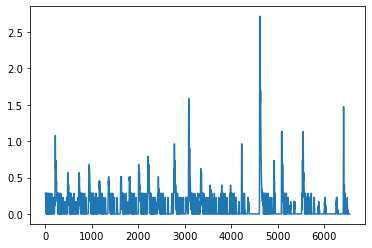

(6558, 5, 2)


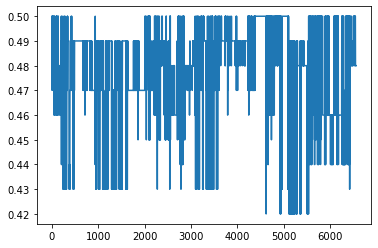

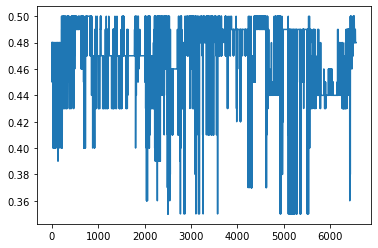

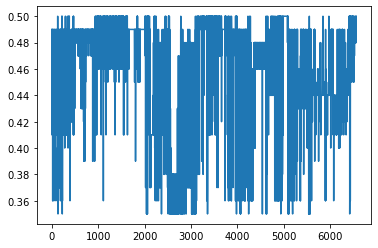

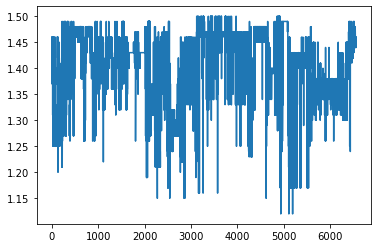

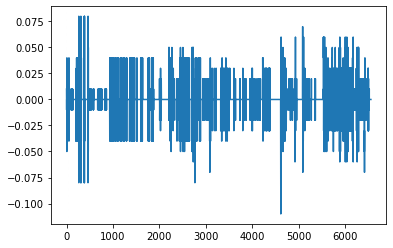

(6557, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-20/1/multi2-12202021122913-0000.avi
Opened video: True
CORRECTING!!!!!!!!!!!!!!! -0.44999999999999973 0
CORRECTING!!!!!!!!!!!!!!! -0.44999999999999973 1
CORRECTING!!!!!!!!!!!!!!! -0.44999999999999973 2
CORRECTING!!!!!!!!!!!!!!! 0.5 3
CORRECTING!!!!!!!!!!!!!!! 0.5 4
CORRECTING!!!!!!!!!!!!!!! 0.5 5
CORRECTING!!!!!!!!!!!!!!! 0.5 6
CORRECTING!!!!!!!!!!!!!!! 0.5 7
CORRECTING!!!!!!!!!!!!!!! 0.5 8
CORRECTING!!!!!!!!!!!!!!! 0.5 9
CORRECTING!!!!!!!!!!!!!!! -0.49000000000000066 0
CORRECTING!!!!!!!!!!!!!!! -0.49000000000000066 1
CORRECTING!!!!!!!!!!!!!!! -0.49000000000000066 2
CORRECTING!!!!!!!!!!!!

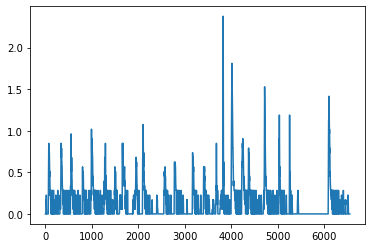

(6558, 5, 2)


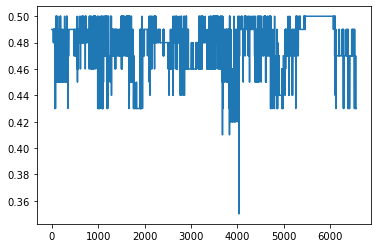

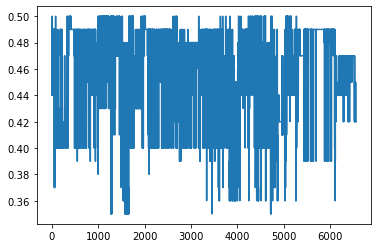

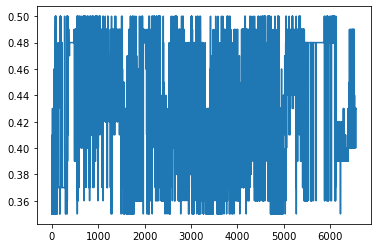

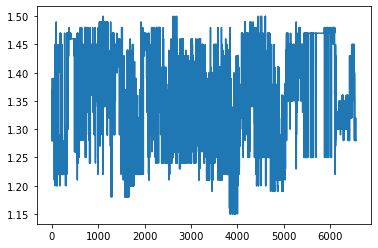

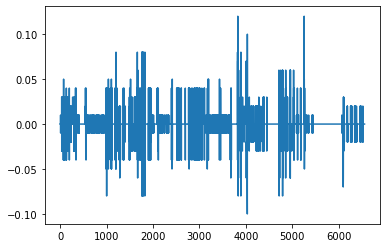

(6557, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-20/1/multi2-12202021123143-0000.avi
Opened video: True
CORRECTING!!!!!!!!!!!!!!! 0.5 0
CORRECTING!!!!!!!!!!!!!!! 0.5 1
CORRECTING!!!!!!!!!!!!!!! 0.5 0
CORRECTING!!!!!!!!!!!!!!! 0.5 1
CORRECTING!!!!!!!!!!!!!!! 0.5 0
CORRECTING!!!!!!!!!!!!!!! 0.5 1
CORRECTING!!!!!!!!!!!!!!! 0.5 0
CORRECTING!!!!!!!!!!!!!!! 0.5 1
CORRECTING!!!!!!!!!!!!!!! 0.5 0
CORRECTING!!!!!!!!!!!!!!! 0.5 1
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000018 0


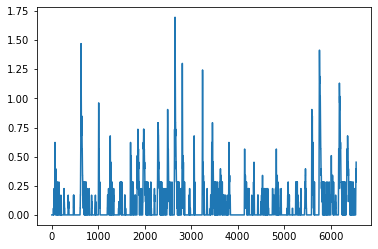

(6557, 5, 2)


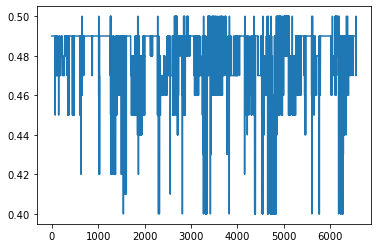

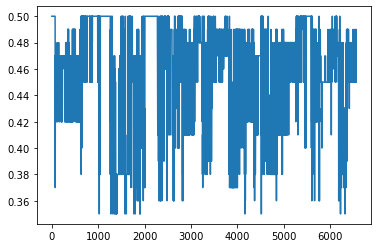

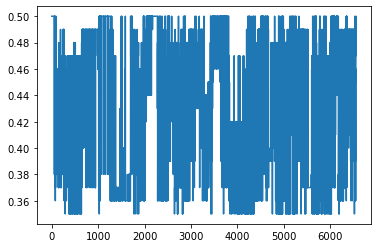

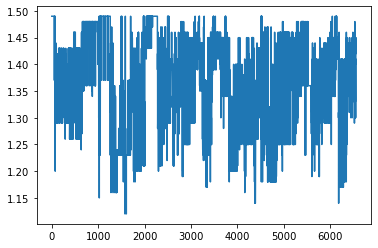

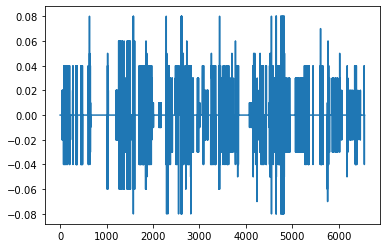

(6556, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-20/1/multi2-12202021123307-0000.avi
Opened video: True


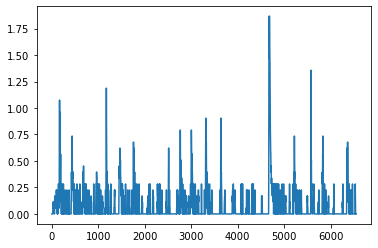

(6559, 5, 2)


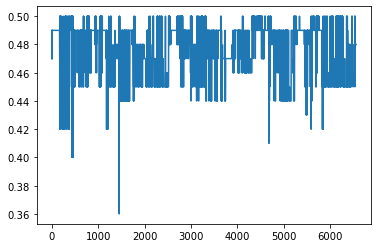

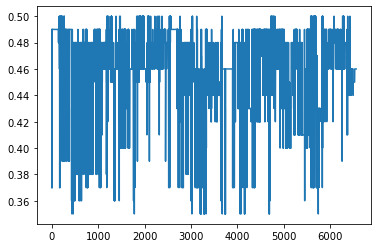

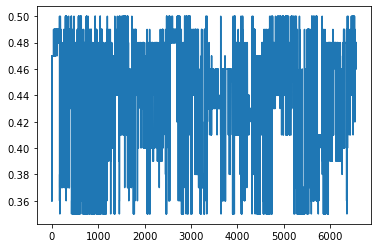

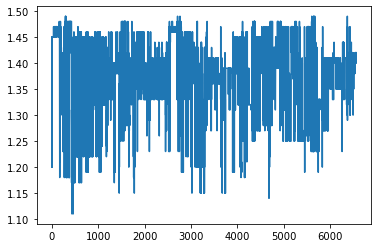

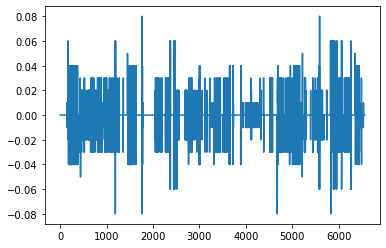

(6558, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-20/1/multi2-12202021123516-0000.avi
Opened video: True
CORRECTING!!!!!!!!!!!!!!! 0.46999999999999925 0
CORRECTING!!!!!!!!!!!!!!! 0.46999999999999925 1
CORRECTING!!!!!!!!!!!!!!! 0.46999999999999925 0
CORRECTING!!!!!!!!!!!!!!! 0.46999999999999925 1
CORRECTING!!!!!!!!!!!!!!! 0.46999999999999925 2
CORRECTING!!!!!!!!!!!!!!! 0.5 0
CORRECTING!!!!!!!!!!!!!!! 0.5 1
CORRECTING!!!!!!!!!!!!!!! 0.5 2
CORRECTING!!!!!!!!!!!!!!! 0.5 3
CORRECTING!!!!!!!!!!!!!!! 0.4399999999999996 0
CORRECTING!!!!!!!!!!!!!!! 0.4399999999999996 1
CORRECTING!!!!!!!!!!!!!!! 0.4399999999999996 2
CORRECTING!!!!!!!!!!!!!!! 0.439

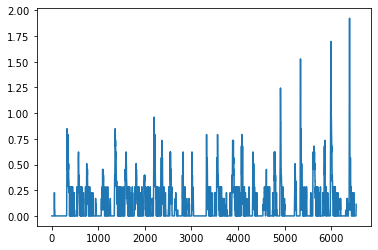

(6547, 5, 2)


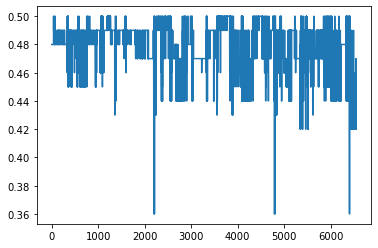

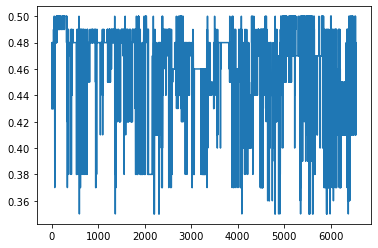

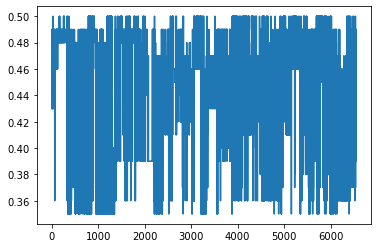

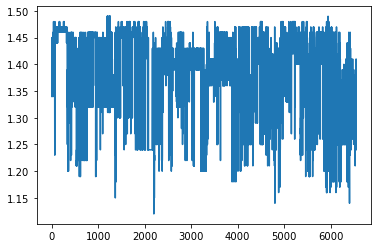

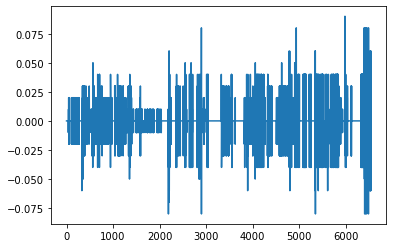

(6546, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-20/1/multi2-12202021123640-0000.avi
Opened video: True


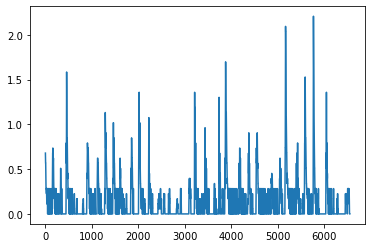

(6555, 5, 2)


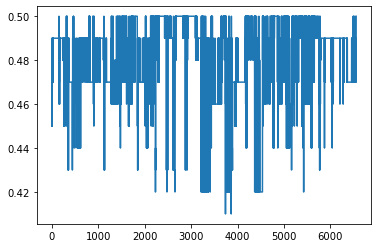

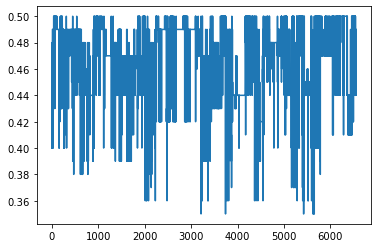

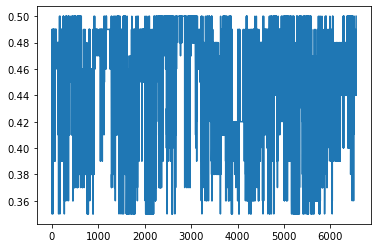

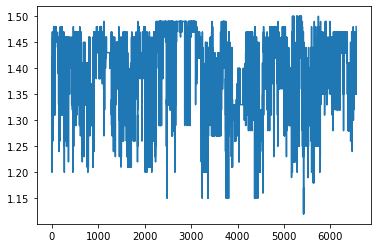

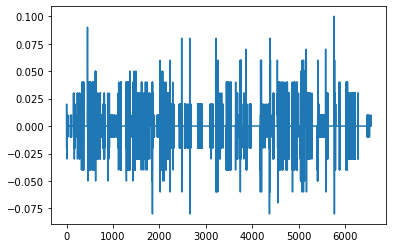

(6554, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-20/2/multi2-12202021124605-0000.avi
Opened video: True


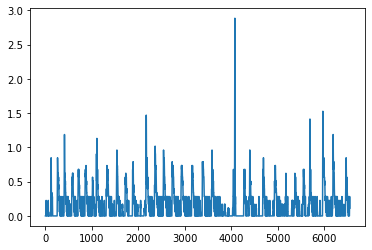

(6557, 5, 2)


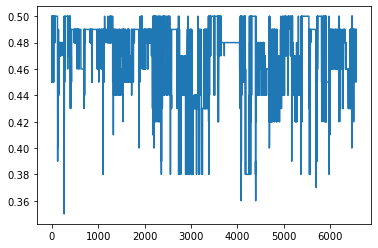

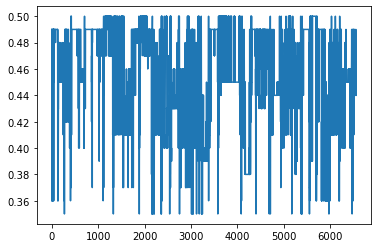

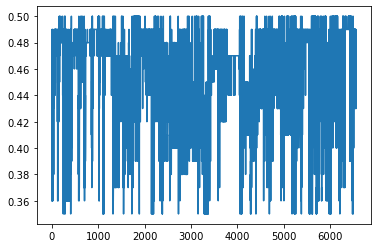

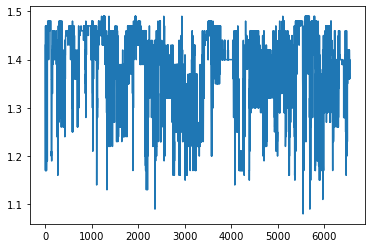

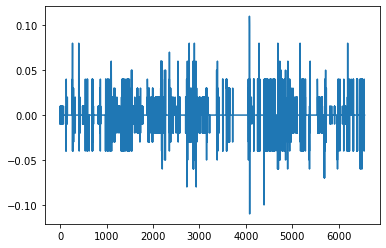

(6556, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-20/2/multi2-12202021124808-0000.avi
Opened video: True


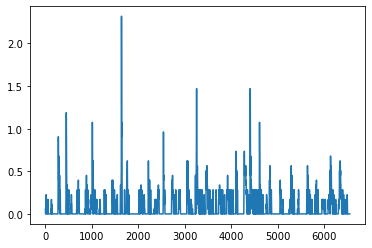

(6559, 5, 2)


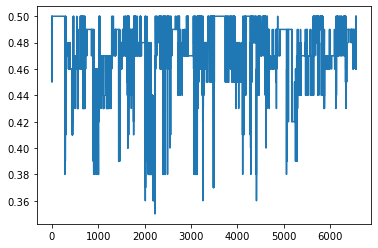

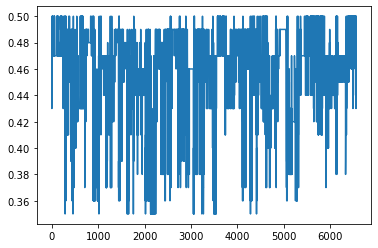

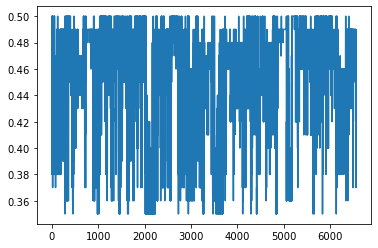

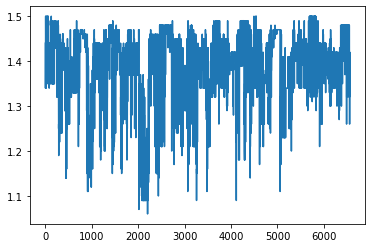

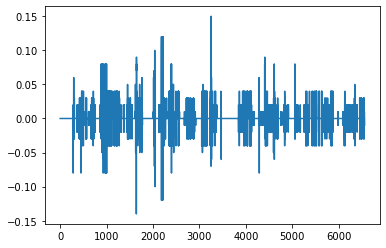

(6558, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-20/2/multi2-12202021125010-0000.avi
Opened video: True


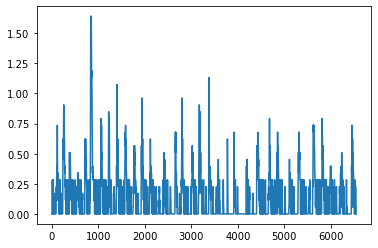

(6554, 5, 2)


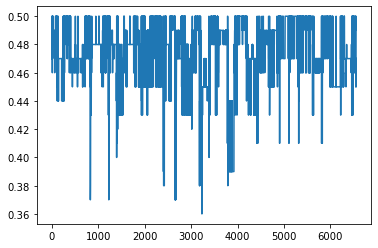

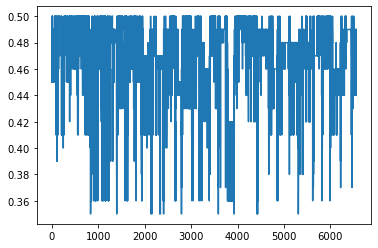

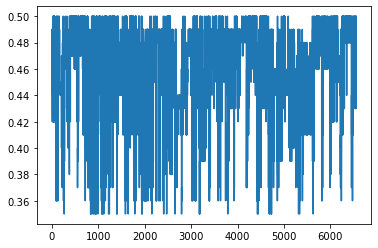

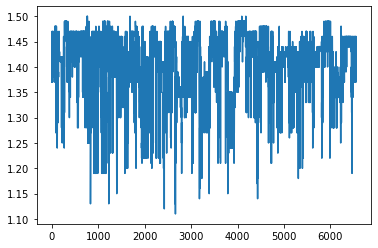

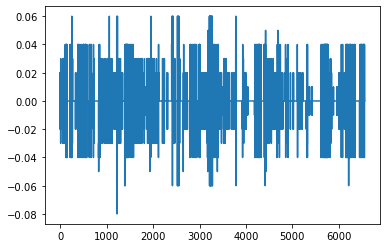

(6553, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-20/2/multi2-12202021125406-0000.avi
Opened video: True


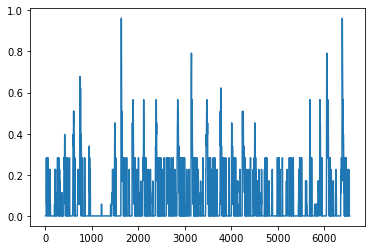

(6558, 5, 2)


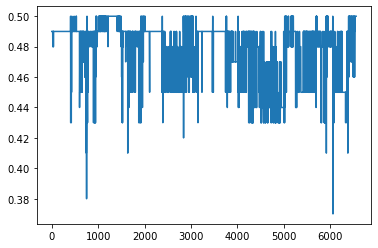

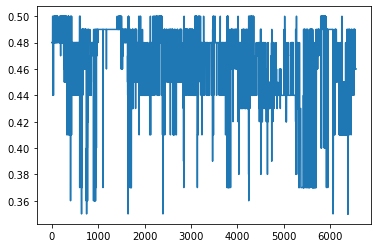

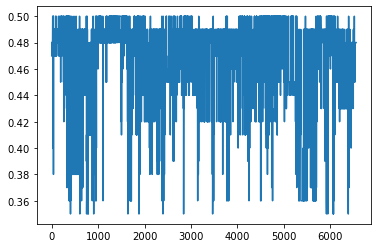

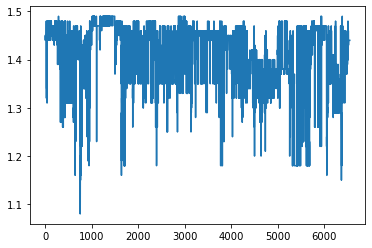

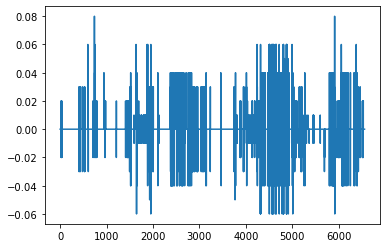

(6557, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-20/2/multi2-12202021130005-0000.avi
Opened video: True


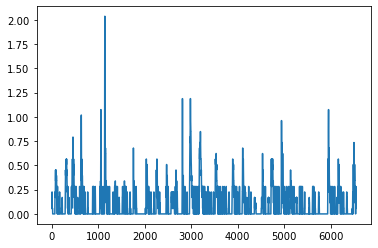

(6558, 5, 2)


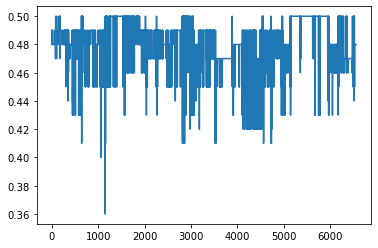

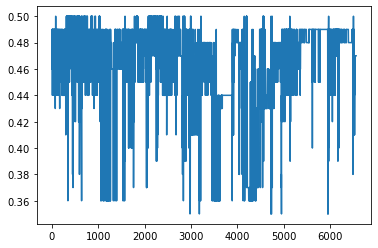

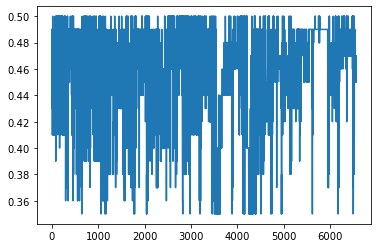

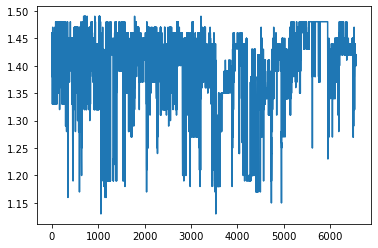

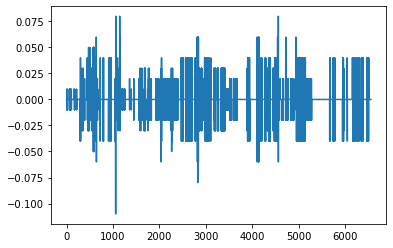

(6557, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-20/3/multi2-12202021131711-0000.avi
Opened video: True


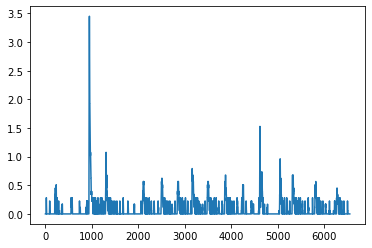

(6556, 5, 2)


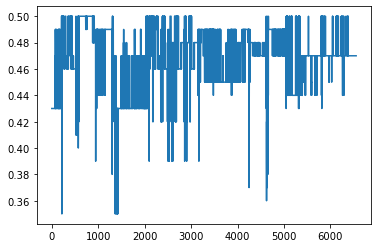

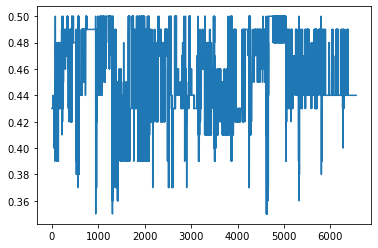

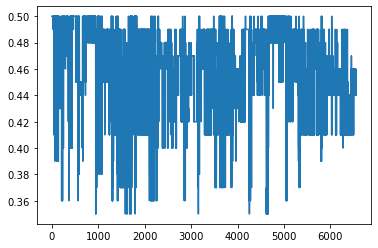

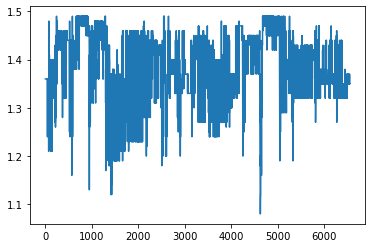

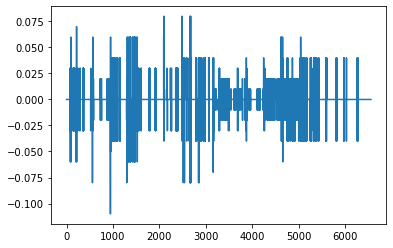

(6555, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-20/4/multi2-12202021135008-0000.avi
Opened video: True
CORRECTING!!!!!!!!!!!!!!! -0.25 0
CORRECTING!!!!!!!!!!!!!!! -0.25 0
CORRECTING!!!!!!!!!!!!!!! 0.2900000000000003 0
CORRECTING!!!!!!!!!!!!!!! 0.2900000000000003 0
CORRECTING!!!!!!!!!!!!!!! -0.45999999999999974 1
CORRECTING!!!!!!!!!!!!!!! 0.2900000000000003 0
CORRECTING!!!!!!!!!!!!!!! 0.2900000000000003 1
CORRECTING!!!!!!!!!!!!!!! 0.2900000000000003 0
CORRECTING!!!!!!!!!!!!!!! 0.2900000000000003 1
CORRECTING!!!!!!!!!!!!!!! -0.3100000000000003 2
CORRECTING!!!!!!!!!!!!!!! 0.36999999999999944 0
CORRECTING!!!!!!!!!!!!!!! 0.36999999999999944

CORRECTING!!!!!!!!!!!!!!! 0.37999999999999945 1
CORRECTING!!!!!!!!!!!!!!! -0.37000000000000055 0
CORRECTING!!!!!!!!!!!!!!! 0.37999999999999945 1
CORRECTING!!!!!!!!!!!!!!! -0.37000000000000055 0
CORRECTING!!!!!!!!!!!!!!! -0.28999999999999915 0
CORRECTING!!!!!!!!!!!!!!! -0.3199999999999994 0
CORRECTING!!!!!!!!!!!!!!! 0.46000000000000096 1
CORRECTING!!!!!!!!!!!!!!! -0.3199999999999994 0
CORRECTING!!!!!!!!!!!!!!! 0.46000000000000096 1
CORRECTING!!!!!!!!!!!!!!! -0.3199999999999994 0
CORRECTING!!!!!!!!!!!!!!! -0.3199999999999994 0
CORRECTING!!!!!!!!!!!!!!! -0.3199999999999994 0
CORRECTING!!!!!!!!!!!!!!! -0.3199999999999994 0
CORRECTING!!!!!!!!!!!!!!! 0.43000000000000055 0
CORRECTING!!!!!!!!!!!!!!! 0.43000000000000055 1
CORRECTING!!!!!!!!!!!!!!! 0.44000000000000034 2
CORRECTING!!!!!!!!!!!!!!! 0.44000000000000034 3
CORRECTING!!!!!!!!!!!!!!! 0.44000000000000034 4
CORRECTING!!!!!!!!!!!!!!! 0.44000000000000034 5
CORRECTING!!!!!!!!!!!!!!! 0.43000000000000055 6
CORRECTING!!!!!!!!!!!!!!! -0.25 0


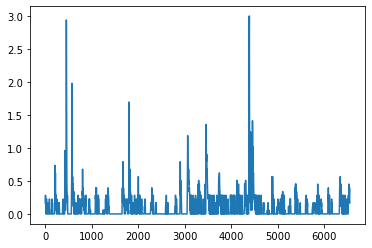

(6557, 5, 2)


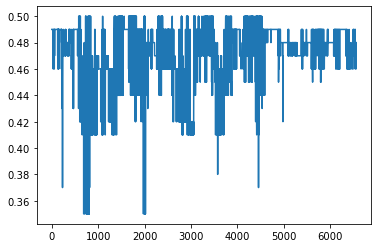

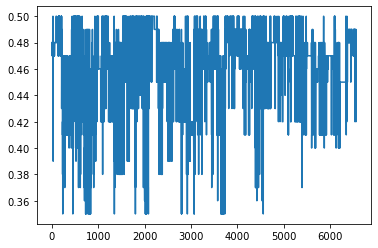

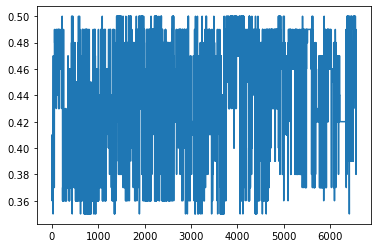

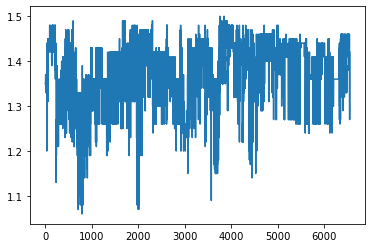

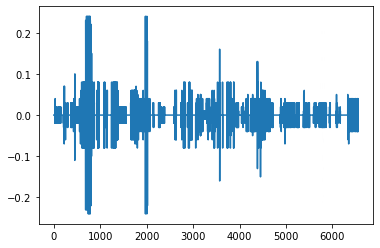

(6556, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-20/4/multi2-12202021135203-0000.avi
Opened video: True
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000004 0
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000004 1
CORRECTING!!!!!!!!!!!!!!! -0.4199999999999997 2
CORRECTING!!!!!!!!!!!!!!! -0.4199999999999997 3
CORRECTING!!!!!!!!!!!!!!! -0.4199999999999997 4
CORRECTING!!!!!!!!!!!!!!! -0.4199999999999997 5
CORRECTING!!!!!!!!!!!!!!! 0.5 0
CORRECTING!!!!!!!!!!!!!!! 0.5 1
CORRECTING!!!!!!!!!!!!!!! 0.5 2
CORRECTING!!!!!!!!!!!!!!! 0.5 0
CORRECTING!!!!!!!!!!!!!!! 0.5 1
CORRECTING!!!!!!!!!!!!!!! 0.5 2
CORRECTING!!!!!!!!!!!!!!! 0.5 0
CORRECTING!!!!!!!!!!!!!!! 0.

CORRECTING!!!!!!!!!!!!!!! -0.47999999999999954 0
CORRECTING!!!!!!!!!!!!!!! -0.47999999999999954 1
CORRECTING!!!!!!!!!!!!!!! -0.47999999999999954 2
CORRECTING!!!!!!!!!!!!!!! -0.47999999999999954 3
CORRECTING!!!!!!!!!!!!!!! -0.47999999999999954 0
CORRECTING!!!!!!!!!!!!!!! -0.47999999999999954 1
CORRECTING!!!!!!!!!!!!!!! -0.47999999999999954 2
CORRECTING!!!!!!!!!!!!!!! -0.47999999999999954 0
CORRECTING!!!!!!!!!!!!!!! -0.47999999999999954 1
CORRECTING!!!!!!!!!!!!!!! -0.47999999999999954 2
CORRECTING!!!!!!!!!!!!!!! -0.47999999999999954 3
CORRECTING!!!!!!!!!!!!!!! -0.47999999999999954 0
CORRECTING!!!!!!!!!!!!!!! -0.47999999999999954 1
CORRECTING!!!!!!!!!!!!!!! -0.47999999999999954 2
CORRECTING!!!!!!!!!!!!!!! -0.47999999999999954 0
CORRECTING!!!!!!!!!!!!!!! -0.47999999999999954 1
CORRECTING!!!!!!!!!!!!!!! -0.47999999999999954 2
CORRECTING!!!!!!!!!!!!!!! -0.47999999999999954 3
CORRECTING!!!!!!!!!!!!!!! -0.47999999999999954 0
CORRECTING!!!!!!!!!!!!!!! -0.47999999999999954 1
CORRECTING!!!!!!!!!!

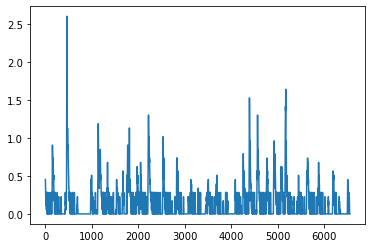

(6557, 5, 2)


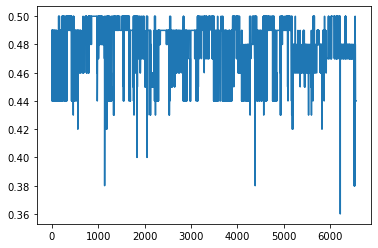

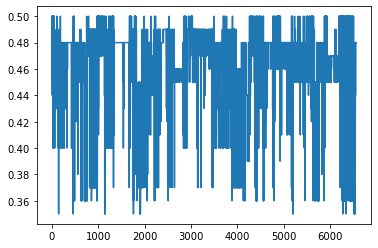

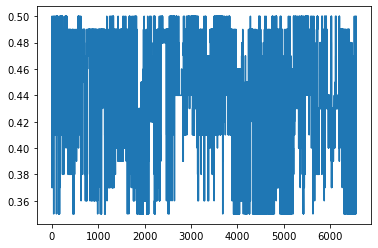

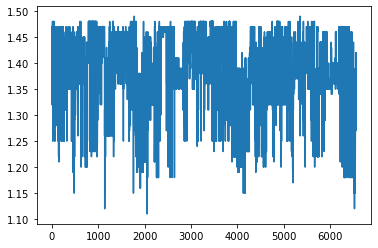

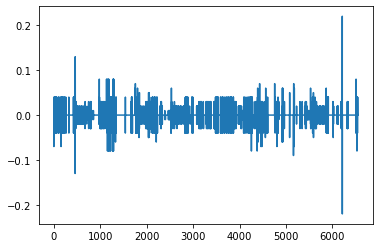

(6556, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-20/4/multi2-12202021135404-0000.avi
Opened video: True


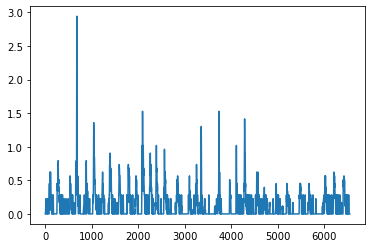

(6557, 5, 2)


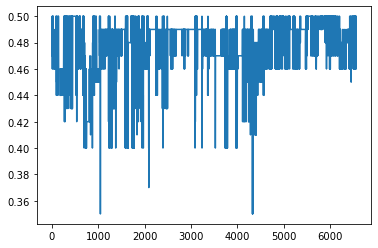

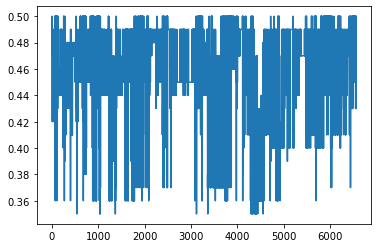

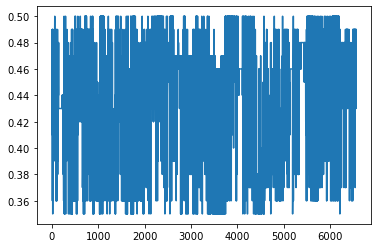

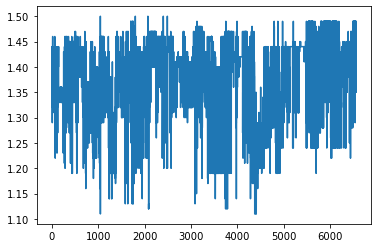

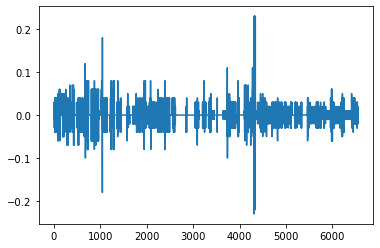

(6556, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-20/4/multi2-12202021135701-0000.avi
Opened video: True


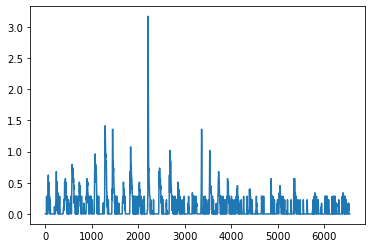

(6559, 5, 2)


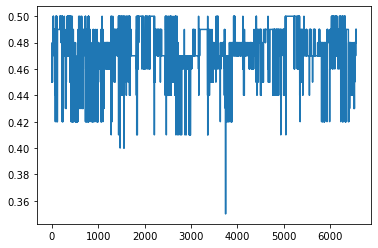

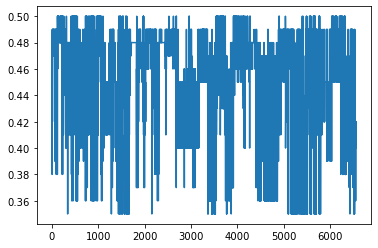

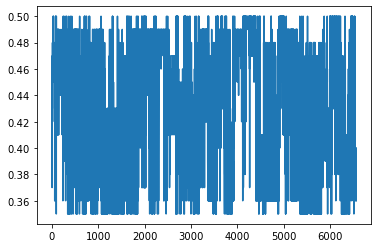

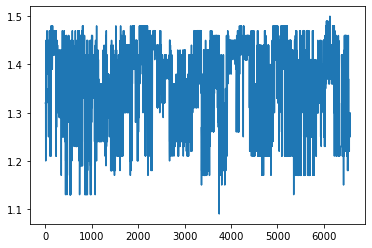

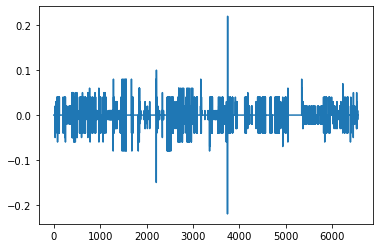

(6558, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-20/4/multi2-12202021135827-0000.avi
Opened video: True
CORRECTING!!!!!!!!!!!!!!! 0.37999999999999967 0
CORRECTING!!!!!!!!!!!!!!! 0.37999999999999967 0


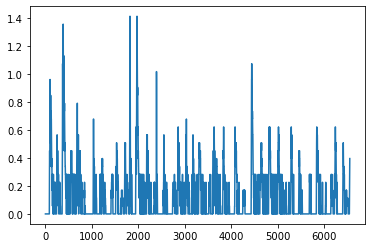

(6556, 5, 2)


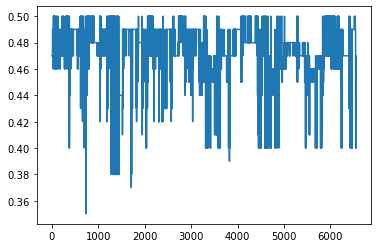

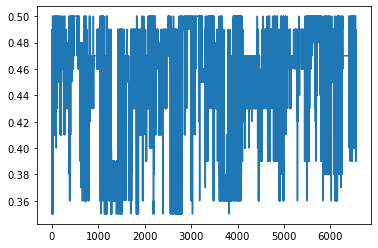

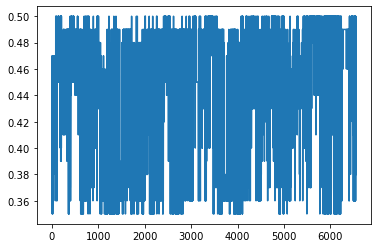

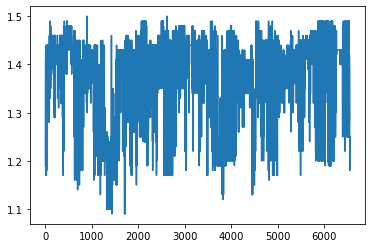

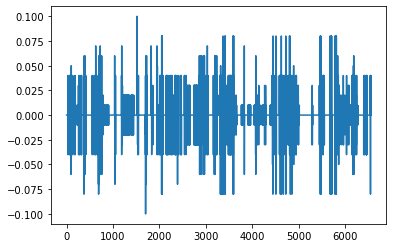

(6555, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-20/4/multi2-12202021140022-0000.avi
Opened video: True


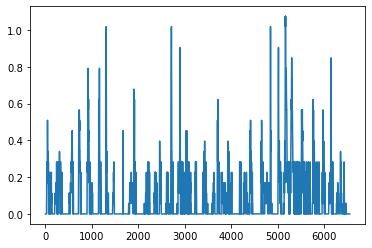

(6559, 5, 2)


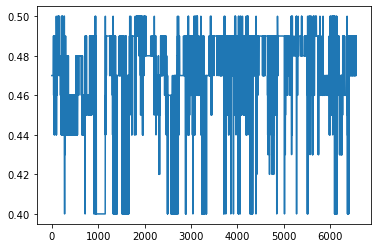

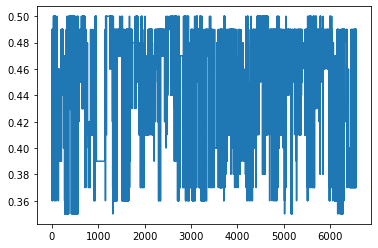

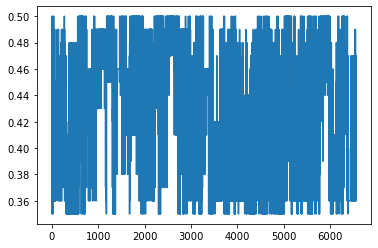

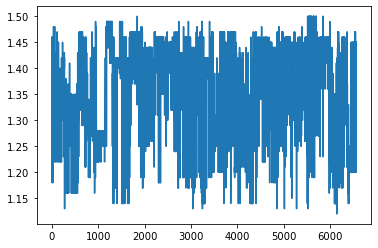

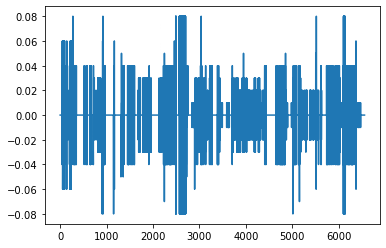

(6558, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-20/4/multi2-12202021140204-0000.avi
Opened video: True
CORRECTING!!!!!!!!!!!!!!! 0.26999999999999974 0
CORRECTING!!!!!!!!!!!!!!! 0.2900000000000004 0
CORRECTING!!!!!!!!!!!!!!! 0.26999999999999974 0
CORRECTING!!!!!!!!!!!!!!! 0.2900000000000004 0
CORRECTING!!!!!!!!!!!!!!! 0.25 0


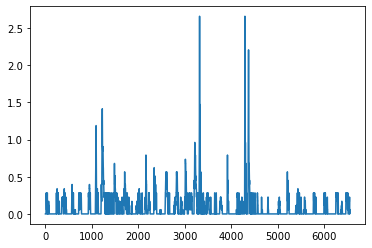

(6555, 5, 2)


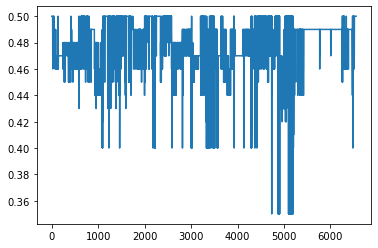

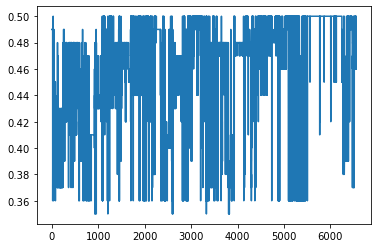

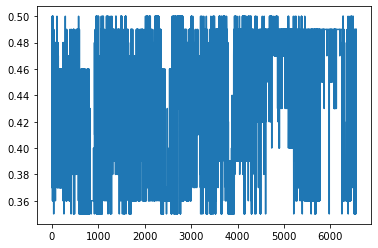

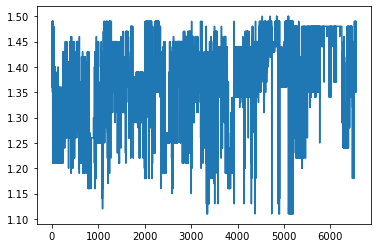

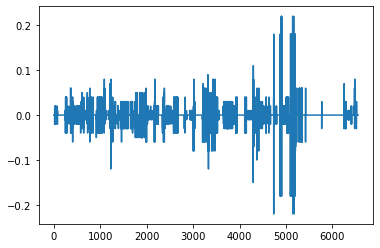

(6554, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-20/4/multi2-12202021140402-0000.avi
Opened video: True


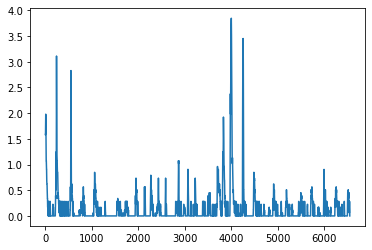

(6558, 5, 2)


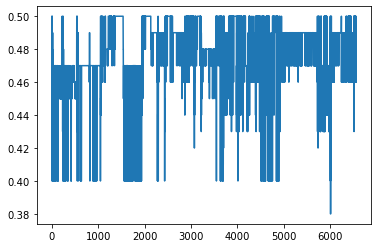

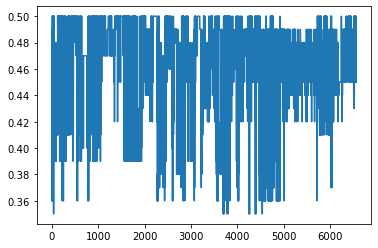

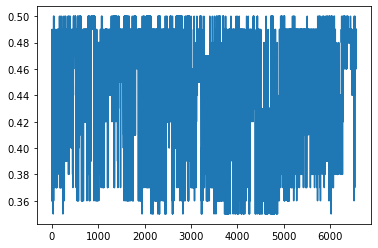

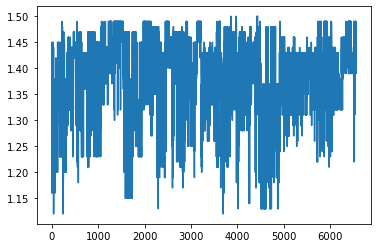

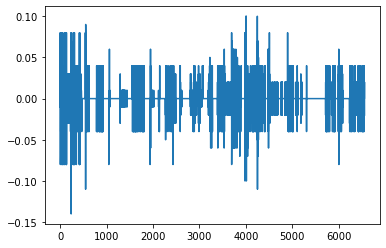

(6557, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-20/5/multi2-12202021143523-0000.avi
Opened video: True
CORRECTING!!!!!!!!!!!!!!! -0.26000000000000134 0
CORRECTING!!!!!!!!!!!!!!! 0.26999999999999924 1
CORRECTING!!!!!!!!!!!!!!! -0.26000000000000134 0
CORRECTING!!!!!!!!!!!!!!! 0.3599999999999983 1
CORRECTING!!!!!!!!!!!!!!! -0.26000000000000134 0
CORRECTING!!!!!!!!!!!!!!! -0.46999999999999975 0
CORRECTING!!!!!!!!!!!!!!! -0.2900000000000005 0
CORRECTING!!!!!!!!!!!!!!! -0.46999999999999975 0
CORRECTING!!!!!!!!!!!!!!! -0.2900000000000005 0
CORRECTING!!!!!!!!!!!!!!! -0.2900000000000005 0
CORRECTING!!!!!!!!!!!!!!! -0.46999999999999975 0
CORRECT

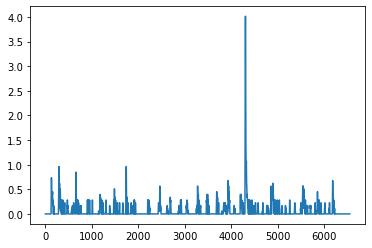

(6558, 5, 2)


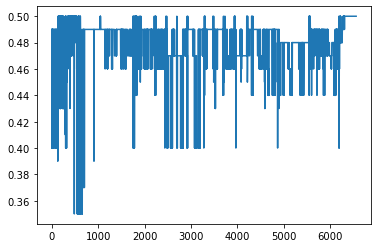

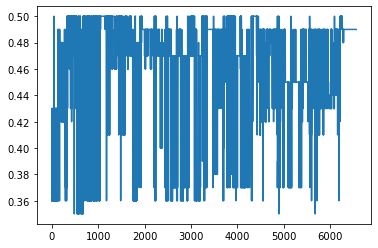

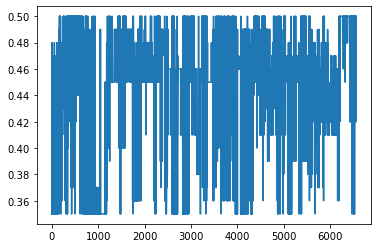

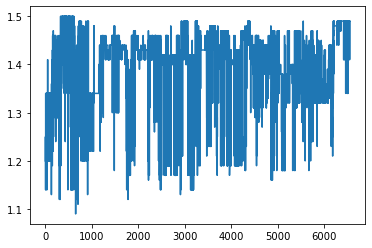

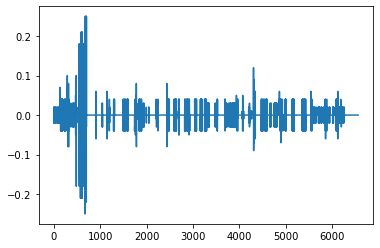

(6557, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-20/5/multi2-12202021143701-0000.avi
Opened video: True
CORRECTING!!!!!!!!!!!!!!! -0.48000000000000176 0
CORRECTING!!!!!!!!!!!!!!! -0.48000000000000176 1
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000015 0
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000015 1
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000015 2
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000015 3
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000015 4
CORRECTING!!!!!!!!!!!!!!! -0.48000000000000176 5
CORRECTING!!!!!!!!!!!!!!! -0.48000000000000176 0
CORRECTING!!!!!!!!!!!!!!! -0.48000000000000176 1
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000015 2
CORRECT

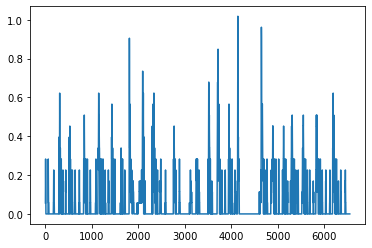

(6556, 5, 2)


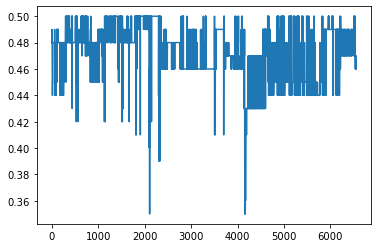

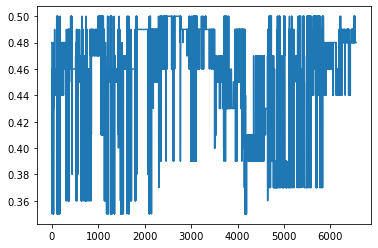

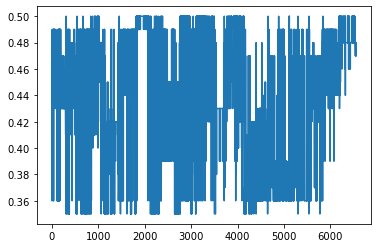

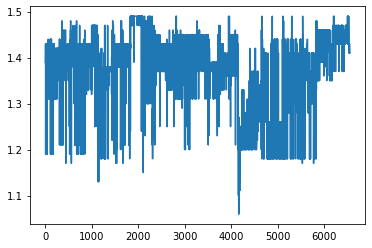

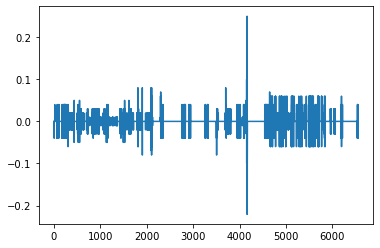

(6555, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-20/5/multi2-12202021144251-0000.avi
Opened video: True
CORRECTING!!!!!!!!!!!!!!! 0.30000000000000004 0
CORRECTING!!!!!!!!!!!!!!! -0.44999999999999996 1


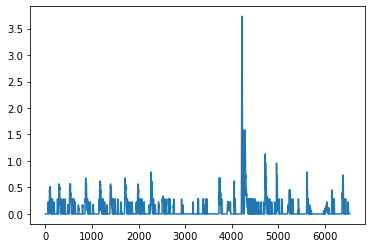

(6549, 5, 2)


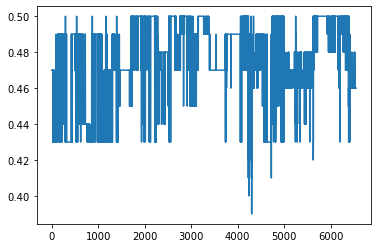

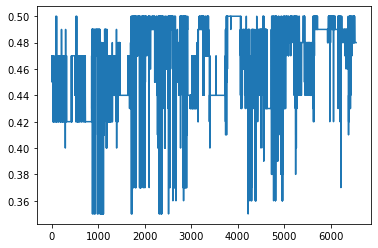

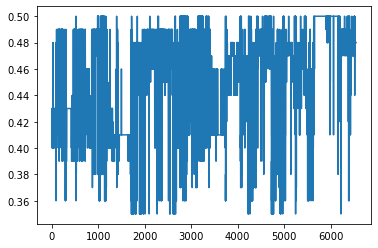

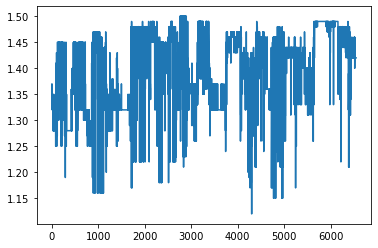

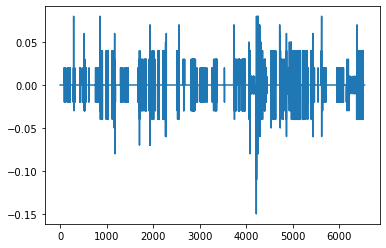

(6548, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-20/5/multi2-12202021144421-0000.avi
Opened video: True
CORRECTING!!!!!!!!!!!!!!! -0.25000000000000056 0
CORRECTING!!!!!!!!!!!!!!! -0.47000000000000175 0
CORRECTING!!!!!!!!!!!!!!! -0.47000000000000175 0
CORRECTING!!!!!!!!!!!!!!! -0.31000000000000005 0
CORRECTING!!!!!!!!!!!!!!! 0.31000000000000005 0
CORRECTING!!!!!!!!!!!!!!! 0.2500000000000006 1
CORRECTING!!!!!!!!!!!!!!! 0.2500000000000006 2
CORRECTING!!!!!!!!!!!!!!! 0.2500000000000006 3
CORRECTING!!!!!!!!!!!!!!! 0.31000000000000005 4
CORRECTING!!!!!!!!!!!!!!! -0.43999999999999995 5
CORRECTING!!!!!!!!!!!!!!! 0.2500000000000006 6
CORRECTING!

CORRECTING!!!!!!!!!!!!!!! -0.47000000000000175 0
CORRECTING!!!!!!!!!!!!!!! -0.47000000000000175 0
CORRECTING!!!!!!!!!!!!!!! -0.47000000000000175 0
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000018 0
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000018 0
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000018 0
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000018 0
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000018 1
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000018 2
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000018 3
CORRECTING!!!!!!!!!!!!!!! 0.2500000000000006 0
CORRECTING!!!!!!!!!!!!!!! 0.2500000000000006 1
CORRECTING!!!!!!!!!!!!!!! 0.2500000000000006 2
CORRECTING!!!!!!!!!!!!!!! 0.2500000000000006 3
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000018 0
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000018 1
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000018 2
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000018 3
CORRECTING!!!!!!!!!!!!!!! 0.2500000000000006 0
CORRECTING!!!!!!!!!!!!!!! 0.2500000000000006 1
CORRECTING!!!!!!!!!!!!!!! 0.2500000000000006 2
CORRECT

CORRECTING!!!!!!!!!!!!!!! 0.46999999999999825 0
CORRECTING!!!!!!!!!!!!!!! 0.46999999999999825 0
CORRECTING!!!!!!!!!!!!!!! 0.44000000000000006 0
CORRECTING!!!!!!!!!!!!!!! 0.44000000000000006 0
CORRECTING!!!!!!!!!!!!!!! 0.46999999999999825 0
CORRECTING!!!!!!!!!!!!!!! 0.46999999999999825 0
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000018 0
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000018 0
CORRECTING!!!!!!!!!!!!!!! 0.4700000000000018 0
CORRECTING!!!!!!!!!!!!!!! -0.25000000000000056 0
CORRECTING!!!!!!!!!!!!!!! -0.25000000000000056 1
CORRECTING!!!!!!!!!!!!!!! 0.3099999999999994 2
CORRECTING!!!!!!!!!!!!!!! -0.47000000000000175 0
CORRECTING!!!!!!!!!!!!!!! -0.47000000000000175 1
CORRECTING!!!!!!!!!!!!!!! -0.47000000000000175 2
CORRECTING!!!!!!!!!!!!!!! -0.47000000000000175 0
CORRECTING!!!!!!!!!!!!!!! 0.2800000000000003 0
CORRECTING!!!!!!!!!!!!!!! -0.45999999999999996 0
CORRECTING!!!!!!!!!!!!!!! 0.3200000000000005 0
CORRECTING!!!!!!!!!!!!!!! -0.45999999999999996 0
CORRECTING!!!!!!!!!!!!!!! -0.459999999

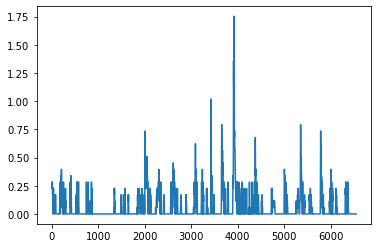

(6559, 5, 2)


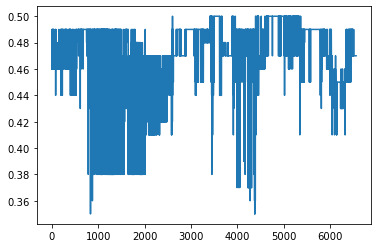

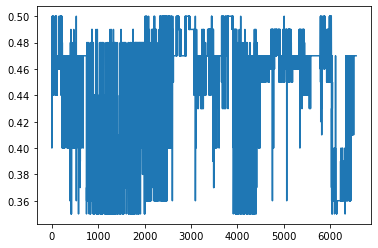

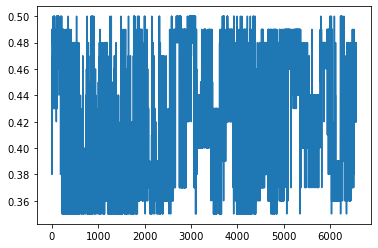

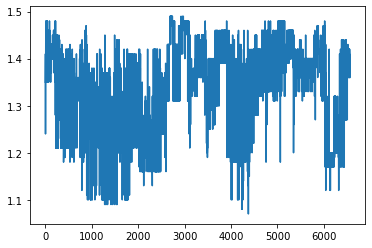

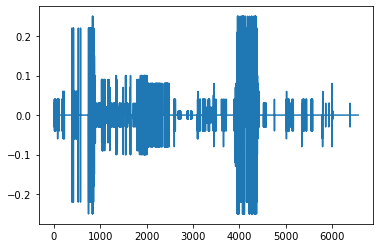

(6558, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-20/5/multi2-12202021144821-0000.avi
Opened video: True
CORRECTING!!!!!!!!!!!!!!! -0.3199999999999984 0
CORRECTING!!!!!!!!!!!!!!! -0.3199999999999984 0
CORRECTING!!!!!!!!!!!!!!! -0.2899999999999989 0
CORRECTING!!!!!!!!!!!!!!! -0.2899999999999989 1
CORRECTING!!!!!!!!!!!!!!! -0.3199999999999984 0
CORRECTING!!!!!!!!!!!!!!! -0.2899999999999989 0
CORRECTING!!!!!!!!!!!!!!! -0.2899999999999989 1
CORRECTING!!!!!!!!!!!!!!! -0.3199999999999984 0
CORRECTING!!!!!!!!!!!!!!! -0.3199999999999984 1
CORRECTING!!!!!!!!!!!!!!! -0.3199999999999984 0
CORRECTING!!!!!!!!!!!!!!! -0.3199999999999984 0
CORRECTING!!

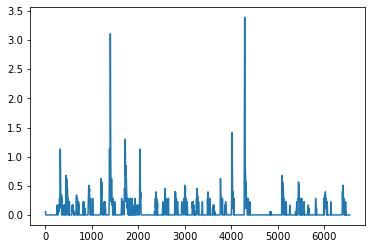

(6560, 5, 2)


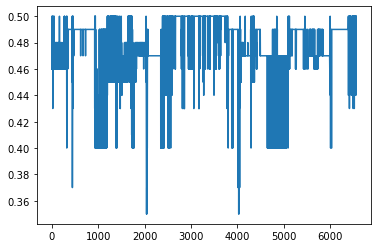

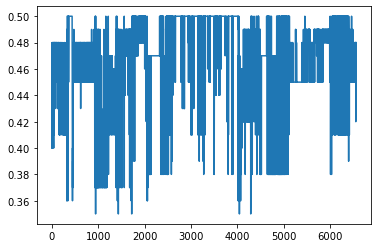

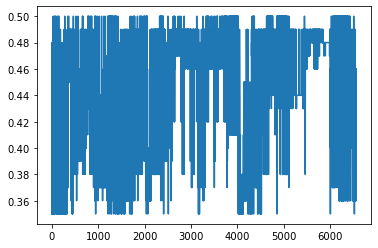

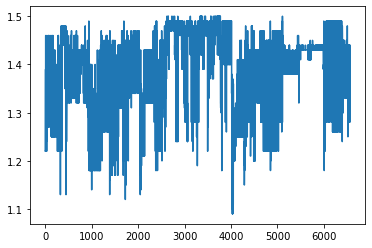

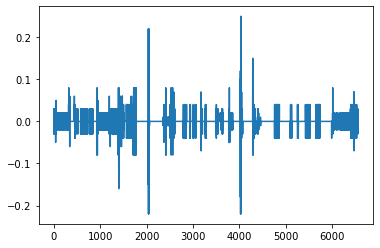

(6559, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-20/5/multi2-12202021144926-0000.avi
Opened video: True
CORRECTING!!!!!!!!!!!!!!! 0.34999999999999953 0
CORRECTING!!!!!!!!!!!!!!! -0.37000000000000055 0
CORRECTING!!!!!!!!!!!!!!! 0.36999999999999966 0
CORRECTING!!!!!!!!!!!!!!! 0.34999999999999953 0
CORRECTING!!!!!!!!!!!!!!! -0.40000000000000036 1
CORRECTING!!!!!!!!!!!!!!! -0.4300000000000006 0
CORRECTING!!!!!!!!!!!!!!! -0.4300000000000006 0
CORRECTING!!!!!!!!!!!!!!! 0.34999999999999953 1
CORRECTING!!!!!!!!!!!!!!! 0.34999999999999953 0
CORRECTING!!!!!!!!!!!!!!! 0.34999999999999953 0
CORRECTING!!!!!!!!!!!!!!! -0.4300000000000006 1
CORRECTING

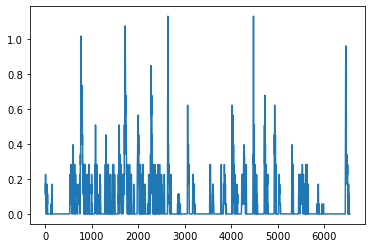

(6560, 5, 2)


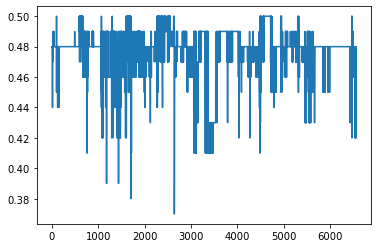

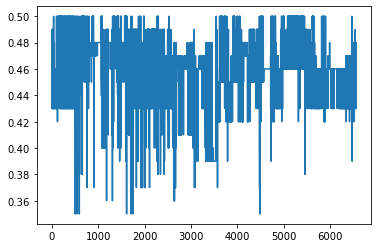

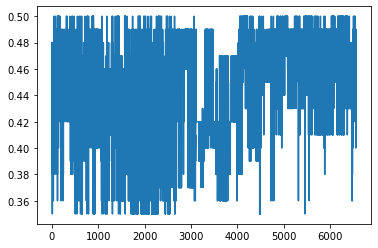

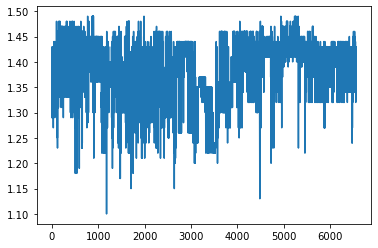

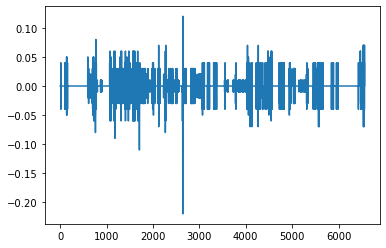

(6559, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-20/5/multi2-12202021145101-0000.avi
Opened video: True
CORRECTING!!!!!!!!!!!!!!! -0.37000000000000044 0
CORRECTING!!!!!!!!!!!!!!! -0.37000000000000044 0
CORRECTING!!!!!!!!!!!!!!! -0.37000000000000044 0
CORRECTING!!!!!!!!!!!!!!! -0.37000000000000044 0
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000004 0
CORRECTING!!!!!!!!!!!!!!! -0.37000000000000044 0
CORRECTING!!!!!!!!!!!!!!! -0.37000000000000044 0
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000004 0
CORRECTING!!!!!!!!!!!!!!! -0.37000000000000044 0
CORRECTING!!!!!!!!!!!!!!! -0.37000000000000044 0
CORRECTING!!!!!!!!!!!!!!! -0.37000000000000044 0
COR

CORRECTING!!!!!!!!!!!!!!! -0.30999999999999994 0
CORRECTING!!!!!!!!!!!!!!! 0.47000000000000053 1
CORRECTING!!!!!!!!!!!!!!! -0.30999999999999994 0
CORRECTING!!!!!!!!!!!!!!! 0.47000000000000053 1
CORRECTING!!!!!!!!!!!!!!! -0.30999999999999994 0
CORRECTING!!!!!!!!!!!!!!! -0.30999999999999994 0
CORRECTING!!!!!!!!!!!!!!! 0.47000000000000053 0
CORRECTING!!!!!!!!!!!!!!! 0.25 0
CORRECTING!!!!!!!!!!!!!!! 0.47000000000000053 0
CORRECTING!!!!!!!!!!!!!!! 0.25 1
CORRECTING!!!!!!!!!!!!!!! 0.47000000000000053 0
CORRECTING!!!!!!!!!!!!!!! 0.37000000000000044 0
CORRECTING!!!!!!!!!!!!!!! 0.47000000000000053 1
CORRECTING!!!!!!!!!!!!!!! 0.47000000000000053 0
CORRECTING!!!!!!!!!!!!!!! 0.38000000000000006 0
CORRECTING!!!!!!!!!!!!!!! 0.25 1
CORRECTING!!!!!!!!!!!!!!! -0.3100000000000005 0
CORRECTING!!!!!!!!!!!!!!! 0.469999999999999 1
CORRECTING!!!!!!!!!!!!!!! -0.25 0
CORRECTING!!!!!!!!!!!!!!! -0.25 0
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000004 0
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000004 0
CORRECTING!!!!!

<ipython-input-152-bec742ac207b>:159: RuntimeWarning: divide by zero encountered in true_divide
  return (regMinY, regMinX), (regMaxY, regMaxX), 1/a, (-1)*intercept/a
<ipython-input-152-bec742ac207b>:209: RuntimeWarning: invalid value encountered in true_divide
  v2 = v2/np.linalg.norm(v2)
<ipython-input-152-bec742ac207b>:206: RuntimeWarning: invalid value encountered in true_divide
  v1 = v1/np.linalg.norm(v1)


CORRECTING!!!!!!!!!!!!!!! -0.37000000000000044 0
CORRECTING!!!!!!!!!!!!!!! 0.31999999999999956 1
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000004 0
CORRECTING!!!!!!!!!!!!!!! 0.31 0
CORRECTING!!!!!!!!!!!!!!! 0.31 1
CORRECTING!!!!!!!!!!!!!!! -0.3599999999999999 2
CORRECTING!!!!!!!!!!!!!!! -0.3199999999999995 3
CORRECTING!!!!!!!!!!!!!!! -0.37000000000000044 0
CORRECTING!!!!!!!!!!!!!!! -0.37000000000000044 1
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000004 0
CORRECTING!!!!!!!!!!!!!!! 0.31999999999999956 0
CORRECTING!!!!!!!!!!!!!!! -0.37000000000000044 1
CORRECTING!!!!!!!!!!!!!!! -0.37000000000000044 0
CORRECTING!!!!!!!!!!!!!!! 0.28999999999999915 0
CORRECTING!!!!!!!!!!!!!!! -0.25 0
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000004 0
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000004 0
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000004 0
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000004 0
CORRECTING!!!!!!!!!!!!!!! -0.4700000000000004 0
CORRECTING!!!!!!!!!!!!!!! -0.43999999999999995 0
CORRECTING!!!!!!!!!!!!!!! -0.4

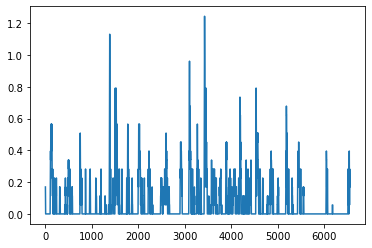

(6556, 5, 2)


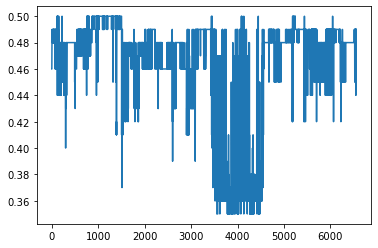

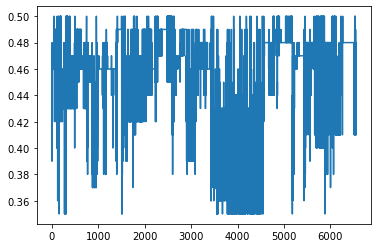

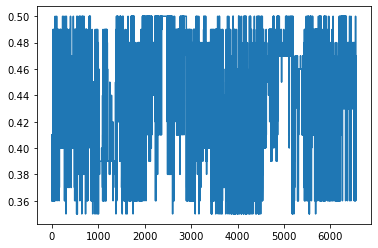

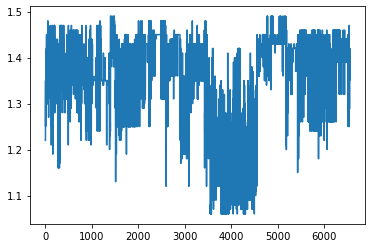

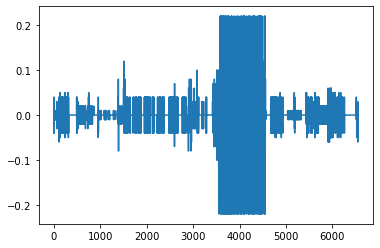

(6555, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-21/1/multi2-12212021101212-0000.avi
Opened video: True


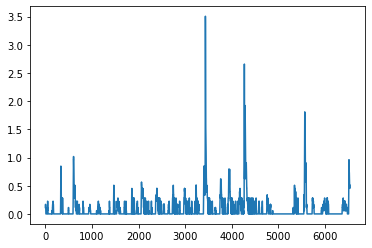

(6541, 5, 2)


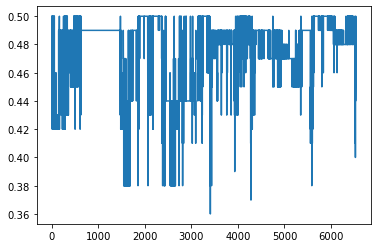

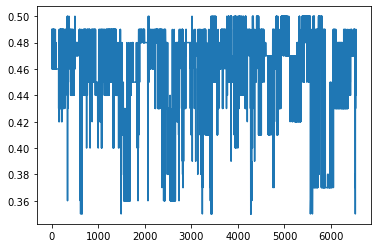

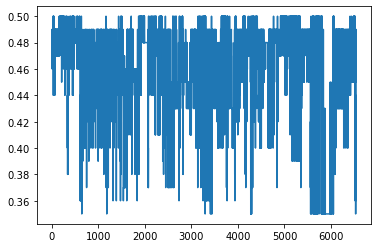

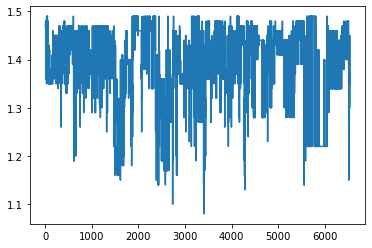

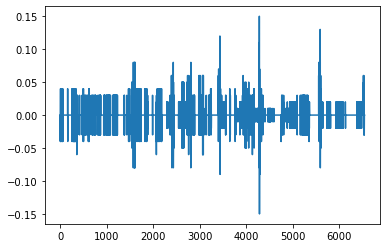

(6540, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-21/1/multi2-12212021101610-0000.avi
Opened video: True
CORRECTING!!!!!!!!!!!!!!! 0.5 0
CORRECTING!!!!!!!!!!!!!!! 0.5 1
CORRECTING!!!!!!!!!!!!!!! 0.5 2
CORRECTING!!!!!!!!!!!!!!! 0.5 3
CORRECTING!!!!!!!!!!!!!!! 0.5 4
CORRECTING!!!!!!!!!!!!!!! 0.5 5
CORRECTING!!!!!!!!!!!!!!! 0.5 6
CORRECTING!!!!!!!!!!!!!!! 0.5 7
CORRECTING!!!!!!!!!!!!!!! 0.5 8


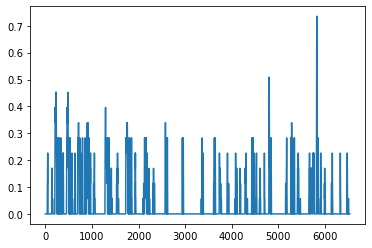

(6544, 5, 2)


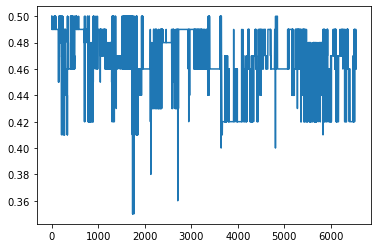

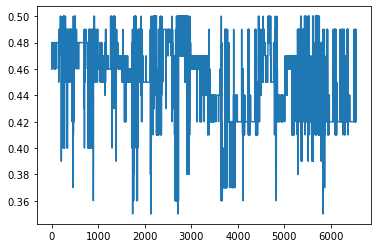

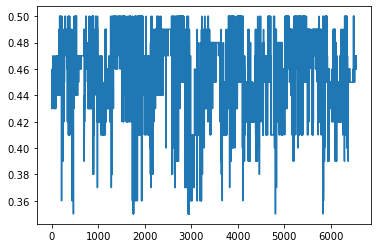

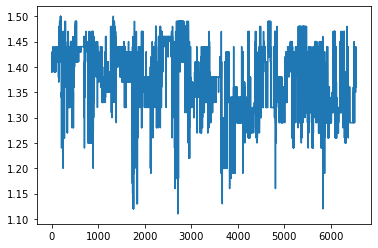

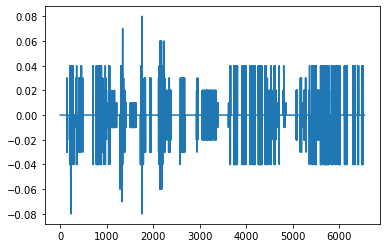

(6543, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-21/2/multi2-12212021103005-0000.avi
Opened video: True


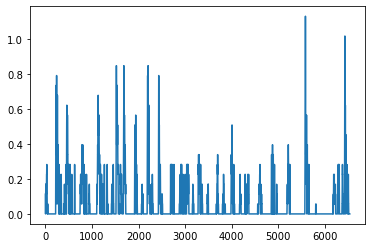

(6545, 5, 2)


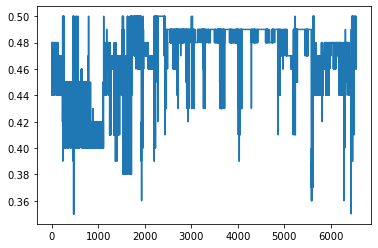

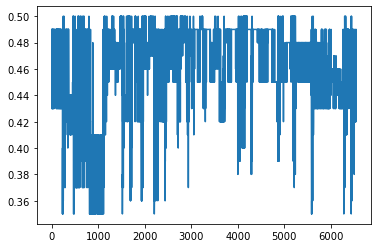

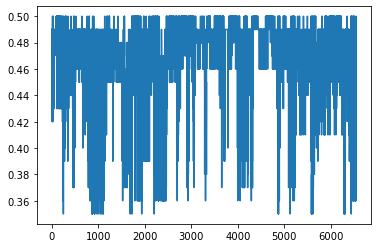

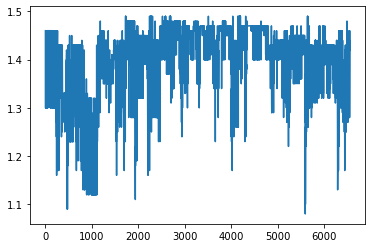

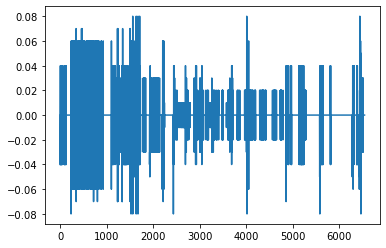

(6544, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-21/2/multi2-12212021104204-0000.avi
Opened video: True


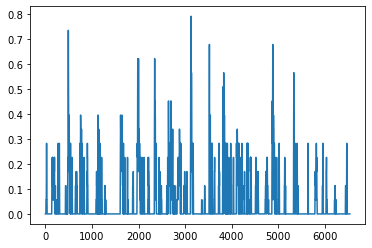

(6546, 5, 2)


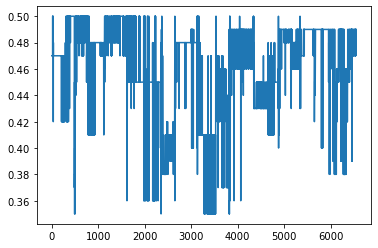

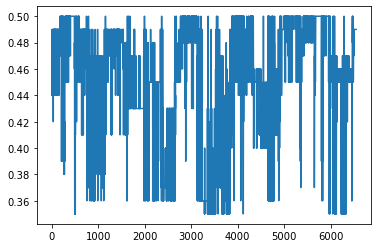

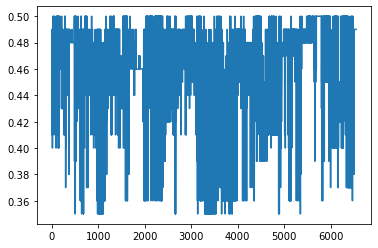

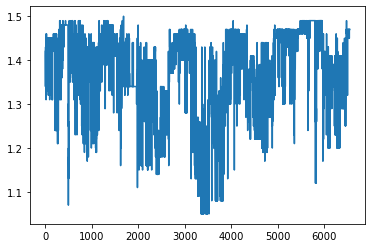

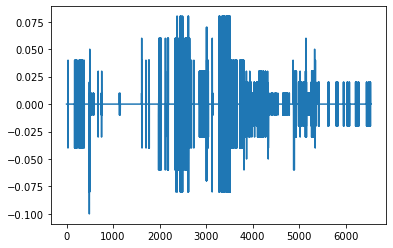

(6545, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-21/2/multi2-12212021104811-0000.avi
Opened video: True
CORRECTING!!!!!!!!!!!!!!! 0.36999999999999955 0


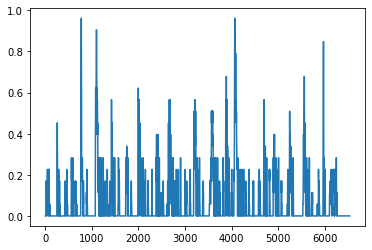

(6550, 5, 2)


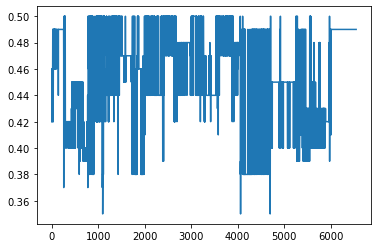

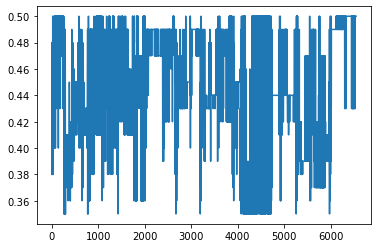

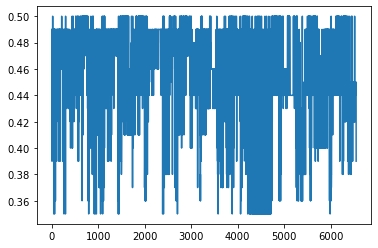

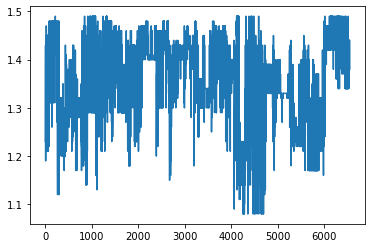

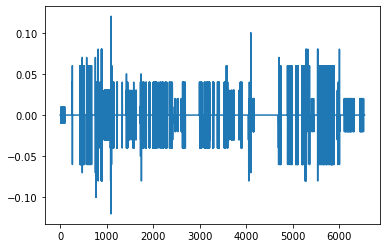

(6549, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-21/3/multi2-12212021105918-0000.avi
Opened video: True


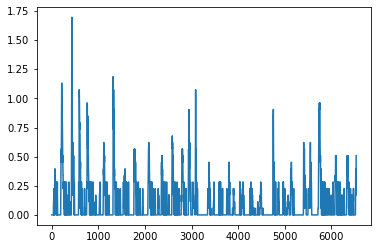

(6544, 5, 2)


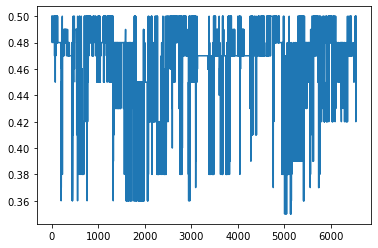

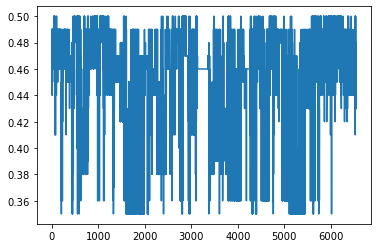

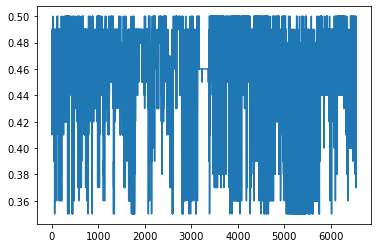

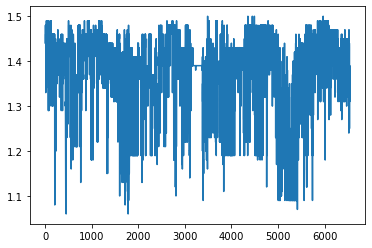

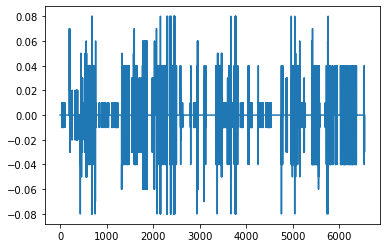

(6543, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-21/3/multi2-12212021110106-0000.avi
Opened video: True


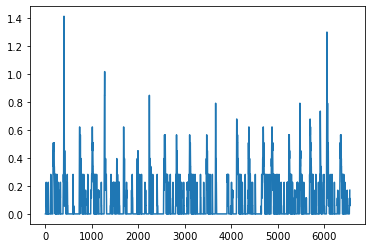

(6554, 5, 2)


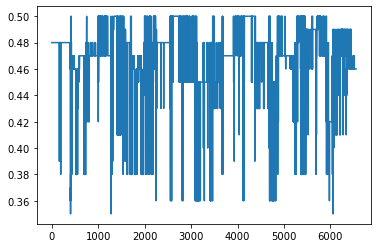

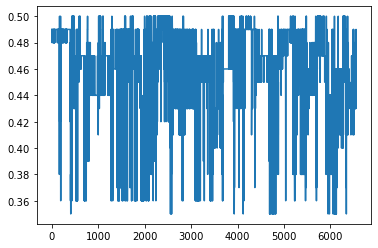

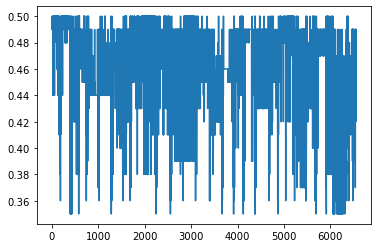

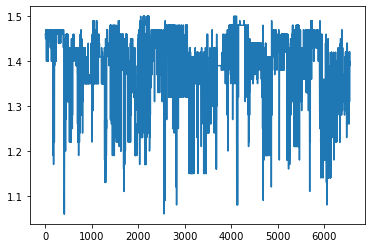

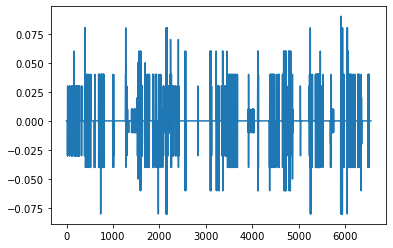

(6553, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']
Tracking custom video.
D:\Nico\Videos Zebrafish/Multi2 (MULTI2 - Diciembre 2021)/2021-12-21/3/multi2-12212021110316-0000.avi
Opened video: True


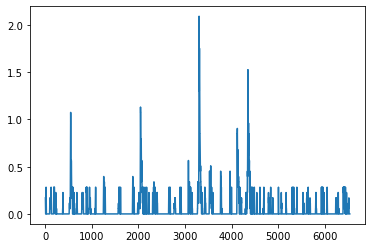

(6552, 5, 2)


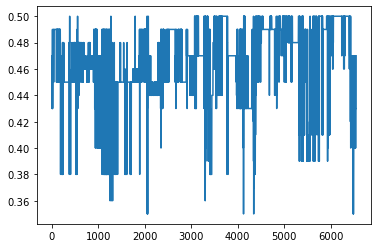

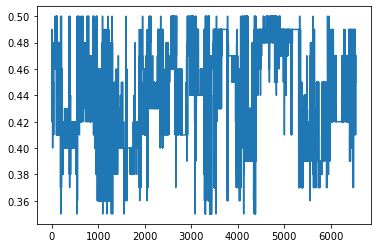

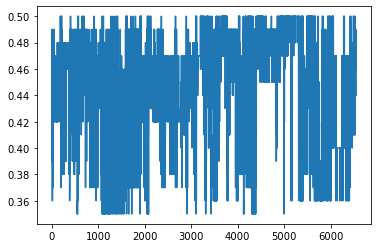

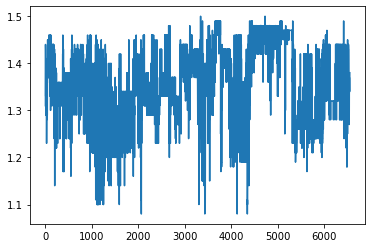

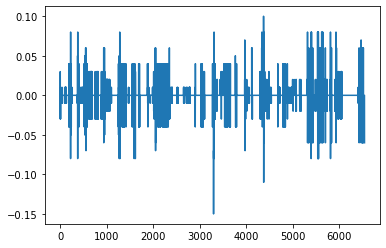

(6551, 18)
['frame', 'anterior_x', 'anterior_y', 'anterior_angular_change', 'distance', 'axis_point_0_x', 'axis_point_0_y', 'axis_point_1_x', 'axis_point_1_y', 'axis_point_2_x', 'axis_point_2_y', 'axis_point_3_x', 'axis_point_3_y', 'axis_point_4_x', 'axis_point_4_y', 'axis_angle_0', 'axis_angle_1', 'axis_angle_2']


In [155]:
bff = {}
os.chdir(video_dir)

if video_name is not None:
    directories = []
    look_for_video(os.getcwd())
    
    for video in video_name:
        d = None
        for directory in directories:
            if video in directory:
                d = directory
                break
        if d is not None:
            print("Tracking custom video.")
            print(d)
            
            try:
                res = track(p, bff, d)
            except:
                cv2.destroyAllWindows()
                traceback.print_exc()
                break
            
            try:
                process_results(p, bff, res, video)
            except:
                print("COULD NOT PROCESS OR SAVE TRACKED VIDEO:", video)
                traceback.print_exc()
else:
    errors = []
    
    print("Initiallizing tracking on video list.")
    for i in range(len(dataset)):
        ID = dataset.loc[i, "Trial"]
        
        cond = True
        
        for j in range(len(cond_keys)):
            key = cond_keys[j]
            value = cond_values[j]
            
            cond = cond and (dataset.loc[i, key] == value)
        
        if cond and ID >= IDrange[0] and ID <= IDrange[1]:
            video = str(dataset.loc[i, "Video"]) + ".avi"
            
            
            print("Row: " + str(i))
            print("Video: " + video)
            print("Visual: " + str(dataset.loc[i, "Visual"]))
            print("Auditivo: " + str(dataset.loc[i, "Auditivo"]))
            #print("L/V: " + str(dataset.loc[i, "l_v"]))
            #print("LED: " + str(dataset.loc[i, "F_LED"]))
            print("Response: " + str(dataset.loc[i, "F_escape"]))
            
            for d in directories:
                if video in d:
                    video_name = d
                    break
            
            if video_name is not None:
                bff = {}
                
                try:
                    res = track(p, bff, video_name)
                    process_results(p, bff, res, video)
                except:
                    cv2.destroyAllWindows()
                    traceback.print_exc()
                    errors.append(video_name)

                if bff["broken"]:
                    break
            else:
                print("Video Not Found in: " + os.getcwd())
    print("COULD NOT ANALYZE THE FOLLOWING VIDEOS:")
    print(errors)

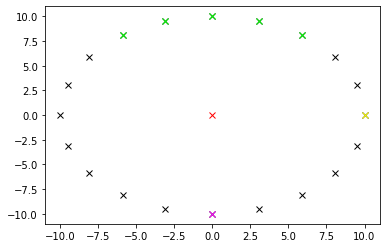

In [73]:
center = [0,0]
last_center = [0, -10]
angle = 0.3

points = np.array(get_n_directions(center, 20, 10))
plt.plot(points[:,0], points[:,1], 'x', color = (0,0,0))

plt.plot(points[0,0], points[0,1], 'x', color = (1,1,0))

plt.plot(center[0], center[1], 'x', color=(1,0,0))
plt.plot(last_center[0], last_center[1], 'x', color=(1,0,1))

points = np.array(filter_points_by_angle(center, last_center, points, angle))
plt.plot(points[:,0], points[:,1], 'x', color = (0,1,0))